In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/OFTALMOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=138.3, y1=121.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 269
Page 1, Q1, A: Yellow percentage: 0.0%


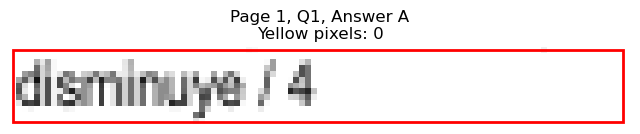

Page 1, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=133.0, y1=133.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 210
Page 1, Q1, B: Yellow percentage: 0.0%


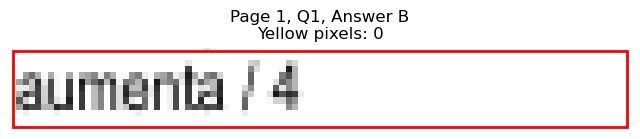

Page 1, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=138.3, y1=145.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 273
Page 1, Q1, C: Yellow percentage: 0.0%


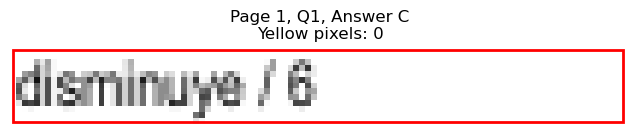

Page 1, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=390.0, y1=121.3
Page 1, Q1, D: Yellow pixels: 104
Page 1, Q1, D: Total non-white pixels: 337
Page 1, Q1, D: Yellow percentage: 30.9%


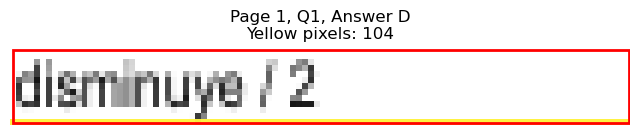

Page 1, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=384.6, y1=133.3
Page 1, Q1, E: Yellow pixels: 1011
Page 1, Q1, E: Total non-white pixels: 1287
Page 1, Q1, E: Yellow percentage: 78.6%


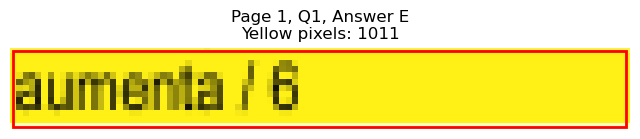


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=144.4, y1=181.5
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 313
Page 1, Q2, A: Yellow percentage: 0.0%


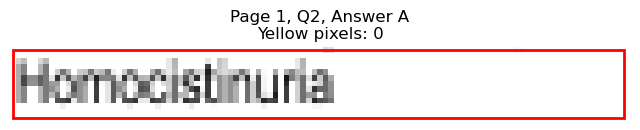

Page 1, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=127.6, y1=193.5
Page 1, Q2, B: Yellow pixels: 94
Page 1, Q2, B: Total non-white pixels: 315
Page 1, Q2, B: Yellow percentage: 29.8%


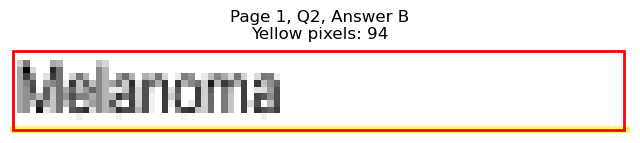

Page 1, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=147.3, y1=205.5
Page 1, Q2, C: Yellow pixels: 1194
Page 1, Q2, C: Total non-white pixels: 1482
Page 1, Q2, C: Yellow percentage: 80.6%


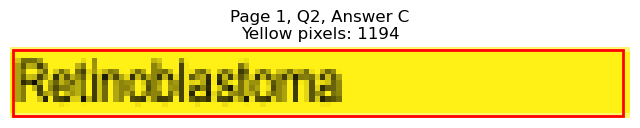

Page 1, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=419.5, y1=181.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 433
Page 1, Q2, D: Yellow percentage: 0.0%


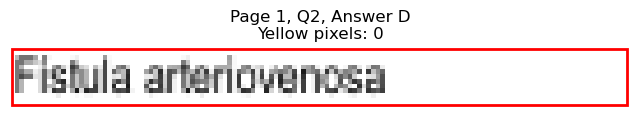

Page 1, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=376.4, y1=193.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 190
Page 1, Q2, E: Yellow percentage: 0.0%


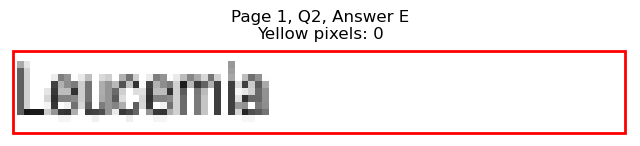


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=209.0, y1=253.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 575
Page 1, Q3, A: Yellow percentage: 0.0%


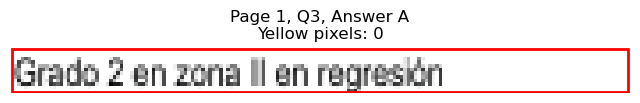

Page 1, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=190.4, y1=265.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 489
Page 1, Q3, B: Yellow percentage: 0.0%


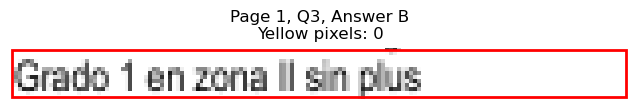

Page 1, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=190.9, y1=277.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 513
Page 1, Q3, C: Yellow percentage: 0.0%


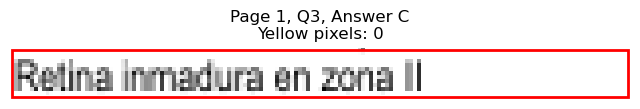

Page 1, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=456.5, y1=253.8
Page 1, Q3, D: Yellow pixels: 1611
Page 1, Q3, D: Total non-white pixels: 2223
Page 1, Q3, D: Yellow percentage: 72.5%


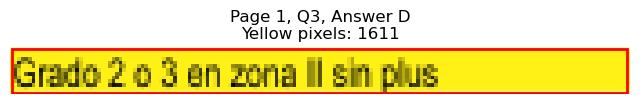

Page 1, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=444.5, y1=265.8
Page 1, Q3, E: Yellow pixels: 157
Page 1, Q3, E: Total non-white pixels: 669
Page 1, Q3, E: Yellow percentage: 23.5%


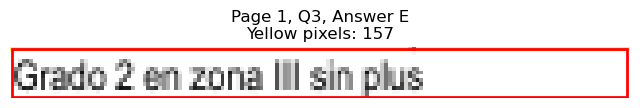


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=345.4, y1=314.0
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 1356
Page 1, Q4, A: Yellow percentage: 0.0%


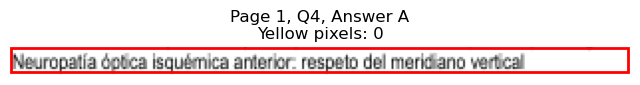

Page 1, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=279.3, y1=326.0
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 1006
Page 1, Q4, B: Yellow percentage: 0.0%


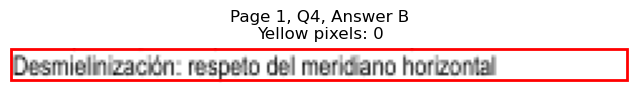

Page 1, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=197.0, y1=338.2
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 544
Page 1, Q4, C: Yellow percentage: 0.0%


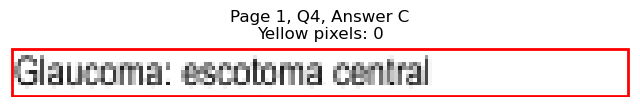

Page 1, Q4 - D: Detected box: x0=85.0, y0=338.1, x1=185.5, y1=350.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 505
Page 1, Q4, D: Yellow percentage: 0.0%


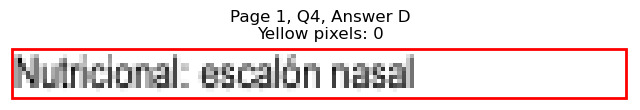

Page 1, Q4 - E: Detected box: x0=85.0, y0=350.2, x1=248.2, y1=362.3
Page 1, Q4, E: Yellow pixels: 1882
Page 1, Q4, E: Total non-white pixels: 2795
Page 1, Q4, E: Yellow percentage: 67.3%


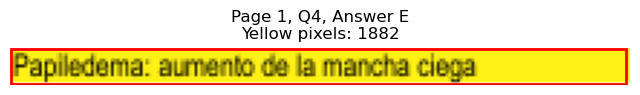


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=410.4, x1=124.2, y1=422.5
Page 1, Q5, A: Yellow pixels: 91
Page 1, Q5, A: Total non-white pixels: 276
Page 1, Q5, A: Yellow percentage: 33.0%


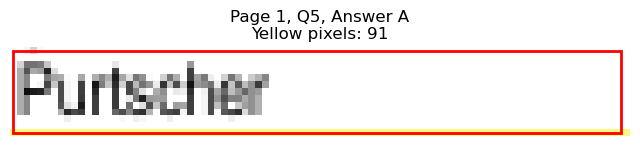

Page 1, Q5 - B: Detected box: x0=85.0, y0=422.4, x1=109.0, y1=434.5
Page 1, Q5, B: Yellow pixels: 875
Page 1, Q5, B: Total non-white pixels: 975
Page 1, Q5, B: Yellow percentage: 89.7%


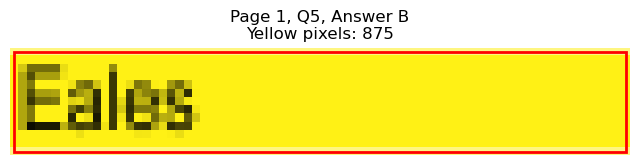

Page 1, Q5 - C: Detected box: x0=85.0, y0=434.4, x1=109.8, y1=446.5
Page 1, Q5, C: Yellow pixels: 76
Page 1, Q5, C: Total non-white pixels: 204
Page 1, Q5, C: Yellow percentage: 37.3%


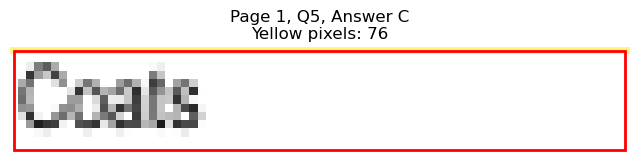

Page 1, Q5 - D: Detected box: x0=336.7, y0=410.4, x1=361.6, y1=422.5
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 117
Page 1, Q5, D: Yellow percentage: 0.0%


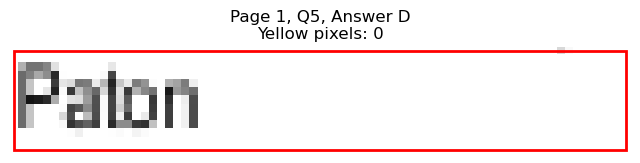

Page 1, Q5 - E: Detected box: x0=336.7, y0=422.4, x1=363.9, y1=434.5
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 152
Page 1, Q5, E: Yellow percentage: 0.0%


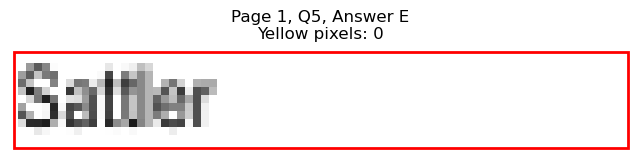


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=506.8, x1=135.3, y1=518.9
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 272
Page 1, Q6, A: Yellow percentage: 0.0%


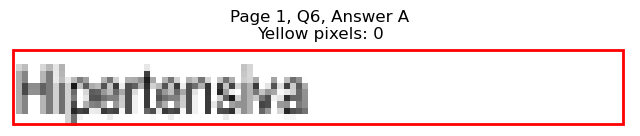

Page 1, Q6 - B: Detected box: x0=85.0, y0=518.8, x1=123.3, y1=530.9
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 221
Page 1, Q6, B: Yellow percentage: 0.0%


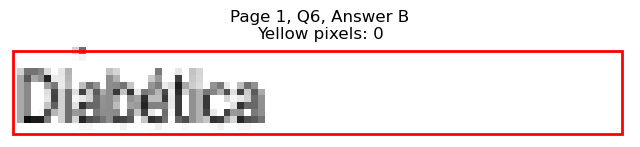

Page 1, Q6 - C: Detected box: x0=85.0, y0=530.9, x1=124.3, y1=543.0
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 223
Page 1, Q6, C: Yellow percentage: 0.0%


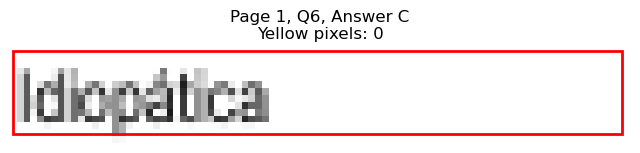

Page 1, Q6 - D: Detected box: x0=336.7, y0=506.8, x1=375.0, y1=518.9
Page 1, Q6, D: Yellow pixels: 899
Page 1, Q6, D: Total non-white pixels: 1157
Page 1, Q6, D: Yellow percentage: 77.7%


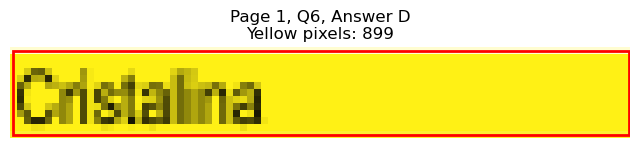

Page 1, Q6 - E: Detected box: x0=336.7, y0=518.8, x1=394.6, y1=530.9
Page 1, Q6, E: Yellow pixels: 109
Page 1, Q6, E: Total non-white pixels: 394
Page 1, Q6, E: Yellow percentage: 27.7%


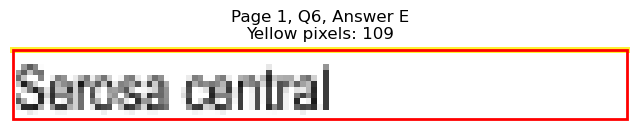


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=567.1, x1=104.2, y1=579.2
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 91
Page 1, Q7, A: Yellow percentage: 0.0%


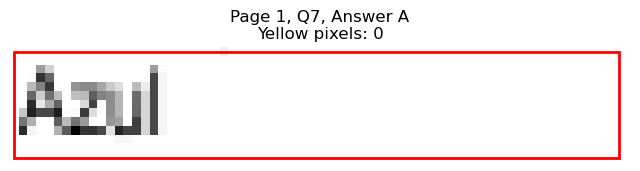

Page 1, Q7 - B: Detected box: x0=85.0, y0=579.1, x1=118.5, y1=591.2
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 158
Page 1, Q7, B: Yellow percentage: 0.0%


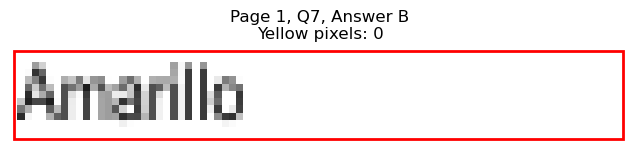

Page 1, Q7 - C: Detected box: x0=85.0, y0=591.2, x1=105.1, y1=603.3
Page 1, Q7, C: Yellow pixels: 768
Page 1, Q7, C: Total non-white pixels: 936
Page 1, Q7, C: Yellow percentage: 82.1%


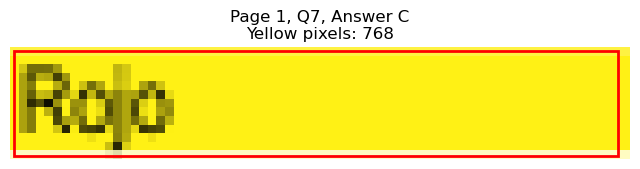

Page 1, Q7 - D: Detected box: x0=336.7, y0=567.1, x1=362.0, y1=579.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 129
Page 1, Q7, D: Yellow percentage: 0.0%


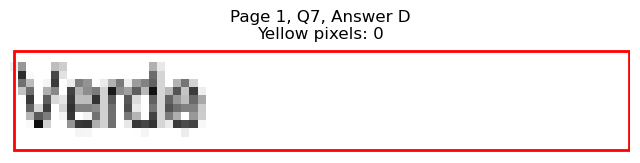

Page 1, Q7 - E: Detected box: x0=336.7, y0=579.1, x1=365.4, y1=591.2
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 151
Page 1, Q7, E: Yellow percentage: 0.0%


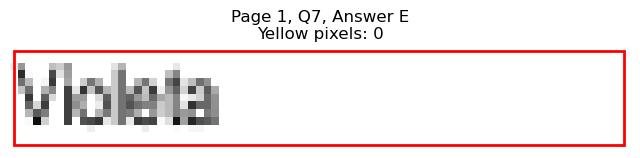


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=627.3, x1=132.4, y1=639.4
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 275
Page 1, Q8, A: Yellow percentage: 0.0%


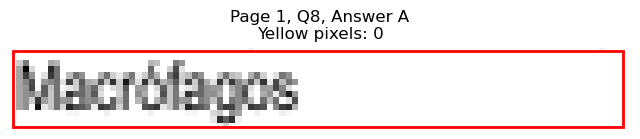

Page 1, Q8 - B: Detected box: x0=85.0, y0=639.3, x1=136.2, y1=651.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 266
Page 1, Q8, B: Yellow percentage: 0.0%


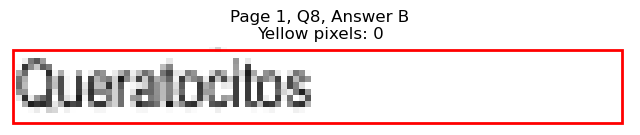

Page 1, Q8 - C: Detected box: x0=85.0, y0=651.4, x1=133.3, y1=663.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 254
Page 1, Q8, C: Yellow percentage: 0.0%


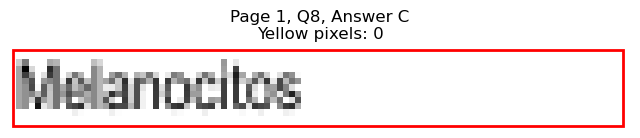

Page 1, Q8 - D: Detected box: x0=336.7, y0=627.3, x1=380.7, y1=639.4
Page 1, Q8, D: Yellow pixels: 953
Page 1, Q8, D: Total non-white pixels: 1235
Page 1, Q8, D: Yellow percentage: 77.2%


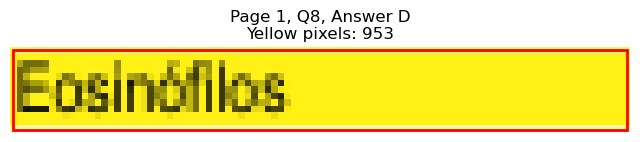

Page 1, Q8 - E: Detected box: x0=336.7, y0=639.3, x1=378.3, y1=651.4
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 308
Page 1, Q8, E: Yellow percentage: 0.0%


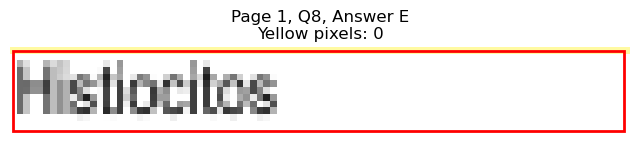


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=197.5, y1=699.7
Page 1, Q9, A: Yellow pixels: 164
Page 1, Q9, A: Total non-white pixels: 722
Page 1, Q9, A: Yellow percentage: 22.7%


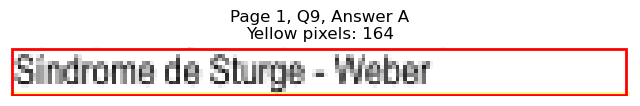

Page 1, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=193.6, y1=711.7
Page 1, Q9, B: Yellow pixels: 1622
Page 1, Q9, B: Total non-white pixels: 2080
Page 1, Q9, B: Yellow percentage: 78.0%


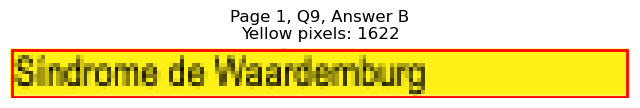

Page 1, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=148.7, y1=723.8
Page 1, Q9, C: Yellow pixels: 115
Page 1, Q9, C: Total non-white pixels: 441
Page 1, Q9, C: Yellow percentage: 26.1%


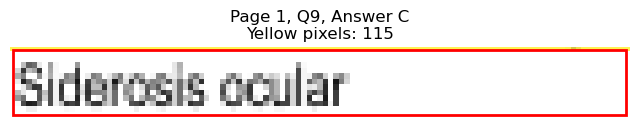

Page 1, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=391.8, y1=699.7
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 269
Page 1, Q9, D: Yellow percentage: 0.0%


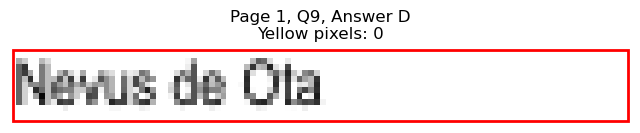

Page 1, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=425.2, y1=711.7
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 428
Page 1, Q9, E: Yellow percentage: 0.0%


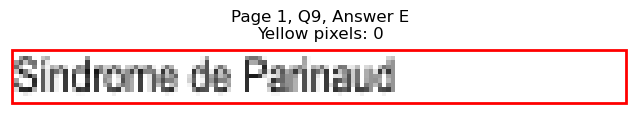


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=85.0, y0=747.8, x1=130.9, y1=759.9
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 263
Page 1, Q10, A: Yellow percentage: 0.0%


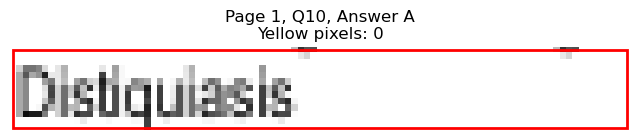

Page 1, Q10 - B: Detected box: x0=85.0, y0=759.8, x1=157.2, y1=771.9
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 389
Page 1, Q10, B: Yellow percentage: 0.0%


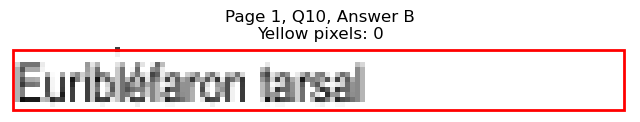

Page 1, Q10 - C: Detected box: x0=85.0, y0=771.9, x1=130.9, y1=784.0
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 247
Page 1, Q10, C: Yellow percentage: 0.0%


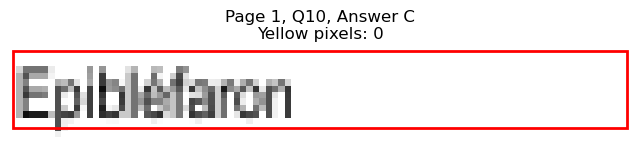

Page 1, Q10 - D: Detected box: x0=336.7, y0=747.8, x1=402.8, y1=759.9
Page 1, Q10, D: Yellow pixels: 1147
Page 1, Q10, D: Total non-white pixels: 1521
Page 1, Q10, D: Yellow percentage: 75.4%


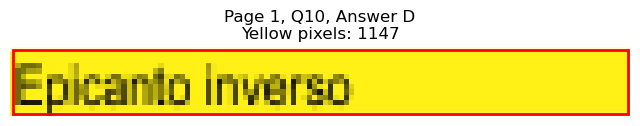

Page 1, Q10 - E: Detected box: x0=336.7, y0=759.8, x1=431.0, y1=771.9
Page 1, Q10, E: Yellow pixels: 144
Page 1, Q10, E: Total non-white pixels: 640
Page 1, Q10, E: Yellow percentage: 22.5%


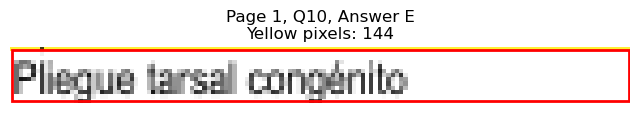


Page 1, Q10 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=130.9, y1=109.2
Page 2, Q1, A: Yellow pixels: 986
Page 2, Q1, A: Total non-white pixels: 1261
Page 2, Q1, A: Yellow percentage: 78.2%


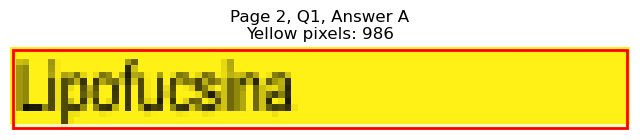

Page 2, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=130.0, y1=121.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 339
Page 2, Q1, B: Yellow percentage: 0.0%


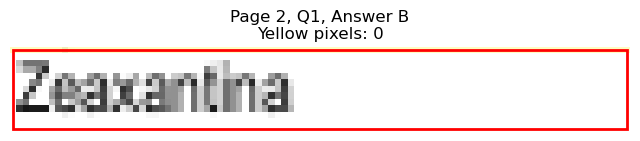

Page 2, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=122.3, y1=133.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 196
Page 2, Q1, C: Yellow percentage: 0.0%


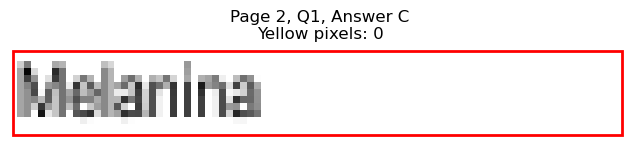

Page 2, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=367.8, y1=109.2
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 144
Page 2, Q1, D: Yellow percentage: 0.0%


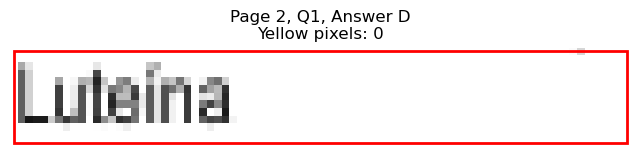

Page 2, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=380.2, y1=121.3
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 227
Page 2, Q1, E: Yellow percentage: 0.0%


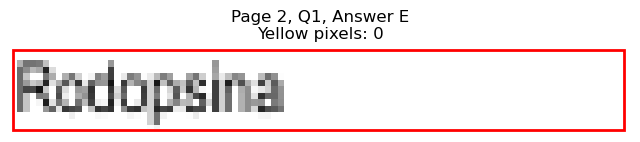


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=116.7, y1=169.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 143
Page 2, Q2, A: Yellow percentage: 0.0%


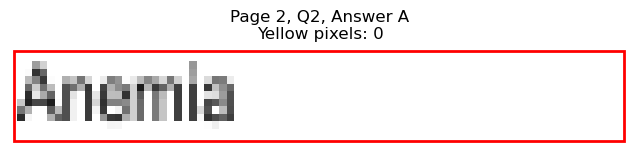

Page 2, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=141.5, y1=181.5
Page 2, Q2, B: Yellow pixels: 108
Page 2, Q2, B: Total non-white pixels: 393
Page 2, Q2, B: Yellow percentage: 27.5%


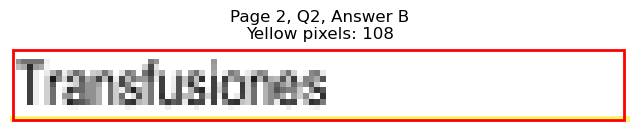

Page 2, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=153.5, y1=193.5
Page 2, Q2, C: Yellow pixels: 1265
Page 2, Q2, C: Total non-white pixels: 1560
Page 2, Q2, C: Yellow percentage: 81.1%


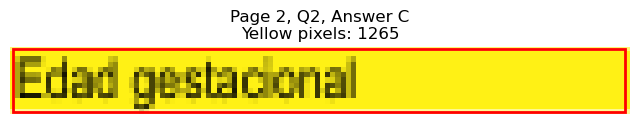

Page 2, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=388.4, y1=169.4
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 278
Page 2, Q2, D: Yellow percentage: 0.0%


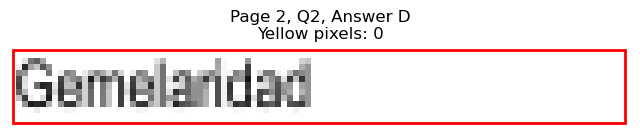

Page 2, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=364.9, y1=181.5
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 155
Page 2, Q2, E: Yellow percentage: 0.0%


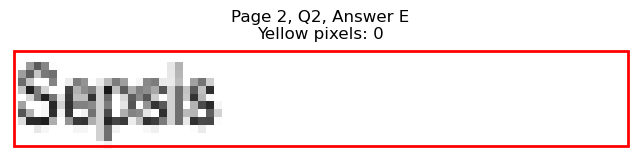


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=157.3, y1=229.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 386
Page 2, Q3, A: Yellow percentage: 0.0%


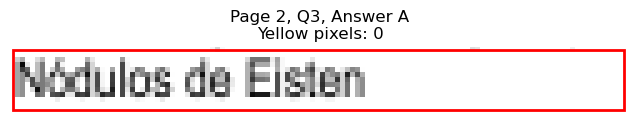

Page 2, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=146.9, y1=241.8
Page 2, Q3, B: Yellow pixels: 1105
Page 2, Q3, B: Total non-white pixels: 1469
Page 2, Q3, B: Yellow percentage: 75.2%


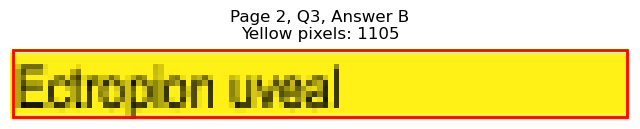

Page 2, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=120.4, y1=253.8
Page 2, Q3, C: Yellow pixels: 85
Page 2, Q3, C: Total non-white pixels: 283
Page 2, Q3, C: Yellow percentage: 30.0%


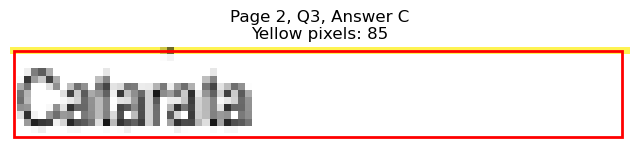

Page 2, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=403.6, y1=229.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 324
Page 2, Q3, D: Yellow percentage: 0.0%


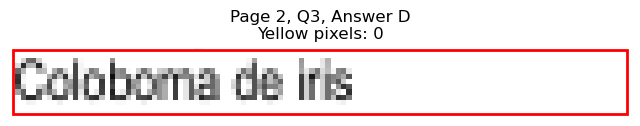

Page 2, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=412.3, y1=241.8
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 397
Page 2, Q3, E: Yellow percentage: 0.0%


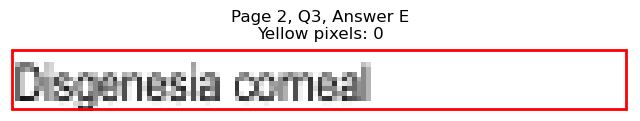


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=70.8, y0=289.9, x1=79.0, y1=302.0
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 63
Page 2, Q4, A: Yellow percentage: 0.0%


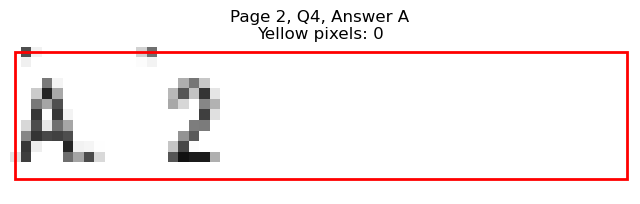

Page 2, Q4 - B: Detected box: x0=70.8, y0=301.9, x1=79.0, y1=314.0
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 58
Page 2, Q4, B: Yellow percentage: 0.0%


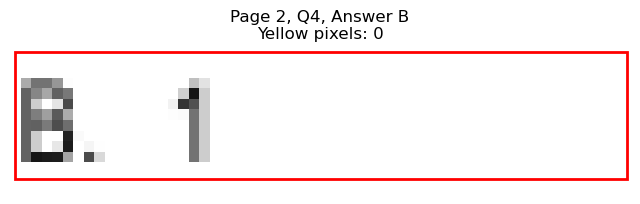

Page 2, Q4 - C: Detected box: x0=70.8, y0=313.9, x1=79.5, y1=326.0
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 61
Page 2, Q4, C: Yellow percentage: 0.0%


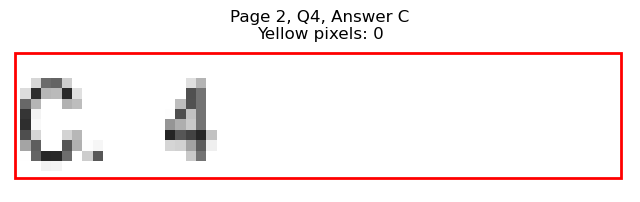

Page 2, Q4 - D: Detected box: x0=322.5, y0=289.9, x1=331.2, y1=302.0
Page 2, Q4, D: Yellow pixels: 60
Page 2, Q4, D: Total non-white pixels: 184
Page 2, Q4, D: Yellow percentage: 32.6%


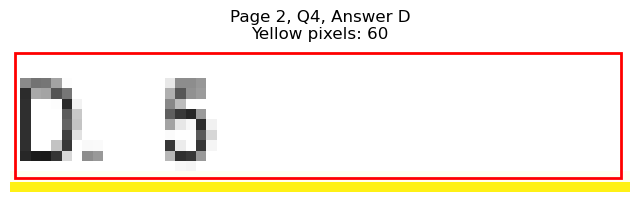

Page 2, Q4 - E: Detected box: x0=322.5, y0=301.9, x1=330.7, y1=314.0
Page 2, Q4, E: Yellow pixels: 661
Page 2, Q4, E: Total non-white pixels: 767
Page 2, Q4, E: Yellow percentage: 86.2%


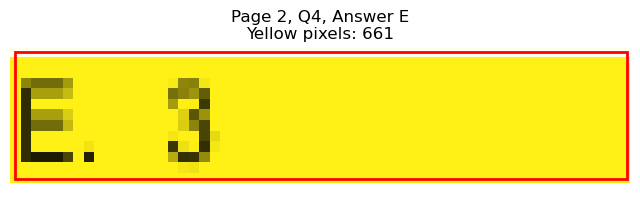


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=164.5, y1=374.3
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 427
Page 2, Q5, A: Yellow percentage: 0.0%


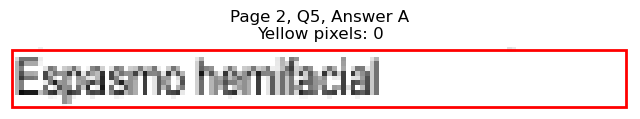

Page 2, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=164.4, y1=386.3
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 434
Page 2, Q5, B: Yellow percentage: 0.0%


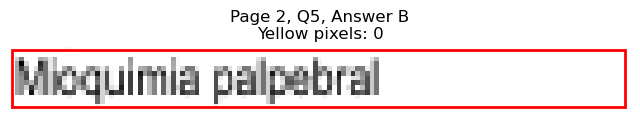

Page 2, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=209.9, y1=398.4
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 633
Page 2, Q5, C: Yellow percentage: 0.0%


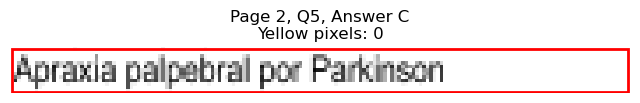

Page 2, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=435.3, y1=374.3
Page 2, Q5, D: Yellow pixels: 1363
Page 2, Q5, D: Total non-white pixels: 1950
Page 2, Q5, D: Yellow percentage: 69.9%


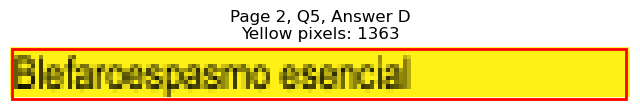

Page 2, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=434.4, y1=386.3
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 630
Page 2, Q5, E: Yellow percentage: 0.0%


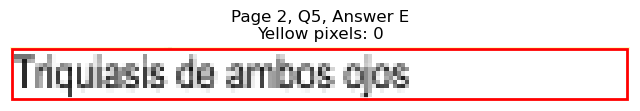


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=92.9, y0=434.4, x1=107.3, y1=446.5
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 74
Page 2, Q6, A: Yellow percentage: 0.0%


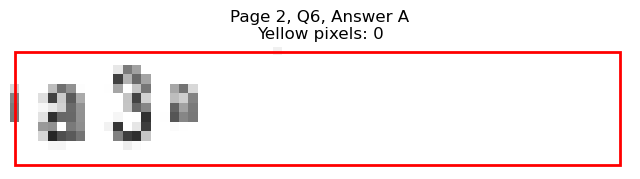

Page 2, Q6 - B: Detected box: x0=94.5, y0=446.6, x1=108.9, y1=458.7
Page 2, Q6, B: Yellow pixels: 65
Page 2, Q6, B: Total non-white pixels: 141
Page 2, Q6, B: Yellow percentage: 46.1%


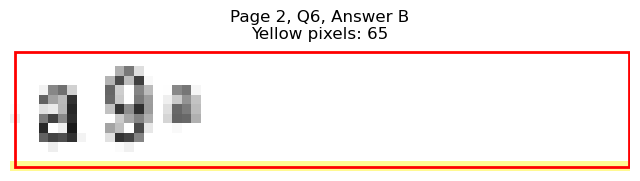

Page 2, Q6 - C: Detected box: x0=94.5, y0=458.6, x1=108.9, y1=470.7
Page 2, Q6, C: Yellow pixels: 786
Page 2, Q6, C: Total non-white pixels: 845
Page 2, Q6, C: Yellow percentage: 93.0%


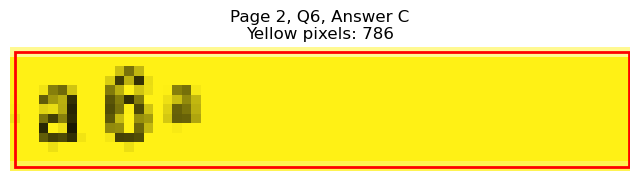

Page 2, Q6 - D: Detected box: x0=351.0, y0=434.4, x1=370.2, y1=446.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 89
Page 2, Q6, D: Yellow percentage: 0.0%


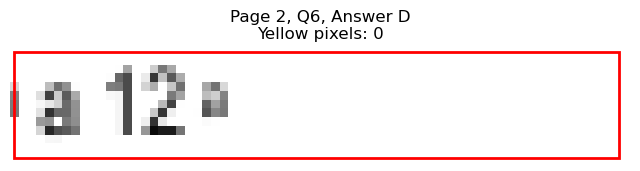

Page 2, Q6 - E: Detected box: x0=351.0, y0=446.6, x1=370.2, y1=458.7
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 96
Page 2, Q6, E: Yellow percentage: 0.0%


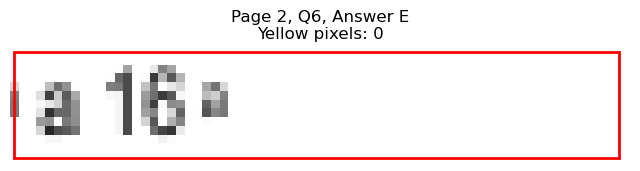


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=149.7, y1=530.9
Page 2, Q7, A: Yellow pixels: 1120
Page 2, Q7, A: Total non-white pixels: 1508
Page 2, Q7, A: Yellow percentage: 74.3%


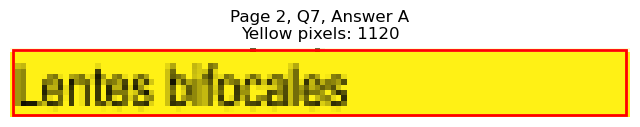

Page 2, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=175.5, y1=543.0
Page 2, Q7, B: Yellow pixels: 142
Page 2, Q7, B: Total non-white pixels: 603
Page 2, Q7, B: Yellow percentage: 23.5%


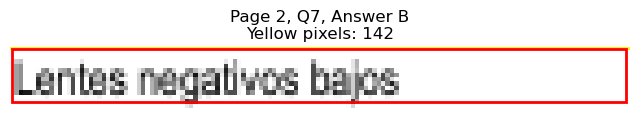

Page 2, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=168.3, y1=555.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 416
Page 2, Q7, C: Yellow percentage: 0.0%


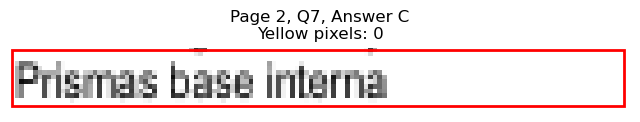

Page 2, Q7 - D: Detected box: x0=336.7, y0=518.8, x1=417.1, y1=530.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 411
Page 2, Q7, D: Yellow percentage: 0.0%


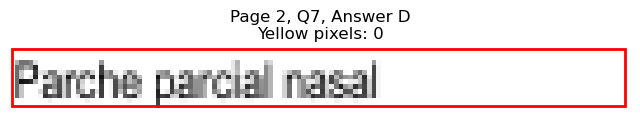

Page 2, Q7 - E: Detected box: x0=336.7, y0=530.9, x1=425.7, y1=543.0
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 456
Page 2, Q7, E: Yellow percentage: 0.0%


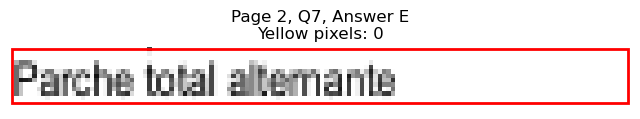


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=171.1, y1=591.2
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 440
Page 2, Q8, A: Yellow percentage: 0.0%


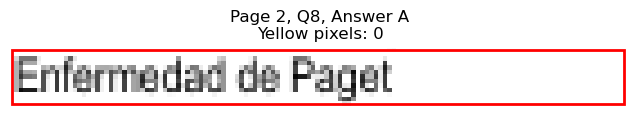

Page 2, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=156.3, y1=603.3
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 361
Page 2, Q8, B: Yellow percentage: 0.0%


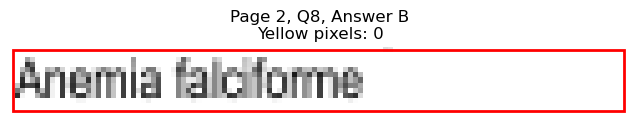

Page 2, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=135.3, y1=615.3
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 262
Page 2, Q8, C: Yellow percentage: 0.0%


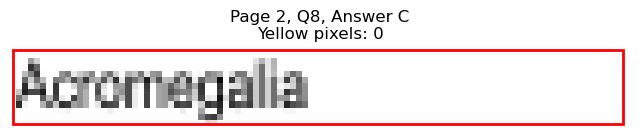

Page 2, Q8 - D: Detected box: x0=336.7, y0=579.1, x1=428.6, y1=591.2
Page 2, Q8, D: Yellow pixels: 1323
Page 2, Q8, D: Total non-white pixels: 1859
Page 2, Q8, D: Yellow percentage: 71.2%


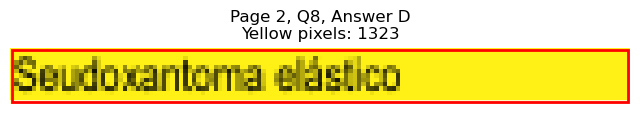

Page 2, Q8 - E: Detected box: x0=336.7, y0=591.2, x1=444.8, y1=603.3
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 685
Page 2, Q8, E: Yellow percentage: 0.0%


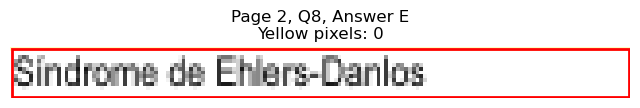


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=85.0, y0=639.3, x1=249.7, y1=651.4
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 828
Page 2, Q9, A: Yellow percentage: 0.0%


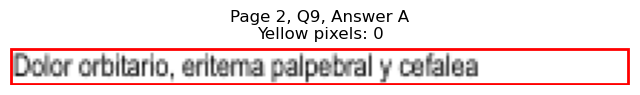

Page 2, Q9 - B: Detected box: x0=85.0, y0=651.4, x1=240.1, y1=663.5
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 747
Page 2, Q9, B: Yellow percentage: 0.0%


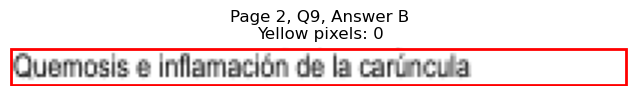

Page 2, Q9 - C: Detected box: x0=85.0, y0=663.4, x1=278.8, y1=675.5
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 1000
Page 2, Q9, C: Yellow percentage: 0.0%


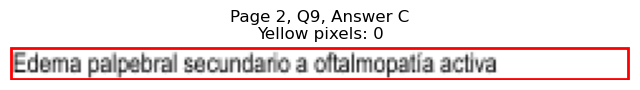

Page 2, Q9 - D: Detected box: x0=85.0, y0=675.4, x1=287.0, y1=687.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 1076
Page 2, Q9, D: Yellow percentage: 0.0%


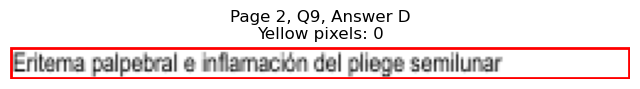

Page 2, Q9 - E: Detected box: x0=85.0, y0=687.5, x1=278.3, y1=699.7
Page 2, Q9, E: Yellow pixels: 2467
Page 2, Q9, E: Total non-white pixels: 3185
Page 2, Q9, E: Yellow percentage: 77.5%


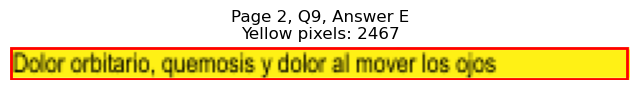


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=106.9, y1=747.9
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 146
Page 2, Q10, A: Yellow percentage: 0.0%


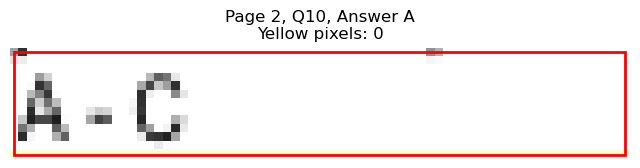

Page 2, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=106.9, y1=759.9
Page 2, Q10, B: Yellow pixels: 807
Page 2, Q10, B: Total non-white pixels: 949
Page 2, Q10, B: Yellow percentage: 85.0%


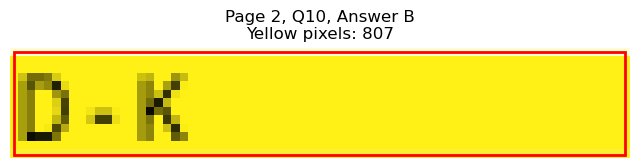

Page 2, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=106.9, y1=771.9
Page 2, Q10, C: Yellow pixels: 73
Page 2, Q10, C: Total non-white pixels: 143
Page 2, Q10, C: Yellow percentage: 51.0%


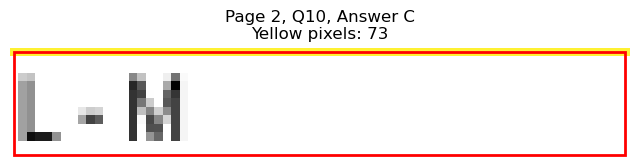

Page 2, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=358.6, y1=747.9
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 80
Page 2, Q10, D: Yellow percentage: 0.0%


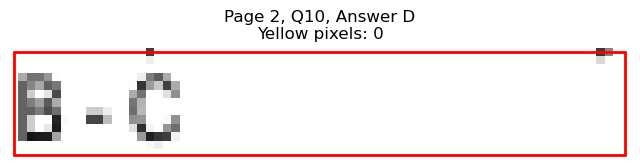

Page 2, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=357.8, y1=759.9
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 58
Page 2, Q10, E: Yellow percentage: 0.0%


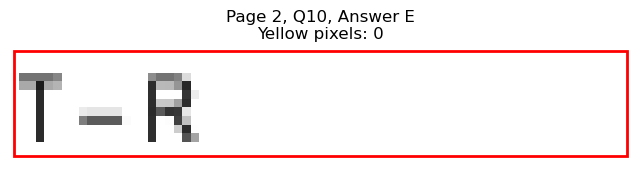


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=106.6, y1=121.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 98
Page 3, Q1, A: Yellow percentage: 0.0%


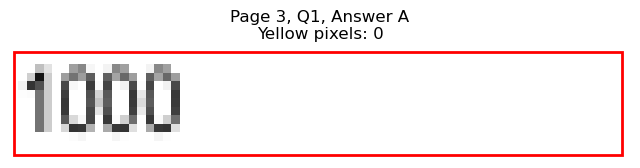

Page 3, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=106.6, y1=133.3
Page 3, Q1, B: Yellow pixels: 73
Page 3, Q1, B: Total non-white pixels: 175
Page 3, Q1, B: Yellow percentage: 41.7%


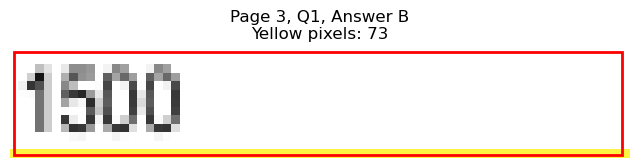

Page 3, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=101.8, y1=145.3
Page 3, Q1, C: Yellow pixels: 750
Page 3, Q1, C: Total non-white pixels: 884
Page 3, Q1, C: Yellow percentage: 84.8%


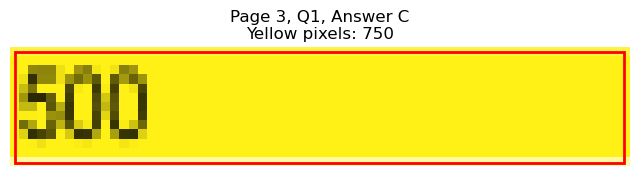

Page 3, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=358.3, y1=121.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 117
Page 3, Q1, D: Yellow percentage: 0.0%


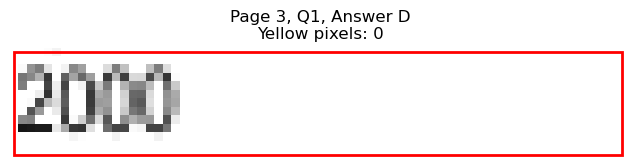

Page 3, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=358.3, y1=133.3
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 116
Page 3, Q1, E: Yellow percentage: 0.0%


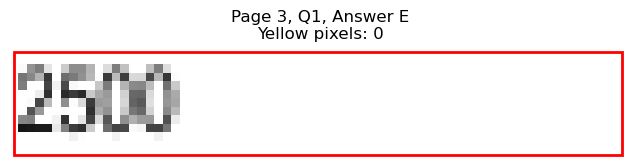


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=126.6, y1=181.5
Page 3, Q2, A: Yellow pixels: 1040
Page 3, Q2, A: Total non-white pixels: 1209
Page 3, Q2, A: Yellow percentage: 86.0%


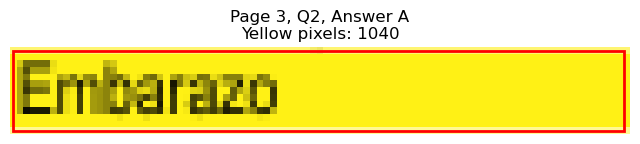

Page 3, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=147.7, y1=193.5
Page 3, Q2, B: Yellow pixels: 114
Page 3, Q2, B: Total non-white pixels: 430
Page 3, Q2, B: Yellow percentage: 26.5%


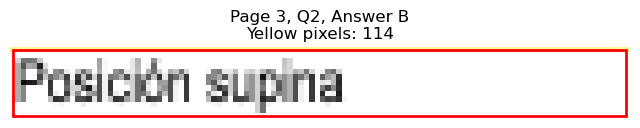

Page 3, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=131.9, y1=205.5
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 256
Page 3, Q2, C: Yellow percentage: 0.0%


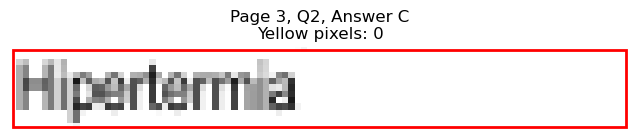

Page 3, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=393.7, y1=181.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 299
Page 3, Q2, D: Yellow percentage: 0.0%


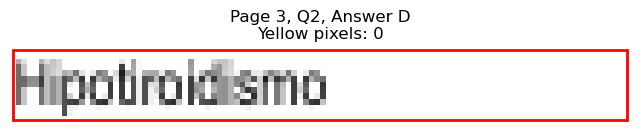

Page 3, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=401.4, y1=193.5
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 346
Page 3, Q2, E: Yellow percentage: 0.0%


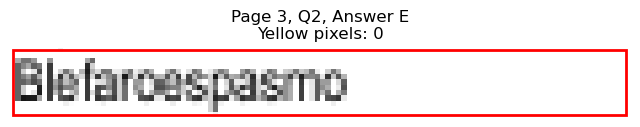


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=118.5, y1=265.8
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 186
Page 3, Q3, A: Yellow percentage: 0.0%


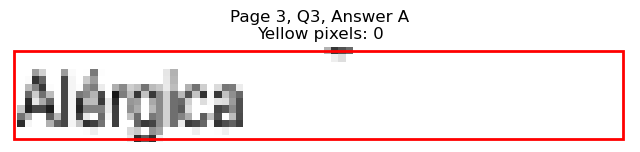

Page 3, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=118.9, y1=277.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 285
Page 3, Q3, B: Yellow percentage: 0.0%


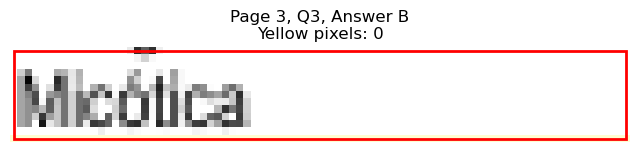

Page 3, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=104.7, y1=289.9
Page 3, Q3, C: Yellow pixels: 779
Page 3, Q3, C: Total non-white pixels: 923
Page 3, Q3, C: Yellow percentage: 84.4%


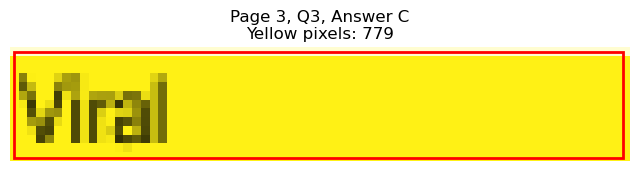

Page 3, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=380.2, y1=265.8
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 234
Page 3, Q3, D: Yellow percentage: 0.0%


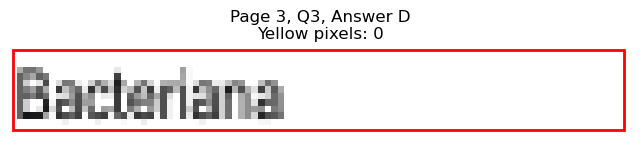

Page 3, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=380.2, y1=277.9
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 239
Page 3, Q3, E: Yellow percentage: 0.0%


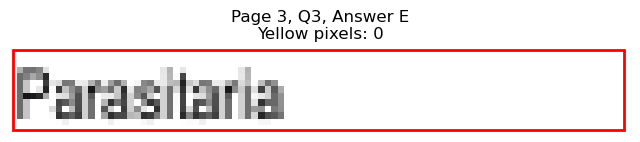


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=164.9, y1=326.0
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 411
Page 3, Q4, A: Yellow percentage: 0.0%


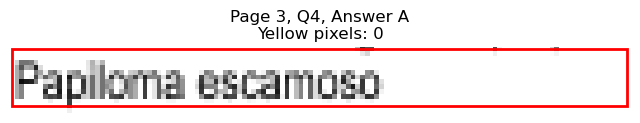

Page 3, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=163.5, y1=338.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 395
Page 3, Q4, B: Yellow percentage: 0.0%


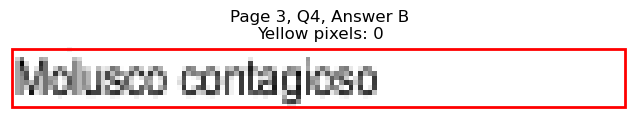

Page 3, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=171.6, y1=350.2
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 459
Page 3, Q4, C: Yellow percentage: 0.0%


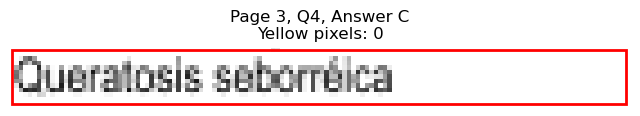

Page 3, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=397.0, y1=326.0
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 330
Page 3, Q4, D: Yellow percentage: 0.0%


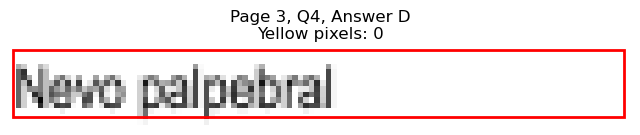

Page 3, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=427.2, y1=338.2
Page 3, Q4, E: Yellow pixels: 1352
Page 3, Q4, E: Total non-white pixels: 1846
Page 3, Q4, E: Yellow percentage: 73.2%


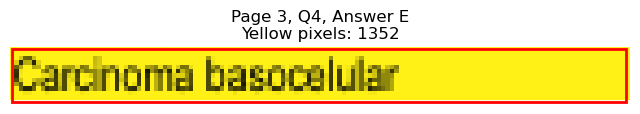


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=174.0, y1=386.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 450
Page 3, Q5, A: Yellow percentage: 0.0%


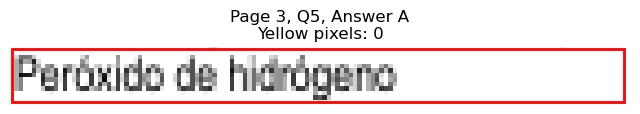

Page 3, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=175.9, y1=398.4
Page 3, Q5, B: Yellow pixels: 1337
Page 3, Q5, B: Total non-white pixels: 1846
Page 3, Q5, B: Yellow percentage: 72.4%


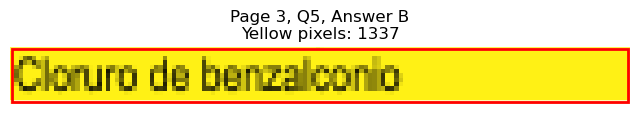

Page 3, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=157.7, y1=410.4
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 460
Page 3, Q5, C: Yellow percentage: 0.0%


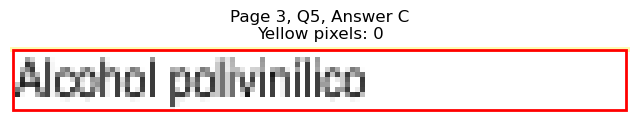

Page 3, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=421.5, y1=386.3
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 460
Page 3, Q5, D: Yellow percentage: 0.0%


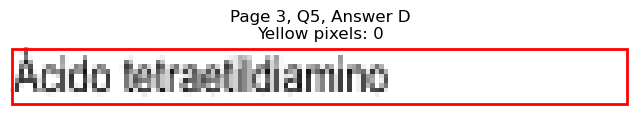

Page 3, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=426.7, y1=398.4
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 478
Page 3, Q5, E: Yellow percentage: 0.0%


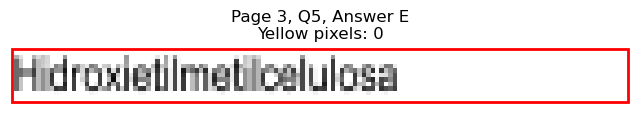


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=187.5, y1=446.5
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 513
Page 3, Q6, A: Yellow percentage: 0.0%


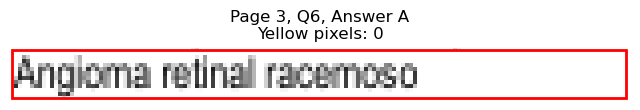

Page 3, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=219.5, y1=458.7
Page 3, Q6, B: Yellow pixels: 1826
Page 3, Q6, B: Total non-white pixels: 2418
Page 3, Q6, B: Yellow percentage: 75.5%


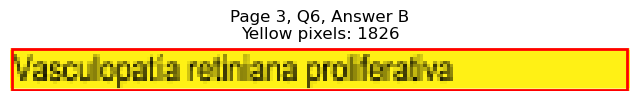

Page 3, Q6 - C: Detected box: x0=85.0, y0=458.6, x1=202.3, y1=470.7
Page 3, Q6, C: Yellow pixels: 169
Page 3, Q6, C: Total non-white pixels: 773
Page 3, Q6, C: Yellow percentage: 21.9%


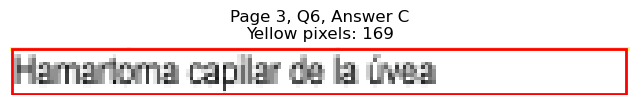

Page 3, Q6 - D: Detected box: x0=336.7, y0=434.4, x1=493.7, y1=446.5
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 731
Page 3, Q6, D: Yellow percentage: 0.0%


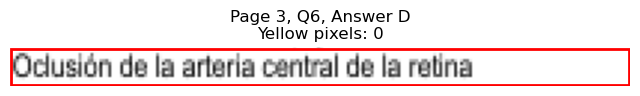

Page 3, Q6 - E: Detected box: x0=336.7, y0=446.6, x1=451.1, y1=458.7
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 609
Page 3, Q6, E: Yellow percentage: 0.0%


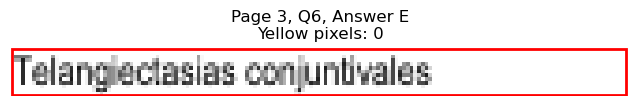


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=494.7, x1=128.1, y1=506.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 229
Page 3, Q7, A: Yellow percentage: 0.0%


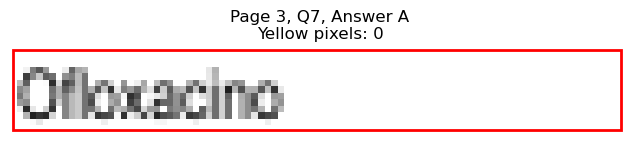

Page 3, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=128.5, y1=518.9
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 230
Page 3, Q7, B: Yellow percentage: 0.0%


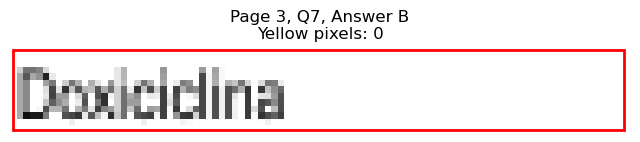

Page 3, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=146.3, y1=530.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 323
Page 3, Q7, C: Yellow percentage: 0.0%


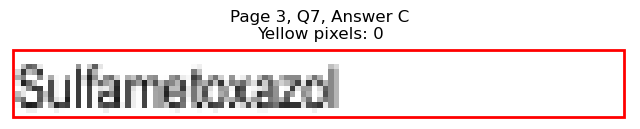

Page 3, Q7 - D: Detected box: x0=336.7, y0=494.7, x1=393.7, y1=506.8
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 285
Page 3, Q7, D: Yellow percentage: 0.0%


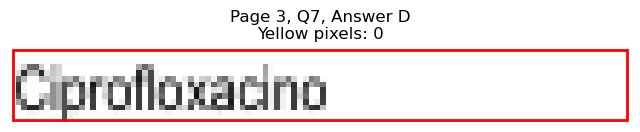

Page 3, Q7 - E: Detected box: x0=336.7, y0=506.8, x1=384.6, y1=518.9
Page 3, Q7, E: Yellow pixels: 1001
Page 3, Q7, E: Total non-white pixels: 1287
Page 3, Q7, E: Yellow percentage: 77.8%


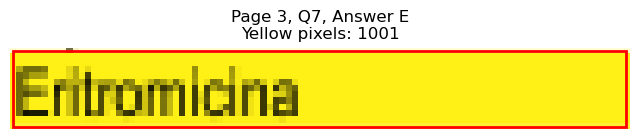


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=129.0, y1=591.2
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 217
Page 3, Q8, A: Yellow percentage: 0.0%


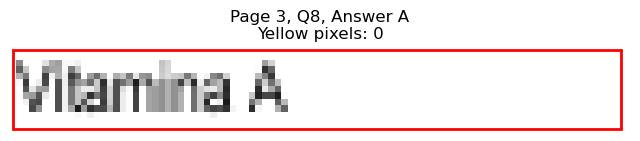

Page 3, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=180.3, y1=603.3
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 460
Page 3, Q8, B: Yellow percentage: 0.0%


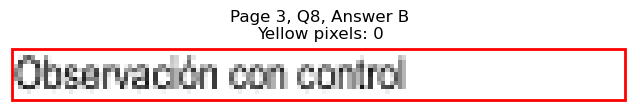

Page 3, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=173.1, y1=615.3
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 468
Page 3, Q8, C: Yellow percentage: 0.0%


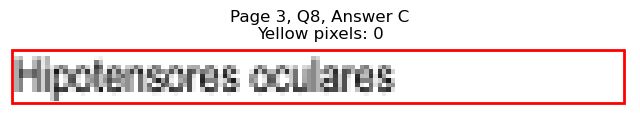

Page 3, Q8 - D: Detected box: x0=336.7, y0=579.1, x1=453.9, y1=591.2
Page 3, Q8, D: Yellow pixels: 1563
Page 3, Q8, D: Total non-white pixels: 2184
Page 3, Q8, D: Yellow percentage: 71.6%


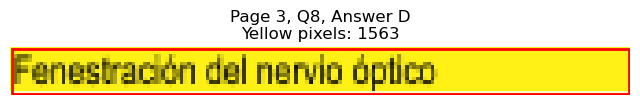

Page 3, Q8 - E: Detected box: x0=336.7, y0=591.2, x1=403.2, y1=603.3
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 446
Page 3, Q8, E: Yellow percentage: 0.0%


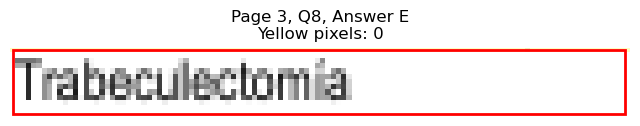


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=639.3, x1=159.6, y1=651.4
Page 3, Q9, A: Yellow pixels: 1345
Page 3, Q9, A: Total non-white pixels: 1638
Page 3, Q9, A: Yellow percentage: 82.1%


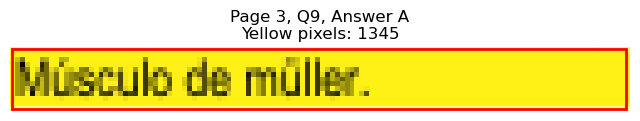

Page 3, Q9 - B: Detected box: x0=85.0, y0=651.4, x1=188.4, y1=663.5
Page 3, Q9, B: Yellow pixels: 155
Page 3, Q9, B: Total non-white pixels: 641
Page 3, Q9, B: Yellow percentage: 24.2%


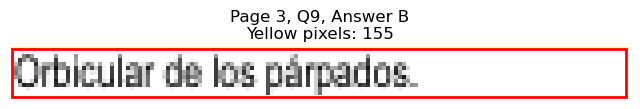

Page 3, Q9 - C: Detected box: x0=85.0, y0=663.4, x1=152.9, y1=675.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 322
Page 3, Q9, C: Yellow percentage: 0.0%


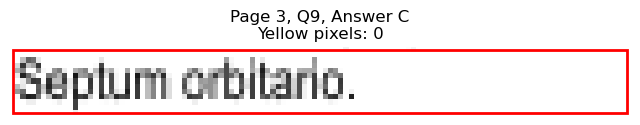

Page 3, Q9 - D: Detected box: x0=336.7, y0=639.3, x1=406.6, y1=651.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 339
Page 3, Q9, D: Yellow percentage: 0.0%


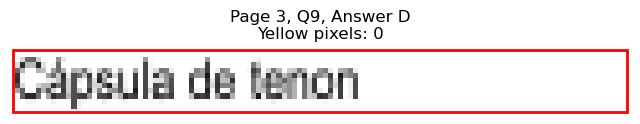

Page 3, Q9 - E: Detected box: x0=336.7, y0=651.4, x1=454.4, y1=663.5
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 614
Page 3, Q9, E: Yellow percentage: 0.0%


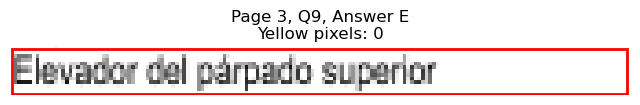


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=85.0, y0=699.5, x1=134.8, y1=711.7
Page 3, Q10, A: Yellow pixels: 1116
Page 3, Q10, A: Total non-white pixels: 1313
Page 3, Q10, A: Yellow percentage: 85.0%


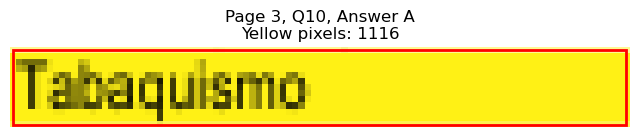

Page 3, Q10 - B: Detected box: x0=85.0, y0=711.7, x1=148.2, y1=723.8
Page 3, Q10, B: Yellow pixels: 115
Page 3, Q10, B: Total non-white pixels: 417
Page 3, Q10, B: Yellow percentage: 27.6%


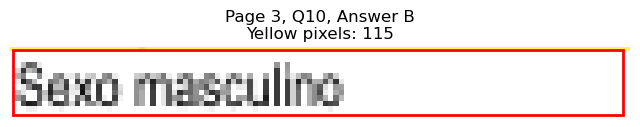

Page 3, Q10 - C: Detected box: x0=85.0, y0=723.7, x1=136.2, y1=735.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 287
Page 3, Q10, C: Yellow percentage: 0.0%


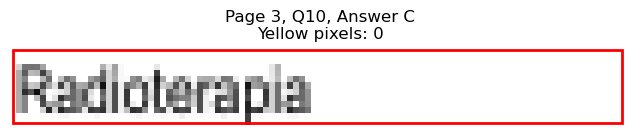

Page 3, Q10 - D: Detected box: x0=336.7, y0=699.5, x1=399.9, y1=711.7
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 338
Page 3, Q10, D: Yellow percentage: 0.0%


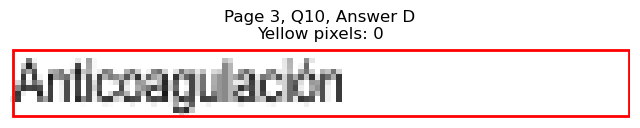

Page 3, Q10 - E: Detected box: x0=336.7, y0=711.7, x1=375.9, y1=723.8
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 209
Page 3, Q10, E: Yellow percentage: 0.0%


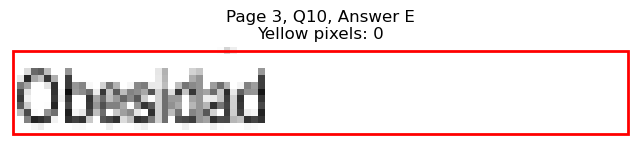


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=174.0, y1=121.3
Page 4, Q1, A: Yellow pixels: 1314
Page 4, Q1, A: Total non-white pixels: 1833
Page 4, Q1, A: Yellow percentage: 71.7%


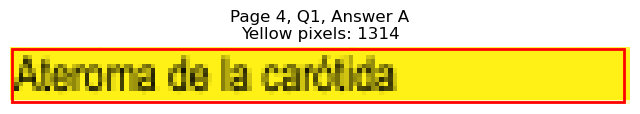

Page 4, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=154.3, y1=133.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 467
Page 4, Q1, B: Yellow percentage: 0.0%


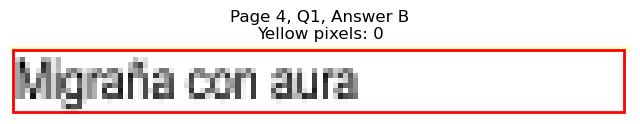

Page 4, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=242.0, y1=145.3
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 811
Page 4, Q1, C: Yellow percentage: 0.0%


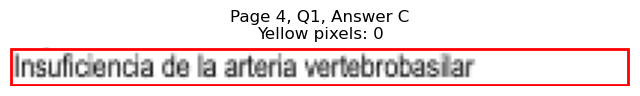

Page 4, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=428.6, y1=121.3
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 456
Page 4, Q1, D: Yellow percentage: 0.0%


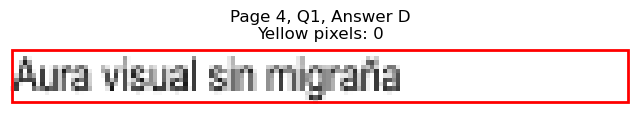

Page 4, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=445.8, y1=133.3
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 589
Page 4, Q1, E: Yellow percentage: 0.0%


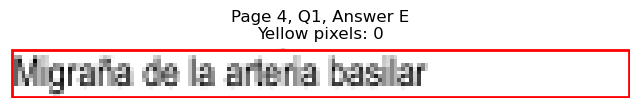


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=163.7, y1=181.5
Page 4, Q2, A: Yellow pixels: 1447
Page 4, Q2, A: Total non-white pixels: 1690
Page 4, Q2, A: Yellow percentage: 85.6%


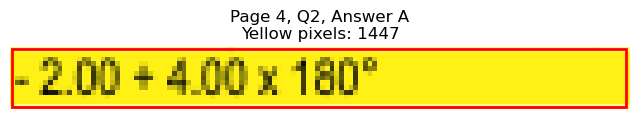

Page 4, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=158.9, y1=193.5
Page 4, Q2, B: Yellow pixels: 125
Page 4, Q2, B: Total non-white pixels: 413
Page 4, Q2, B: Yellow percentage: 30.3%


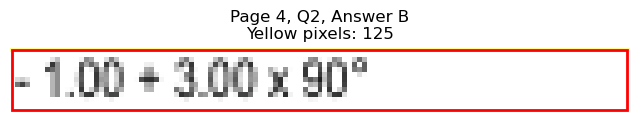

Page 4, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=165.9, y1=205.5
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 312
Page 4, Q2, C: Yellow percentage: 0.0%


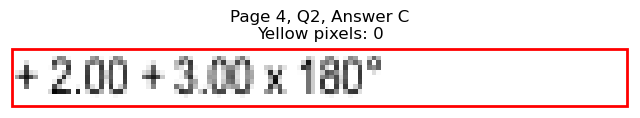

Page 4, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=410.6, y1=181.5
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 277
Page 4, Q2, D: Yellow percentage: 0.0%


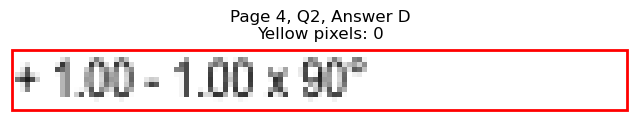

Page 4, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=417.7, y1=193.5
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 330
Page 4, Q2, E: Yellow percentage: 0.0%


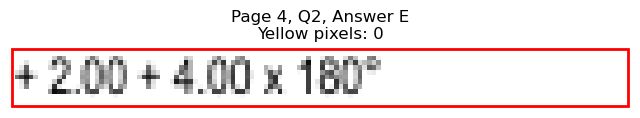


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=364.0, y1=241.8
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 1708
Page 4, Q3, A: Yellow percentage: 0.0%


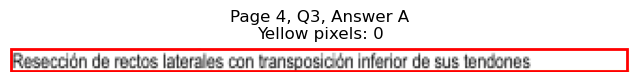

Page 4, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=365.0, y1=253.8
Page 4, Q3, B: Yellow pixels: 2877
Page 4, Q3, B: Total non-white pixels: 4303
Page 4, Q3, B: Yellow percentage: 66.9%


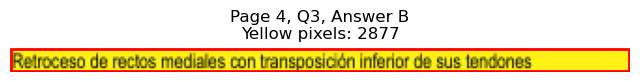

Page 4, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=333.4, y1=265.8
Page 4, Q3, C: Yellow pixels: 299
Page 4, Q3, C: Total non-white pixels: 1547
Page 4, Q3, C: Yellow percentage: 19.3%


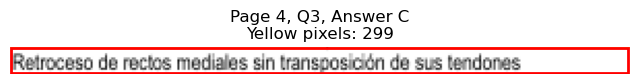

Page 4, Q3 - D: Detected box: x0=85.0, y0=265.8, x1=369.8, y1=277.9
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 1407
Page 4, Q3, D: Yellow percentage: 0.0%


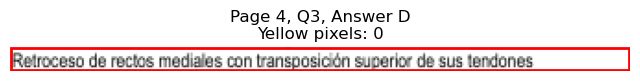

Page 4, Q3 - E: Detected box: x0=85.0, y0=277.8, x1=332.5, y1=289.9
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 1243
Page 4, Q3, E: Yellow percentage: 0.0%


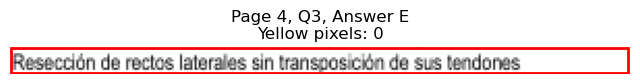


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=139.1, y1=338.2
Page 4, Q4, A: Yellow pixels: 106
Page 4, Q4, A: Total non-white pixels: 331
Page 4, Q4, A: Yellow percentage: 32.0%


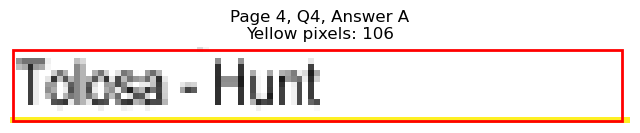

Page 4, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=130.5, y1=350.2
Page 4, Q4, B: Yellow pixels: 987
Page 4, Q4, B: Total non-white pixels: 1261
Page 4, Q4, B: Yellow percentage: 78.3%


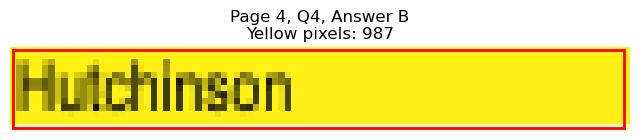

Page 4, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=113.7, y1=362.3
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 216
Page 4, Q4, C: Yellow percentage: 0.0%


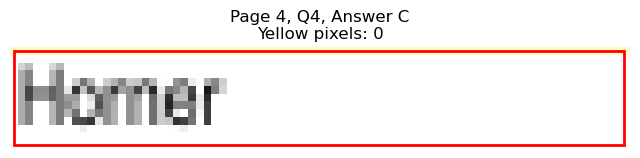

Page 4, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=400.9, y1=338.2
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 286
Page 4, Q4, D: Yellow percentage: 0.0%


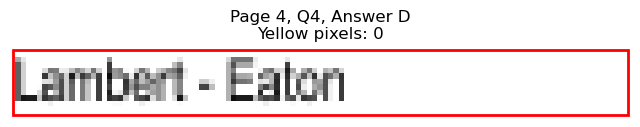

Page 4, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=362.5, y1=350.2
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 125
Page 4, Q4, E: Yellow percentage: 0.0%


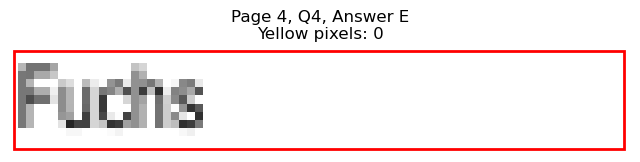


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=231.1, y1=398.4
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 727
Page 4, Q5, A: Yellow percentage: 0.0%


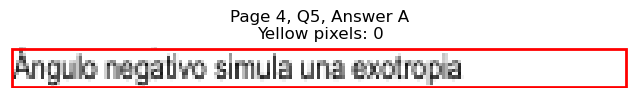

Page 4, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=229.1, y1=410.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 757
Page 4, Q5, B: Yellow percentage: 0.0%


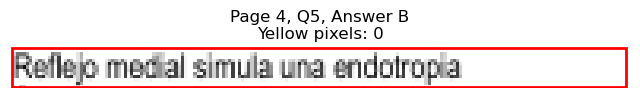

Page 4, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=232.9, y1=422.5
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 763
Page 4, Q5, C: Yellow percentage: 0.0%


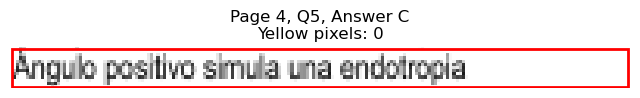

Page 4, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=473.6, y1=398.4
Page 4, Q5, D: Yellow pixels: 188
Page 4, Q5, D: Total non-white pixels: 910
Page 4, Q5, D: Yellow percentage: 20.7%


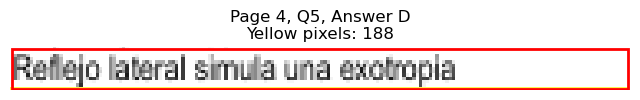

Page 4, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=478.9, y1=410.4
Page 4, Q5, E: Yellow pixels: 1854
Page 4, Q5, E: Total non-white pixels: 2470
Page 4, Q5, E: Yellow percentage: 75.1%


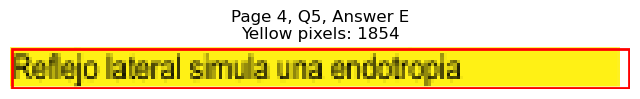


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=124.3, y1=470.7
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 181
Page 4, Q6, A: Yellow percentage: 0.0%


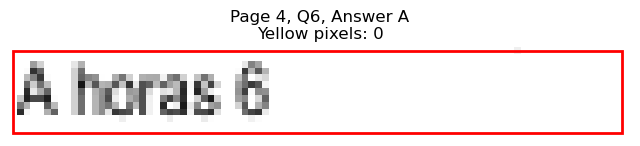

Page 4, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=213.8, y1=482.8
Page 4, Q6, B: Yellow pixels: 1605
Page 4, Q6, B: Total non-white pixels: 2340
Page 4, Q6, B: Yellow percentage: 68.6%


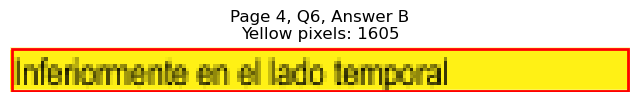

Page 4, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=219.5, y1=494.8
Page 4, Q6, C: Yellow pixels: 184
Page 4, Q6, C: Total non-white pixels: 848
Page 4, Q6, C: Yellow percentage: 21.7%


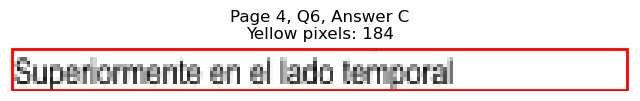

Page 4, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=458.3, y1=470.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 597
Page 4, Q6, D: Yellow percentage: 0.0%


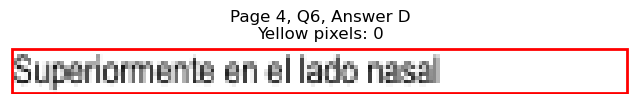

Page 4, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=380.7, y1=482.8
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 174
Page 4, Q6, E: Yellow percentage: 0.0%


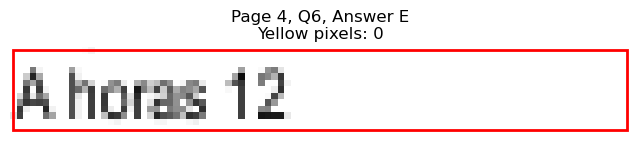


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=127.6, y1=543.0
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 231
Page 4, Q7, A: Yellow percentage: 0.0%


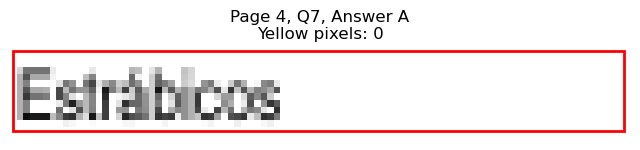

Page 4, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=125.7, y1=555.0
Page 4, Q7, B: Yellow pixels: 92
Page 4, Q7, B: Total non-white pixels: 385
Page 4, Q7, B: Yellow percentage: 23.9%


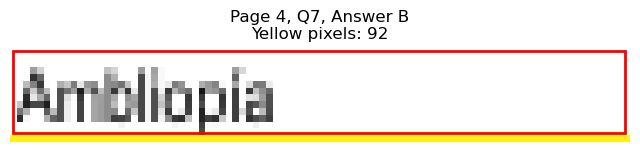

Page 4, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=130.5, y1=567.0
Page 4, Q7, C: Yellow pixels: 966
Page 4, Q7, C: Total non-white pixels: 1358
Page 4, Q7, C: Yellow percentage: 71.1%


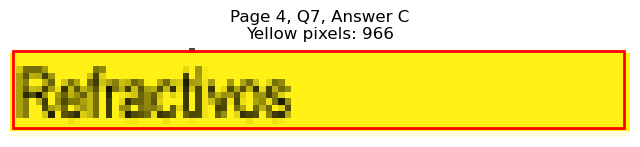

Page 4, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=378.3, y1=543.0
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 209
Page 4, Q7, D: Yellow percentage: 0.0%


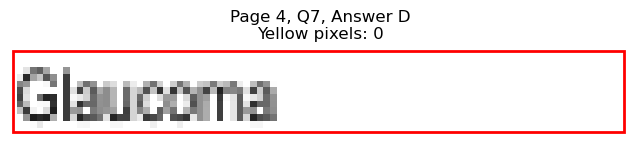

Page 4, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=440.1, y1=555.0
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 557
Page 4, Q7, E: Yellow percentage: 0.0%


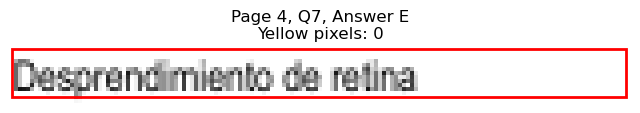


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=181.7, y1=615.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 474
Page 4, Q8, A: Yellow percentage: 0.0%


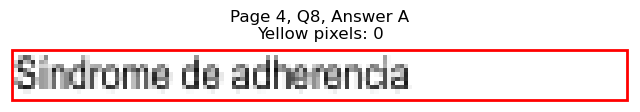

Page 4, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=159.1, y1=627.3
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 386
Page 4, Q8, B: Yellow percentage: 0.0%


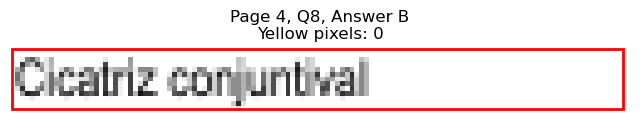

Page 4, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=192.7, y1=639.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 562
Page 4, Q8, C: Yellow percentage: 0.0%


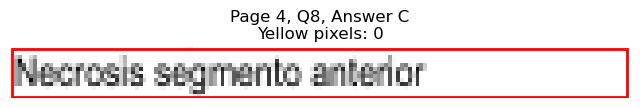

Page 4, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=426.7, y1=615.3
Page 4, Q8, D: Yellow pixels: 1305
Page 4, Q8, D: Total non-white pixels: 1833
Page 4, Q8, D: Yellow percentage: 71.2%


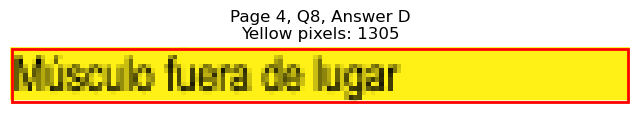

Page 4, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=402.3, y1=627.3
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 463
Page 4, Q8, E: Yellow percentage: 0.0%


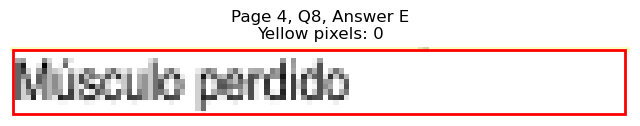


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=252.5, y1=675.5
Page 4, Q9, A: Yellow pixels: 1840
Page 4, Q9, A: Total non-white pixels: 2483
Page 4, Q9, A: Yellow percentage: 74.1%


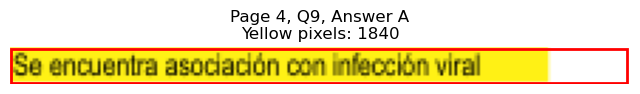

Page 4, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=258.3, y1=687.5
Page 4, Q9, B: Yellow pixels: 190
Page 4, Q9, B: Total non-white pixels: 1075
Page 4, Q9, B: Yellow percentage: 17.7%


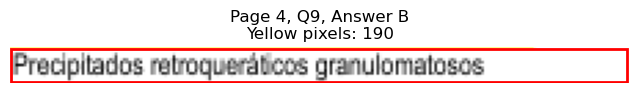

Page 4, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=257.8, y1=699.7
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 879
Page 4, Q9, C: Yellow percentage: 0.0%


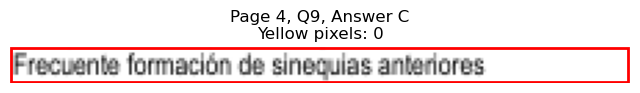

Page 4, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=508.5, y1=675.5
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 837
Page 4, Q9, D: Yellow percentage: 0.0%


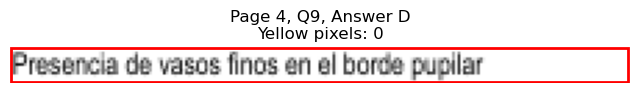

Page 4, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=481.3, y1=687.5
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 726
Page 4, Q9, E: Yellow percentage: 0.0%


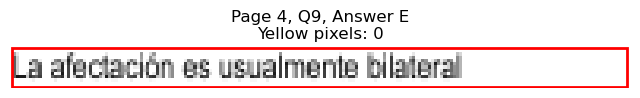


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=158.3, y1=747.9
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 370
Page 4, Q10, A: Yellow percentage: 0.0%


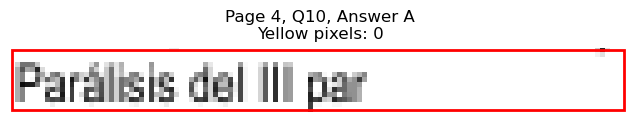

Page 4, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=183.6, y1=759.9
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 504
Page 4, Q10, B: Yellow percentage: 0.0%


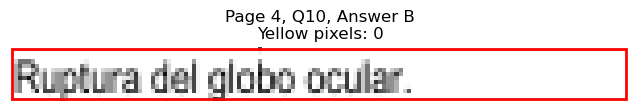

Page 4, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=159.1, y1=771.9
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 377
Page 4, Q10, C: Yellow percentage: 0.0%


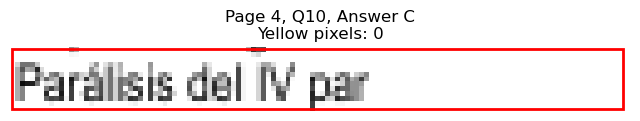

Page 4, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=489.8, y1=747.9
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 943
Page 4, Q10, D: Yellow percentage: 0.0%


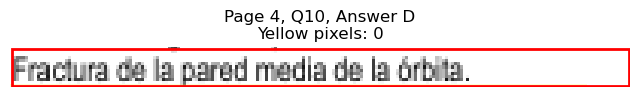

Page 4, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=439.3, y1=759.9
Page 4, Q10, E: Yellow pixels: 1400
Page 4, Q10, E: Total non-white pixels: 2002
Page 4, Q10, E: Yellow percentage: 69.9%


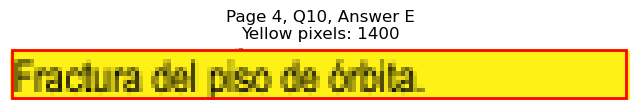


Page 4, Q10 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=97.0, y1=121.3
Page 5, Q1, A: Yellow pixels: 720
Page 5, Q1, A: Total non-white pixels: 819
Page 5, Q1, A: Yellow percentage: 87.9%


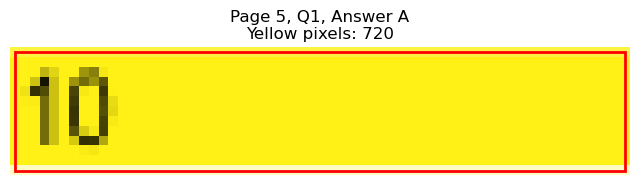

Page 5, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=97.0, y1=133.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 116
Page 5, Q1, B: Yellow percentage: 0.0%


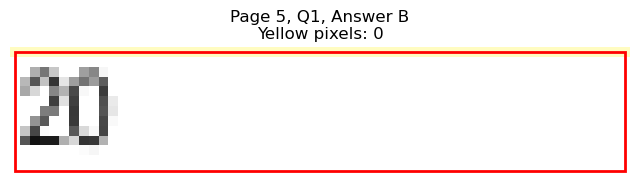

Page 5, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=97.0, y1=145.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 50
Page 5, Q1, C: Yellow percentage: 0.0%


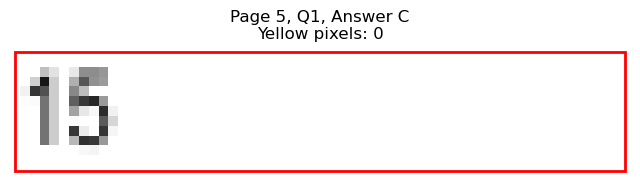

Page 5, Q1 - D: Detected box: x0=322.5, y0=109.2, x1=331.2, y1=121.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 64
Page 5, Q1, D: Yellow percentage: 0.0%


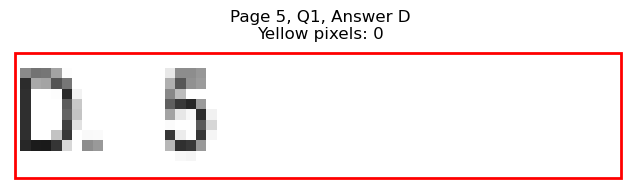

Page 5, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=348.7, y1=133.3
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 55
Page 5, Q1, E: Yellow percentage: 0.0%


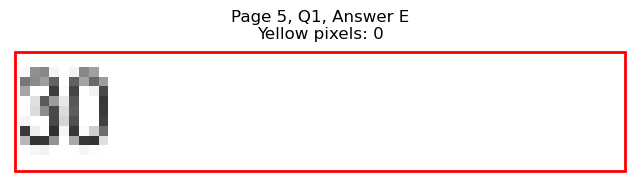


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=107.4, y1=193.5
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 80
Page 5, Q2, A: Yellow percentage: 0.0%


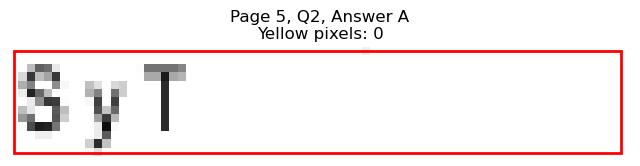

Page 5, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=109.3, y1=205.5
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 104
Page 5, Q2, B: Yellow percentage: 0.0%


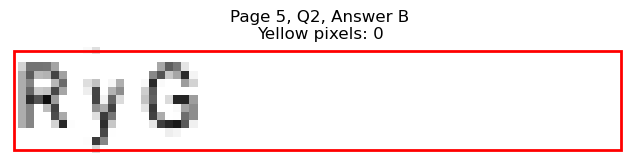

Page 5, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=109.0, y1=217.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 99
Page 5, Q2, C: Yellow percentage: 0.0%


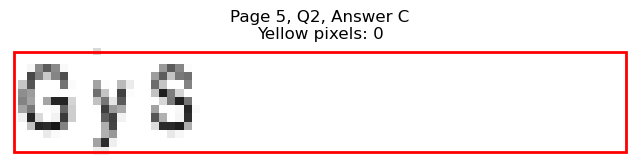

Page 5, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=360.1, y1=193.5
Page 5, Q2, D: Yellow pixels: 904
Page 5, Q2, D: Total non-white pixels: 975
Page 5, Q2, D: Yellow percentage: 92.7%


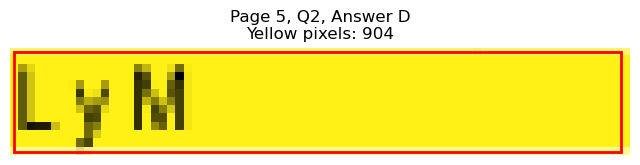

Page 5, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=359.7, y1=205.5
Page 5, Q2, E: Yellow pixels: 74
Page 5, Q2, E: Total non-white pixels: 160
Page 5, Q2, E: Yellow percentage: 46.2%


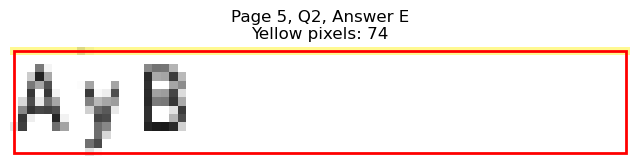


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=161.1, y1=253.8
Page 5, Q3, A: Yellow pixels: 1231
Page 5, Q3, A: Total non-white pixels: 1664
Page 5, Q3, A: Yellow percentage: 74.0%


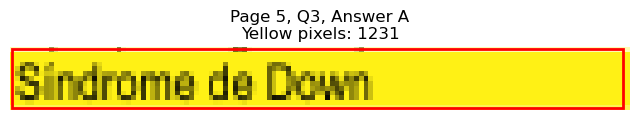

Page 5, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=157.2, y1=265.8
Page 5, Q3, B: Yellow pixels: 124
Page 5, Q3, B: Total non-white pixels: 508
Page 5, Q3, B: Yellow percentage: 24.4%


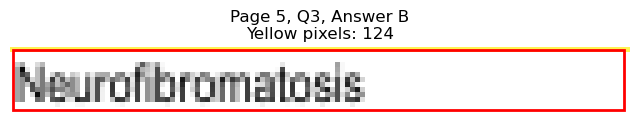

Page 5, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=165.4, y1=277.9
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 392
Page 5, Q3, C: Yellow percentage: 0.0%


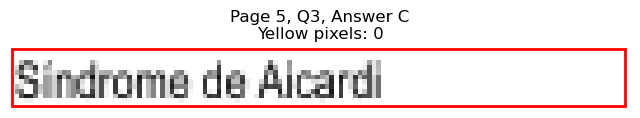

Page 5, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=381.2, y1=253.8
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 227
Page 5, Q3, D: Yellow percentage: 0.0%


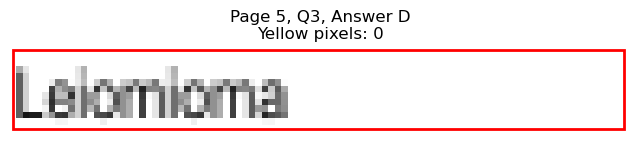

Page 5, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=417.1, y1=265.8
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 363
Page 5, Q3, E: Yellow percentage: 0.0%


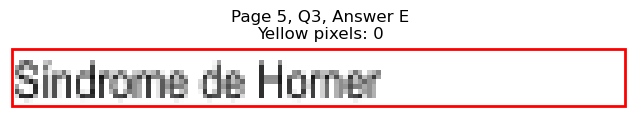


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=124.2, y1=314.0
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 219
Page 5, Q4, A: Yellow percentage: 0.0%


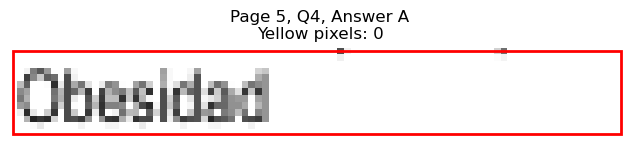

Page 5, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=164.4, y1=326.0
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 413
Page 5, Q4, B: Yellow percentage: 0.0%


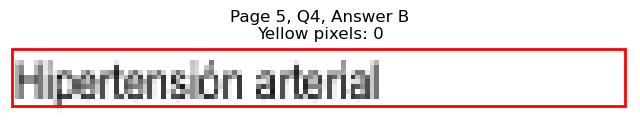

Page 5, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=144.7, y1=338.2
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 323
Page 5, Q4, C: Yellow percentage: 0.0%


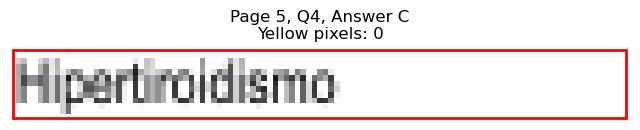

Page 5, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=404.6, y1=314.0
Page 5, Q4, D: Yellow pixels: 1119
Page 5, Q4, D: Total non-white pixels: 1547
Page 5, Q4, D: Yellow percentage: 72.3%


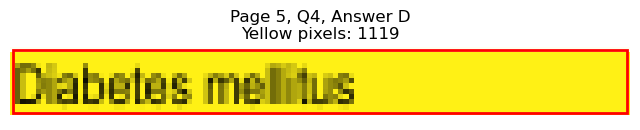

Page 5, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=395.1, y1=326.0
Page 5, Q4, E: Yellow pixels: 110
Page 5, Q4, E: Total non-white pixels: 430
Page 5, Q4, E: Yellow percentage: 25.6%


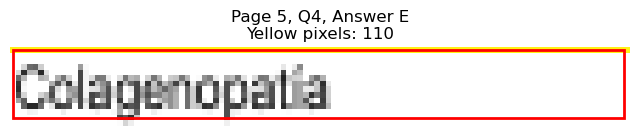


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=110.3, y1=386.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 121
Page 5, Q5, A: Yellow percentage: 0.0%


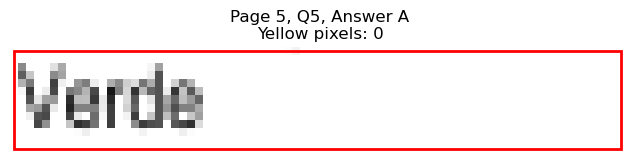

Page 5, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=104.2, y1=398.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 90
Page 5, Q5, B: Yellow percentage: 0.0%


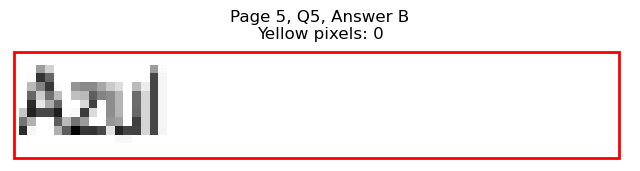

Page 5, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=113.7, y1=410.4
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 143
Page 5, Q5, C: Yellow percentage: 0.0%


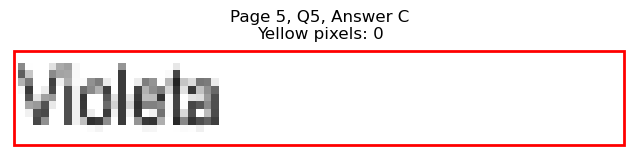

Page 5, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=356.8, y1=386.3
Page 5, Q5, D: Yellow pixels: 768
Page 5, Q5, D: Total non-white pixels: 923
Page 5, Q5, D: Yellow percentage: 83.2%


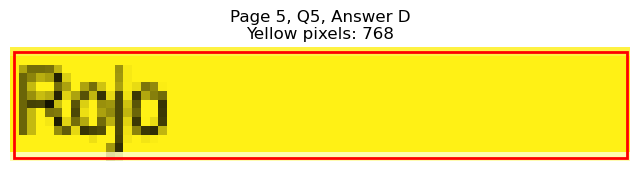

Page 5, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=370.2, y1=398.4
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 253
Page 5, Q5, E: Yellow percentage: 0.0%


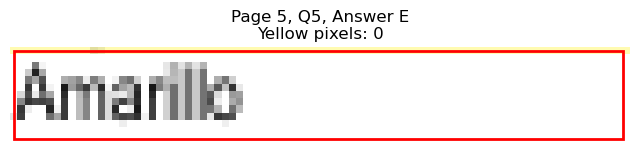


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=177.9, y1=446.5
Page 5, Q6, A: Yellow pixels: 1484
Page 5, Q6, A: Total non-white pixels: 1872
Page 5, Q6, A: Yellow percentage: 79.3%


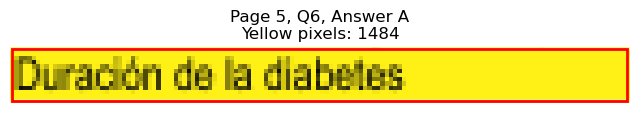

Page 5, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=185.5, y1=458.7
Page 5, Q6, B: Yellow pixels: 152
Page 5, Q6, B: Total non-white pixels: 659
Page 5, Q6, B: Yellow percentage: 23.1%


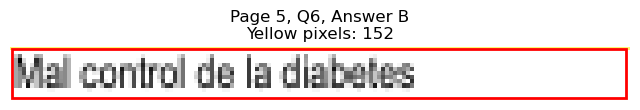

Page 5, Q6 - C: Detected box: x0=85.0, y0=458.6, x1=126.6, y1=470.7
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 203
Page 5, Q6, C: Yellow percentage: 0.0%


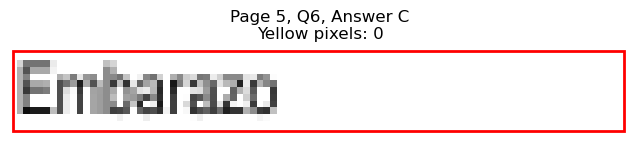

Page 5, Q6 - D: Detected box: x0=336.7, y0=434.4, x1=387.4, y1=446.5
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 260
Page 5, Q6, D: Yellow percentage: 0.0%


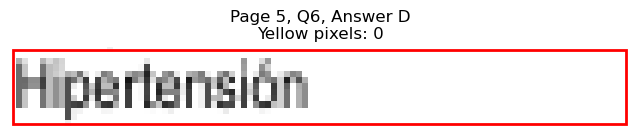

Page 5, Q6 - E: Detected box: x0=336.7, y0=446.6, x1=379.3, y1=458.7
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 240
Page 5, Q6, E: Yellow percentage: 0.0%


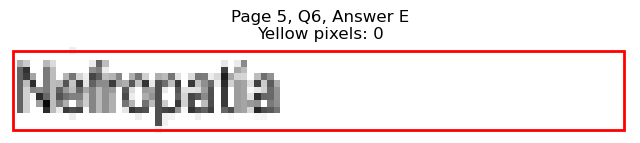


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=494.7, x1=145.8, y1=506.8
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 293
Page 5, Q7, A: Yellow percentage: 0.0%


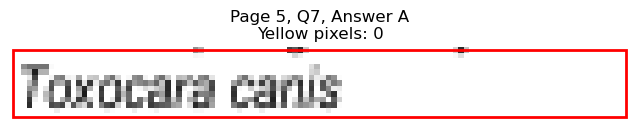

Page 5, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=149.1, y1=518.9
Page 5, Q7, B: Yellow pixels: 1113
Page 5, Q7, B: Total non-white pixels: 1508
Page 5, Q7, B: Yellow percentage: 73.8%


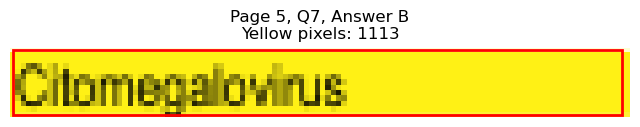

Page 5, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=123.3, y1=530.9
Page 5, Q7, C: Yellow pixels: 87
Page 5, Q7, C: Total non-white pixels: 286
Page 5, Q7, C: Yellow percentage: 30.4%


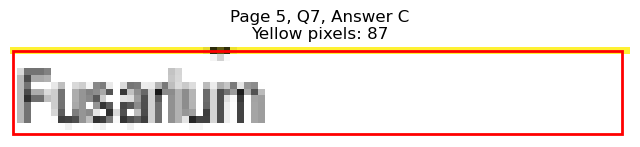

Page 5, Q7 - D: Detected box: x0=336.7, y0=494.7, x1=418.5, y1=506.8
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 429
Page 5, Q7, D: Yellow percentage: 0.0%


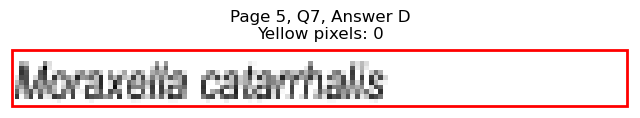

Page 5, Q7 - E: Detected box: x0=336.7, y0=506.8, x1=415.8, y1=518.9
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 379
Page 5, Q7, E: Yellow percentage: 0.0%


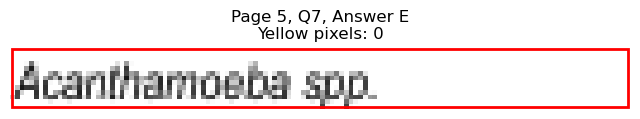


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=106.1, y1=579.2
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 89
Page 5, Q8, A: Yellow percentage: 0.0%


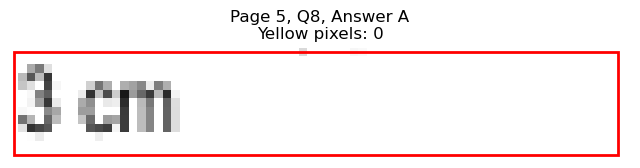

Page 5, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=106.1, y1=591.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 78
Page 5, Q8, B: Yellow percentage: 0.0%


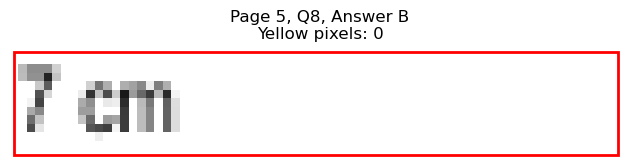

Page 5, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=106.1, y1=603.3
Page 5, Q8, C: Yellow pixels: 806
Page 5, Q8, C: Total non-white pixels: 949
Page 5, Q8, C: Yellow percentage: 84.9%


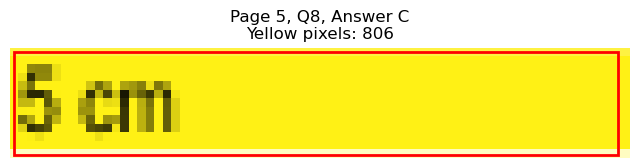

Page 5, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=357.8, y1=579.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 81
Page 5, Q8, D: Yellow percentage: 0.0%


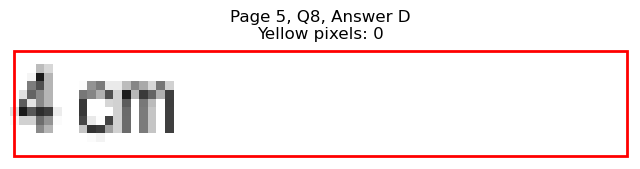

Page 5, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=357.8, y1=591.2
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 82
Page 5, Q8, E: Yellow percentage: 0.0%


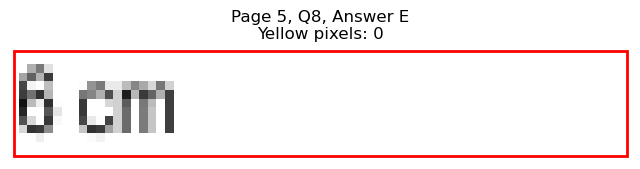


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=115.1, y1=639.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 153
Page 5, Q9, A: Yellow percentage: 0.0%


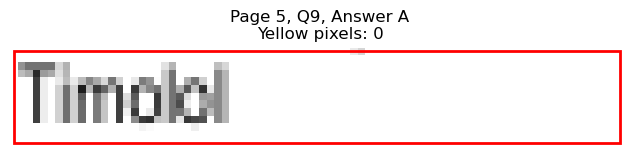

Page 5, Q9 - B: Detected box: x0=85.0, y0=639.3, x1=130.0, y1=651.4
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 234
Page 5, Q9, B: Yellow percentage: 0.0%


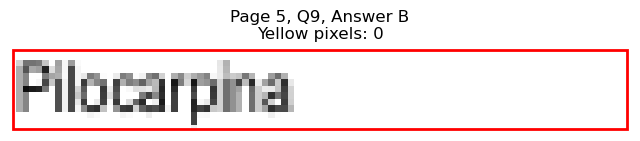

Page 5, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=132.9, y1=663.5
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 234
Page 5, Q9, C: Yellow percentage: 0.0%


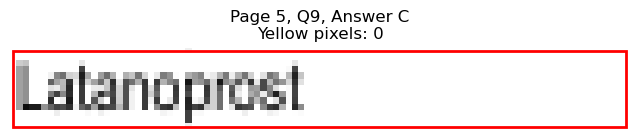

Page 5, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=384.6, y1=639.4
Page 5, Q9, D: Yellow pixels: 99
Page 5, Q9, D: Total non-white pixels: 349
Page 5, Q9, D: Yellow percentage: 28.4%


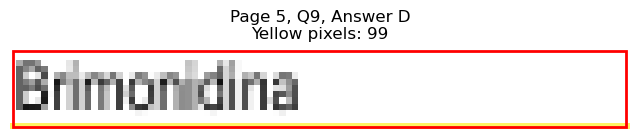

Page 5, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=387.4, y1=651.4
Page 5, Q9, E: Yellow pixels: 1118
Page 5, Q9, E: Total non-white pixels: 1326
Page 5, Q9, E: Yellow percentage: 84.3%


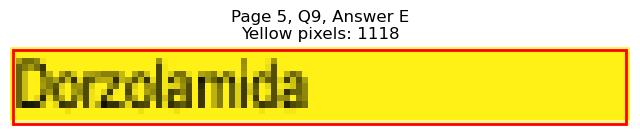


Page 5, Q9 - Selected Answer: E (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=85.0, y0=699.5, x1=130.5, y1=711.7
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 243
Page 5, Q10, A: Yellow percentage: 0.0%


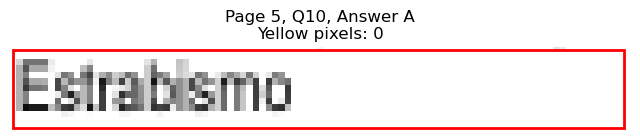

Page 5, Q10 - B: Detected box: x0=85.0, y0=711.7, x1=160.1, y1=723.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 404
Page 5, Q10, B: Yellow percentage: 0.0%


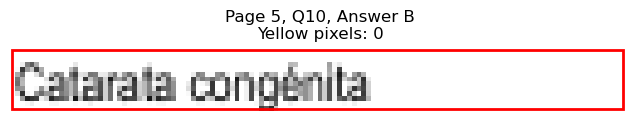

Page 5, Q10 - C: Detected box: x0=85.0, y0=723.7, x1=147.3, y1=735.8
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 352
Page 5, Q10, C: Yellow percentage: 0.0%


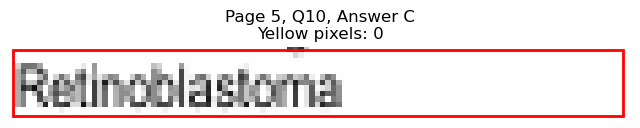

Page 5, Q10 - D: Detected box: x0=336.7, y0=699.5, x1=500.4, y1=711.7
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 869
Page 5, Q10, D: Yellow percentage: 0.0%


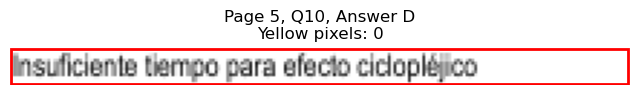

Page 5, Q10 - E: Detected box: x0=336.7, y0=711.7, x1=418.0, y1=723.8
Page 5, Q10, E: Yellow pixels: 1273
Page 5, Q10, E: Total non-white pixels: 1729
Page 5, Q10, E: Yellow percentage: 73.6%


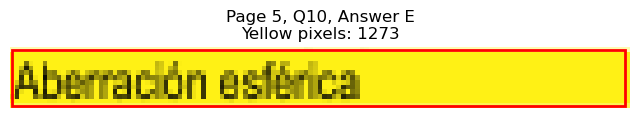


Page 5, Q10 - Selected Answer: E (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=145.8, y1=133.3
Page 6, Q1, A: Yellow pixels: 112
Page 6, Q1, A: Total non-white pixels: 431
Page 6, Q1, A: Yellow percentage: 26.0%


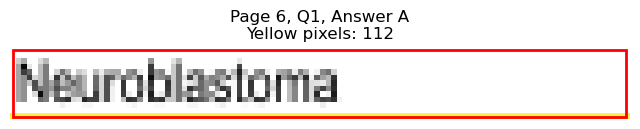

Page 6, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=180.7, y1=145.3
Page 6, Q1, B: Yellow pixels: 1374
Page 6, Q1, B: Total non-white pixels: 1911
Page 6, Q1, B: Yellow percentage: 71.9%


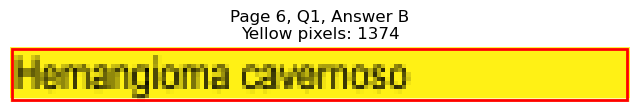

Page 6, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=160.1, y1=157.4
Page 6, Q1, C: Yellow pixels: 2
Page 6, Q1, C: Total non-white pixels: 532
Page 6, Q1, C: Yellow percentage: 0.4%


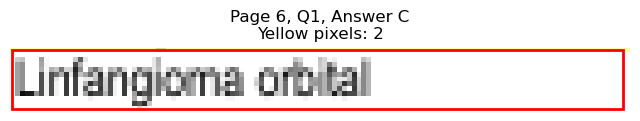

Page 6, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=397.2, y1=133.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 322
Page 6, Q1, D: Yellow percentage: 0.0%


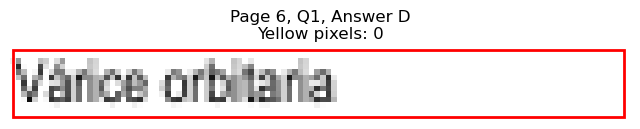

Page 6, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=411.3, y1=145.3
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 397
Page 6, Q1, E: Yellow percentage: 0.0%


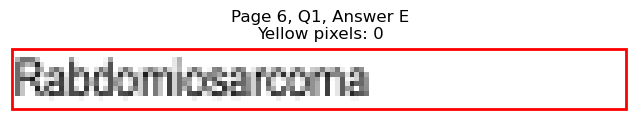


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=156.7, y1=193.5
Page 6, Q2, A: Yellow pixels: 123
Page 6, Q2, A: Total non-white pixels: 494
Page 6, Q2, A: Yellow percentage: 24.9%


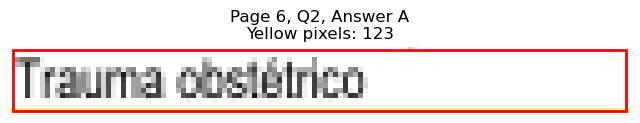

Page 6, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=210.9, y1=205.5
Page 6, Q2, B: Yellow pixels: 1790
Page 6, Q2, B: Total non-white pixels: 2301
Page 6, Q2, B: Yellow percentage: 77.8%


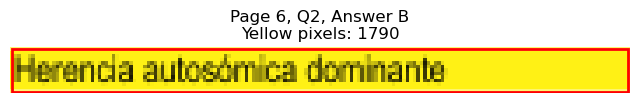

Page 6, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=176.9, y1=217.7
Page 6, Q2, C: Yellow pixels: 143
Page 6, Q2, C: Total non-white pixels: 610
Page 6, Q2, C: Yellow percentage: 23.4%


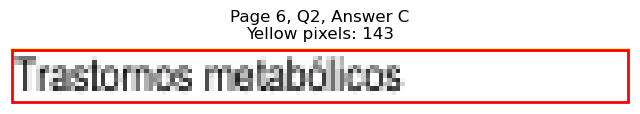

Page 6, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=436.3, y1=193.5
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 522
Page 6, Q2, D: Yellow percentage: 0.0%


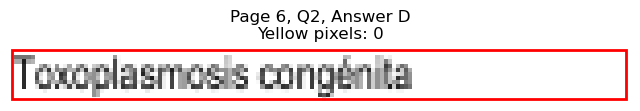

Page 6, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=490.3, y1=205.5
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 803
Page 6, Q2, E: Yellow percentage: 0.0%


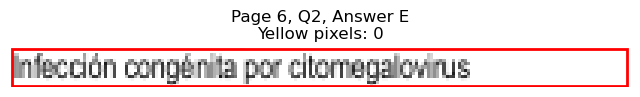


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=156.3, y1=253.8
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 355
Page 6, Q3, A: Yellow percentage: 0.0%


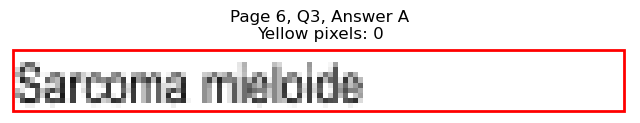

Page 6, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=233.8, y1=265.8
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 775
Page 6, Q3, B: Yellow percentage: 0.0%


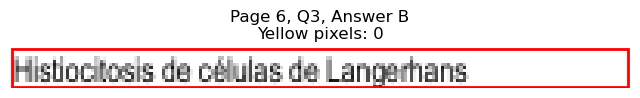

Page 6, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=194.1, y1=277.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 552
Page 6, Q3, C: Yellow percentage: 0.0%


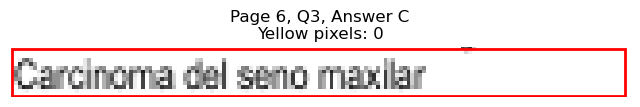

Page 6, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=433.4, y1=253.8
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 655
Page 6, Q3, D: Yellow percentage: 0.0%


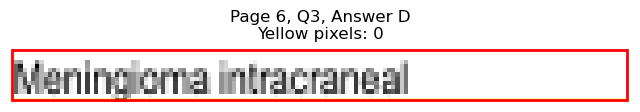

Page 6, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=397.5, y1=265.8
Page 6, Q3, E: Yellow pixels: 1077
Page 6, Q3, E: Total non-white pixels: 1456
Page 6, Q3, E: Yellow percentage: 74.0%


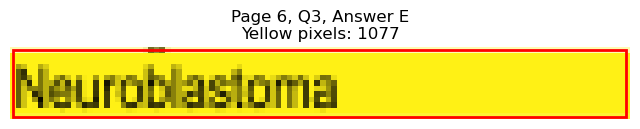


Page 6, Q3 - Selected Answer: E (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=137.7, y1=314.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 287
Page 6, Q4, A: Yellow percentage: 0.0%


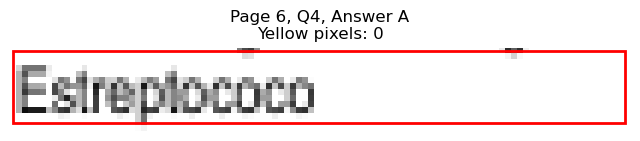

Page 6, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=126.6, y1=326.0
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 195
Page 6, Q4, B: Yellow percentage: 0.0%


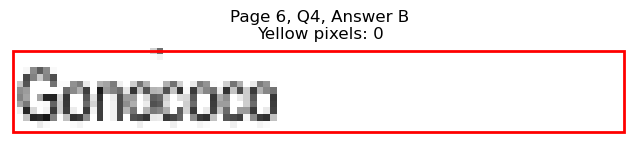

Page 6, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=128.1, y1=338.2
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 239
Page 6, Q4, C: Yellow percentage: 0.0%


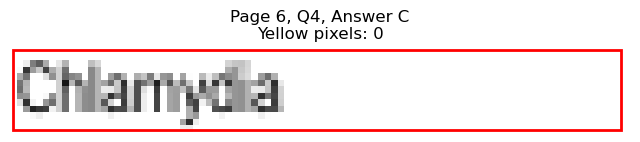

Page 6, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=392.2, y1=314.0
Page 6, Q4, D: Yellow pixels: 107
Page 6, Q4, D: Total non-white pixels: 491
Page 6, Q4, D: Yellow percentage: 21.8%


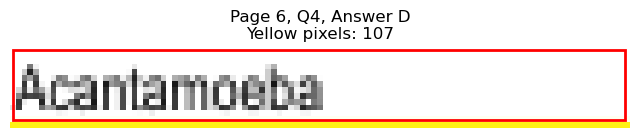

Page 6, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=385.5, y1=326.0
Page 6, Q4, E: Yellow pixels: 975
Page 6, Q4, E: Total non-white pixels: 1400
Page 6, Q4, E: Yellow percentage: 69.6%


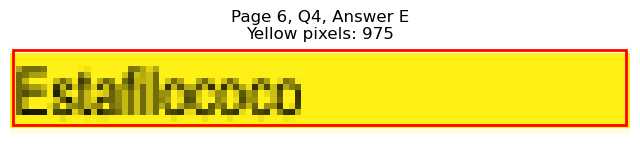


Page 6, Q4 - Selected Answer: E (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=131.9, y1=374.3
Page 6, Q5, A: Yellow pixels: 98
Page 6, Q5, A: Total non-white pixels: 335
Page 6, Q5, A: Yellow percentage: 29.3%


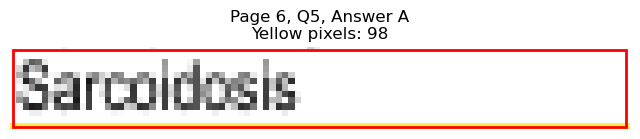

Page 6, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=166.3, y1=386.3
Page 6, Q5, B: Yellow pixels: 1259
Page 6, Q5, B: Total non-white pixels: 1729
Page 6, Q5, B: Yellow percentage: 72.8%


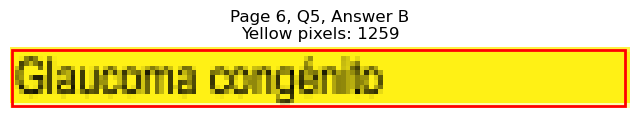

Page 6, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=136.2, y1=398.4
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 363
Page 6, Q5, C: Yellow percentage: 0.0%


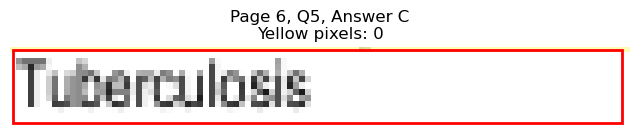

Page 6, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=408.4, y1=374.3
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 347
Page 6, Q5, D: Yellow percentage: 0.0%


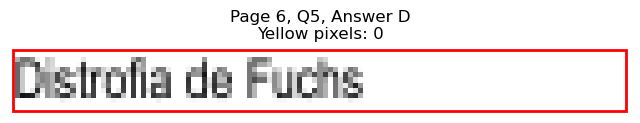

Page 6, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=396.6, y1=386.3
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 305
Page 6, Q5, E: Yellow percentage: 0.0%


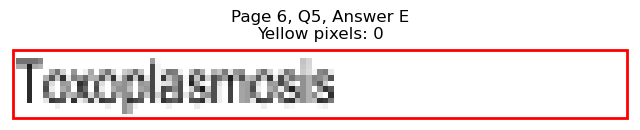


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=422.4, x1=102.7, y1=434.5
Page 6, Q6, A: Yellow pixels: 69
Page 6, Q6, A: Total non-white pixels: 155
Page 6, Q6, A: Yellow percentage: 44.5%


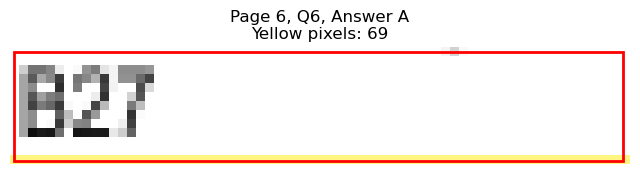

Page 6, Q6 - B: Detected box: x0=85.0, y0=434.4, x1=104.5, y1=446.5
Page 6, Q6, B: Yellow pixels: 844
Page 6, Q6, B: Total non-white pixels: 923
Page 6, Q6, B: Yellow percentage: 91.4%


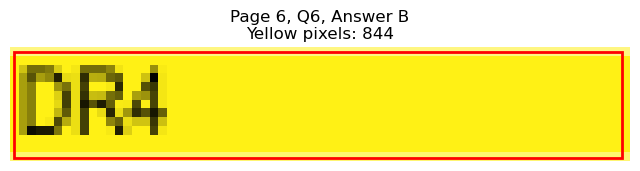

Page 6, Q6 - C: Detected box: x0=85.0, y0=446.6, x1=102.7, y1=458.7
Page 6, Q6, C: Yellow pixels: 69
Page 6, Q6, C: Total non-white pixels: 151
Page 6, Q6, C: Yellow percentage: 45.7%


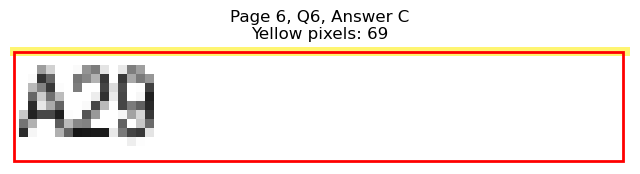

Page 6, Q6 - D: Detected box: x0=336.7, y0=422.4, x1=354.4, y1=434.5
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 83
Page 6, Q6, D: Yellow percentage: 0.0%


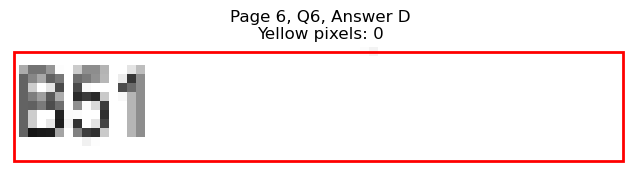

Page 6, Q6 - E: Detected box: x0=336.7, y0=434.4, x1=354.4, y1=446.5
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 80
Page 6, Q6, E: Yellow percentage: 0.0%


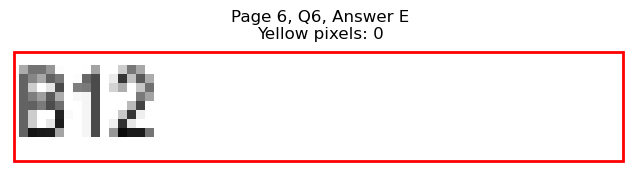


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=482.7, x1=137.7, y1=494.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 269
Page 6, Q7, A: Yellow percentage: 0.0%


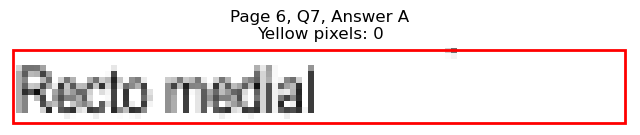

Page 6, Q7 - B: Detected box: x0=85.0, y0=494.7, x1=143.4, y1=506.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 288
Page 6, Q7, B: Yellow percentage: 0.0%


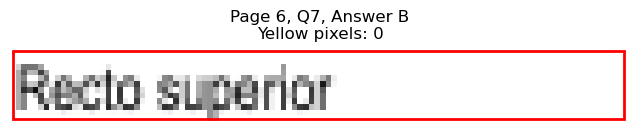

Page 6, Q7 - C: Detected box: x0=85.0, y0=506.8, x1=138.6, y1=518.9
Page 6, Q7, C: Yellow pixels: 1040
Page 6, Q7, C: Total non-white pixels: 1365
Page 6, Q7, C: Yellow percentage: 76.2%


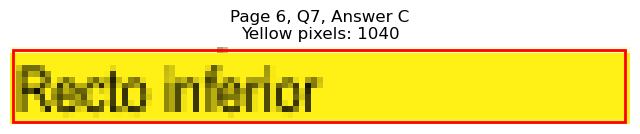

Page 6, Q7 - D: Detected box: x0=336.7, y0=482.7, x1=397.0, y1=494.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 318
Page 6, Q7, D: Yellow percentage: 0.0%


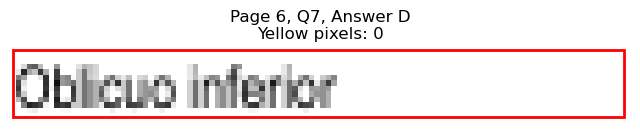

Page 6, Q7 - E: Detected box: x0=336.7, y0=494.7, x1=401.8, y1=506.8
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 326
Page 6, Q7, E: Yellow percentage: 0.0%


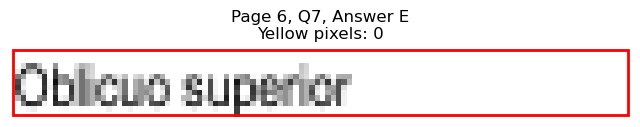


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=542.9, x1=162.0, y1=555.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 388
Page 6, Q8, A: Yellow percentage: 0.0%


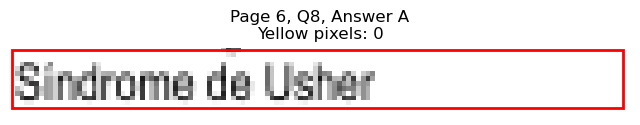

Page 6, Q8 - B: Detected box: x0=85.0, y0=554.9, x1=161.1, y1=567.0
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 379
Page 6, Q8, B: Yellow percentage: 0.0%


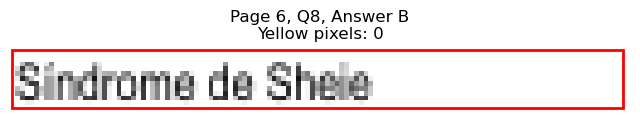

Page 6, Q8 - C: Detected box: x0=85.0, y0=567.1, x1=201.3, y1=579.2
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 646
Page 6, Q8, C: Yellow percentage: 0.0%


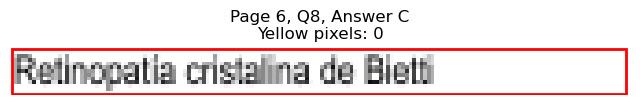

Page 6, Q8 - D: Detected box: x0=336.7, y0=542.9, x1=430.0, y1=555.0
Page 6, Q8, D: Yellow pixels: 1337
Page 6, Q8, D: Total non-white pixels: 1885
Page 6, Q8, D: Yellow percentage: 70.9%


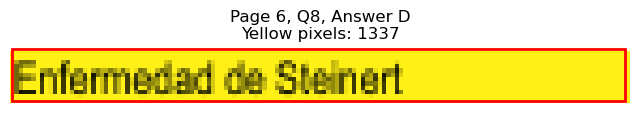

Page 6, Q8 - E: Detected box: x0=336.7, y0=554.9, x1=410.8, y1=567.0
Page 6, Q8, E: Yellow pixels: 125
Page 6, Q8, E: Total non-white pixels: 501
Page 6, Q8, E: Yellow percentage: 25.0%


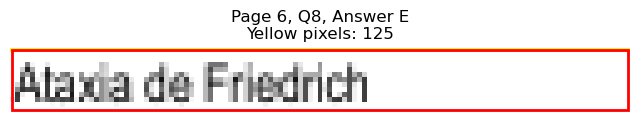


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=70.8, y0=603.2, x1=79.0, y1=615.3
Page 6, Q9, A: Yellow pixels: 670
Page 6, Q9, A: Total non-white pixels: 767
Page 6, Q9, A: Yellow percentage: 87.4%


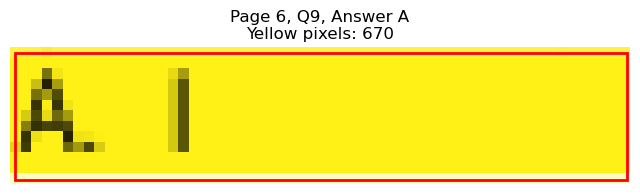

Page 6, Q9 - B: Detected box: x0=70.8, y0=615.2, x1=79.0, y1=627.3
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 130
Page 6, Q9, B: Yellow percentage: 0.0%


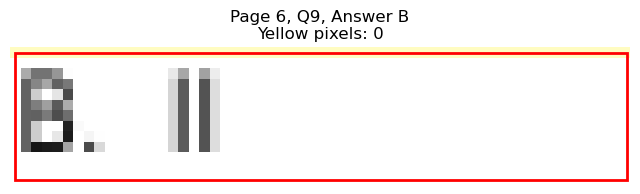

Page 6, Q9 - C: Detected box: x0=85.0, y0=627.3, x1=94.6, y1=639.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 48
Page 6, Q9, C: Yellow percentage: 0.0%


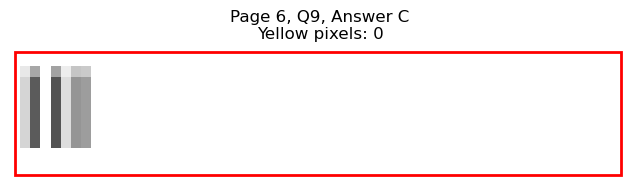

Page 6, Q9 - D: Detected box: x0=336.7, y0=603.2, x1=347.2, y1=615.3
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 44
Page 6, Q9, D: Yellow percentage: 0.0%


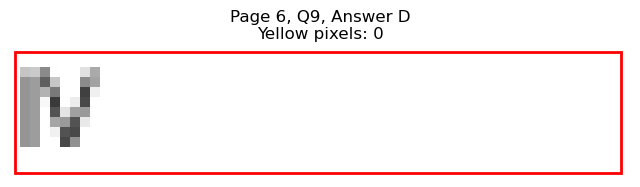

Page 6, Q9 - E: Detected box: x0=322.5, y0=615.2, x1=330.7, y1=627.3
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 58
Page 6, Q9, E: Yellow percentage: 0.0%


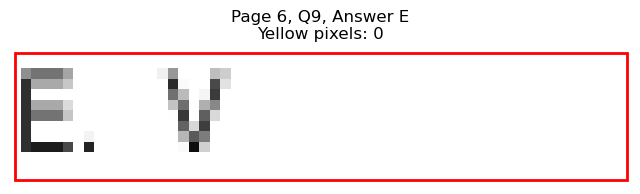


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=85.0, y0=663.4, x1=142.0, y1=675.5
Page 6, Q10, A: Yellow pixels: 1167
Page 6, Q10, A: Total non-white pixels: 1404
Page 6, Q10, A: Yellow percentage: 83.1%


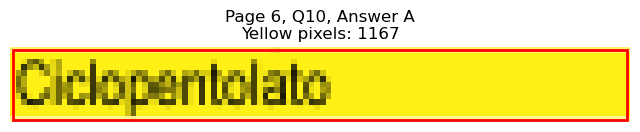

Page 6, Q10 - B: Detected box: x0=85.0, y0=675.4, x1=119.4, y1=687.5
Page 6, Q10, B: Yellow pixels: 86
Page 6, Q10, B: Total non-white pixels: 266
Page 6, Q10, B: Yellow percentage: 32.3%


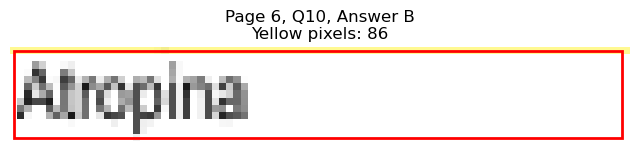

Page 6, Q10 - C: Detected box: x0=85.0, y0=687.5, x1=127.6, y1=699.7
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 235
Page 6, Q10, C: Yellow percentage: 0.0%


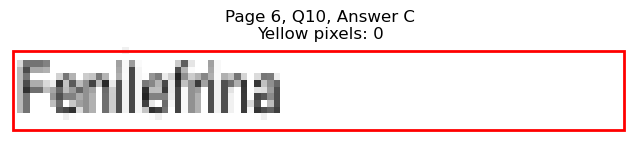

Page 6, Q10 - D: Detected box: x0=336.7, y0=663.4, x1=386.5, y1=675.5
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 238
Page 6, Q10, D: Yellow percentage: 0.0%


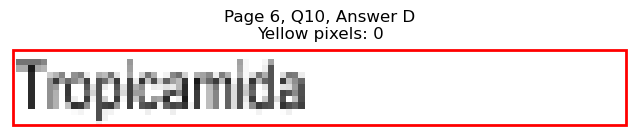

Page 6, Q10 - E: Detected box: x0=336.7, y0=675.4, x1=389.0, y1=687.5
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 260
Page 6, Q10, E: Yellow percentage: 0.0%


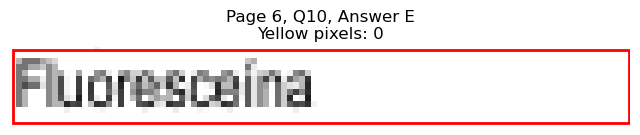


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=85.0, y0=723.7, x1=147.9, y1=735.8
Page 6, Q11, A: Yellow pixels: 1097
Page 6, Q11, A: Total non-white pixels: 1482
Page 6, Q11, A: Yellow percentage: 74.0%


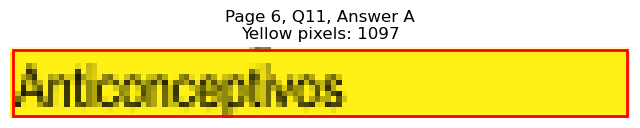

Page 6, Q11 - B: Detected box: x0=85.0, y0=735.8, x1=152.9, y1=747.9
Page 6, Q11, B: Yellow pixels: 117
Page 6, Q11, B: Total non-white pixels: 469
Page 6, Q11, B: Yellow percentage: 24.9%


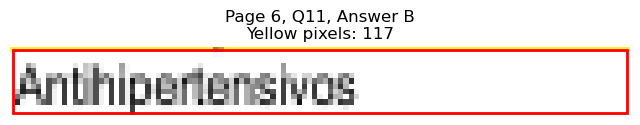

Page 6, Q11 - C: Detected box: x0=85.0, y0=747.8, x1=148.7, y1=759.9
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 328
Page 6, Q11, C: Yellow percentage: 0.0%


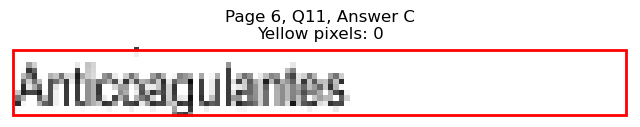

Page 6, Q11 - D: Detected box: x0=336.7, y0=723.7, x1=401.8, y1=735.8
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 354
Page 6, Q11, D: Yellow percentage: 0.0%


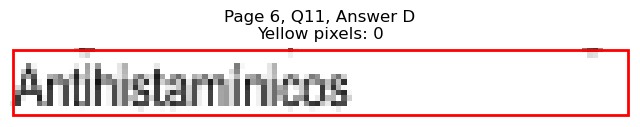

Page 6, Q11 - E: Detected box: x0=336.7, y0=735.8, x1=392.7, y1=747.9
Page 6, Q11, E: Yellow pixels: 0
Page 6, Q11, E: Total non-white pixels: 318
Page 6, Q11, E: Yellow percentage: 0.0%


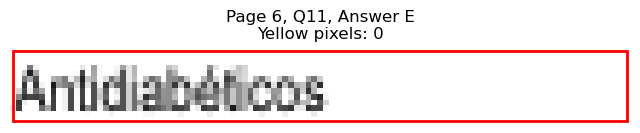


Page 6, Q11 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=150.1, y1=109.2
Page 7, Q1, A: Yellow pixels: 1113
Page 7, Q1, A: Total non-white pixels: 1521
Page 7, Q1, A: Yellow percentage: 73.2%


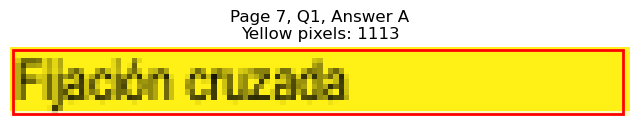

Page 7, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=201.9, y1=121.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 724
Page 7, Q1, B: Yellow percentage: 0.0%


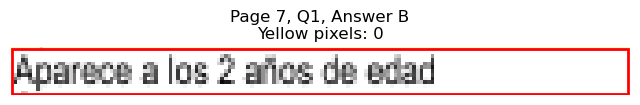

Page 7, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=255.4, y1=133.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 859
Page 7, Q1, C: Yellow percentage: 0.0%


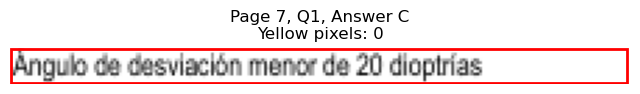

Page 7, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=382.3, y1=109.2
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 228
Page 7, Q1, D: Yellow percentage: 0.0%


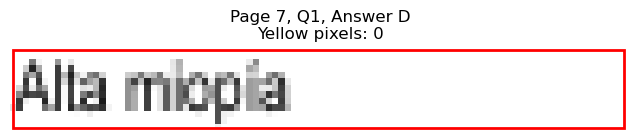

Page 7, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=498.9, y1=121.3
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 766
Page 7, Q1, E: Yellow percentage: 0.0%


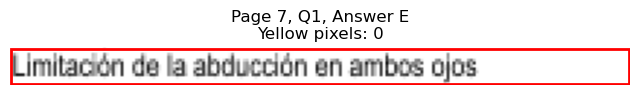


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=159.1, y1=181.5
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 398
Page 7, Q2, A: Yellow percentage: 0.0%


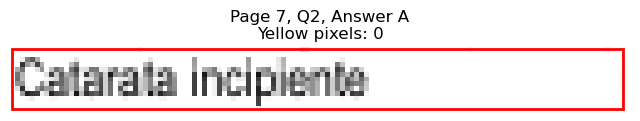

Page 7, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=153.9, y1=193.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 354
Page 7, Q2, B: Yellow percentage: 0.0%


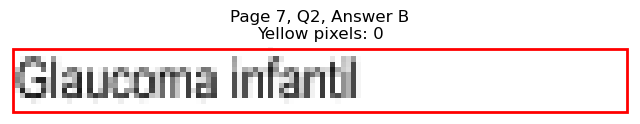

Page 7, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=144.9, y1=205.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 310
Page 7, Q2, C: Yellow percentage: 0.0%


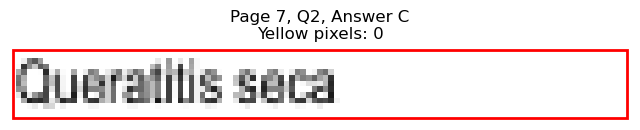

Page 7, Q2 - D: Detected box: x0=336.7, y0=97.1, x1=382.3, y1=109.2
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 228
Page 7, Q2, D: Yellow percentage: 0.0%


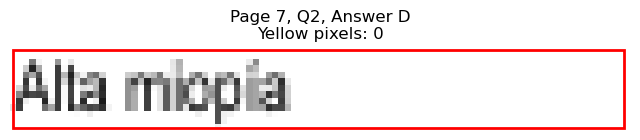

Page 7, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=440.6, y1=193.5
Page 7, Q2, E: Yellow pixels: 155
Page 7, Q2, E: Total non-white pixels: 694
Page 7, Q2, E: Yellow percentage: 22.3%


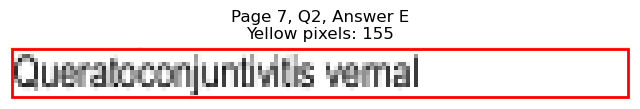


Page 7, Q2 - Selected Answer: E (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=253.0, y1=277.9
Page 7, Q3, A: Yellow pixels: 1599
Page 7, Q3, A: Total non-white pixels: 2483
Page 7, Q3, A: Yellow percentage: 64.4%


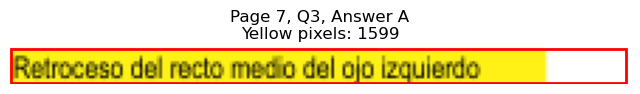

Page 7, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=254.0, y1=289.9
Page 7, Q3, B: Yellow pixels: 187
Page 7, Q3, B: Total non-white pixels: 1023
Page 7, Q3, B: Yellow percentage: 18.3%


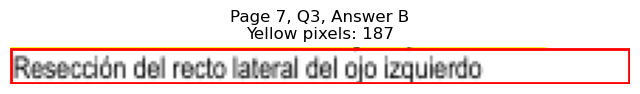

Page 7, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=246.3, y1=302.0
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 797
Page 7, Q3, C: Yellow percentage: 0.0%


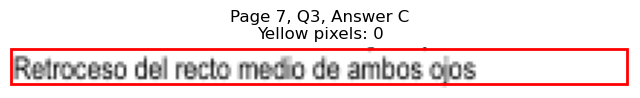

Page 7, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=504.7, y1=277.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 838
Page 7, Q3, D: Yellow percentage: 0.0%


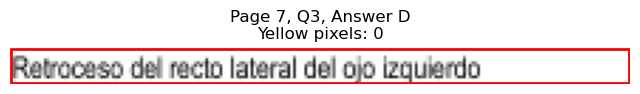

Page 7, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=505.7, y1=289.9
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 854
Page 7, Q3, E: Yellow percentage: 0.0%


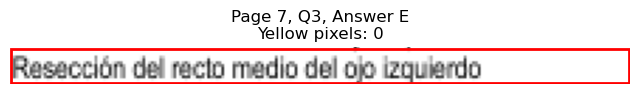


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=109.5, y1=350.2
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 125
Page 7, Q4, A: Yellow percentage: 0.0%


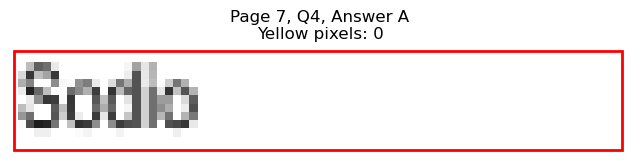

Page 7, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=107.9, y1=362.3
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 110
Page 7, Q4, B: Yellow percentage: 0.0%


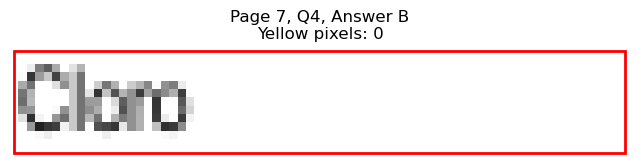

Page 7, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=133.3, y1=374.3
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 256
Page 7, Q4, C: Yellow percentage: 0.0%


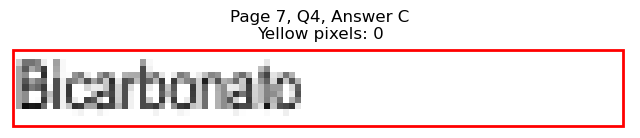

Page 7, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=370.6, y1=350.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 161
Page 7, Q4, D: Yellow percentage: 0.0%


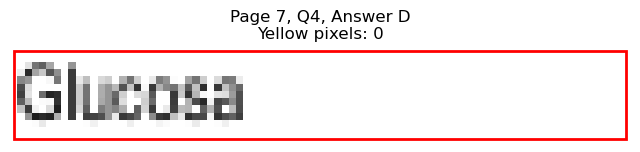

Page 7, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=377.8, y1=362.3
Page 7, Q4, E: Yellow pixels: 948
Page 7, Q4, E: Total non-white pixels: 1196
Page 7, Q4, E: Yellow percentage: 79.3%


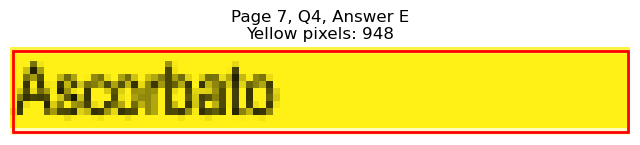


Page 7, Q4 - Selected Answer: E (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=284.1, y1=410.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 987
Page 7, Q5, A: Yellow percentage: 0.0%


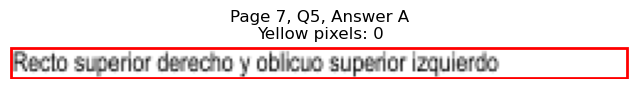

Page 7, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=277.9, y1=422.5
Page 7, Q5, B: Yellow pixels: 2425
Page 7, Q5, B: Total non-white pixels: 3172
Page 7, Q5, B: Yellow percentage: 76.5%


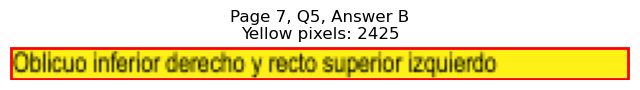

Page 7, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=269.8, y1=434.5
Page 7, Q5, C: Yellow pixels: 236
Page 7, Q5, C: Total non-white pixels: 1130
Page 7, Q5, C: Yellow percentage: 20.9%


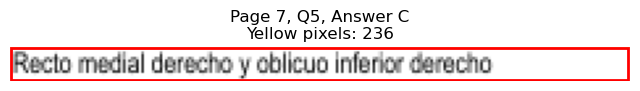

Page 7, Q5 - D: Detected box: x0=85.0, y0=434.4, x1=282.7, y1=446.5
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 943
Page 7, Q5, D: Yellow percentage: 0.0%


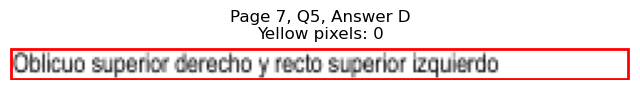

Page 7, Q5 - E: Detected box: x0=85.0, y0=446.6, x1=273.1, y1=458.7
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 930
Page 7, Q5, E: Yellow percentage: 0.0%


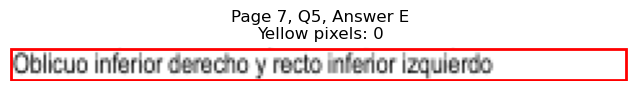


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=105.6, y1=506.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 88
Page 7, Q6, A: Yellow percentage: 0.0%


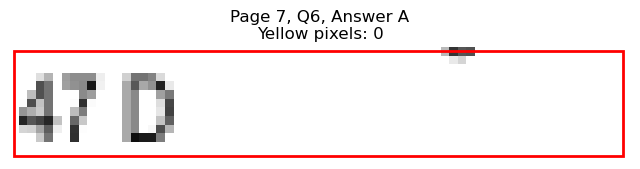

Page 7, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=105.6, y1=518.9
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 94
Page 7, Q6, B: Yellow percentage: 0.0%


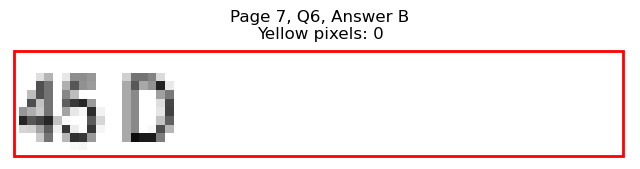

Page 7, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=105.6, y1=530.9
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 98
Page 7, Q6, C: Yellow percentage: 0.0%


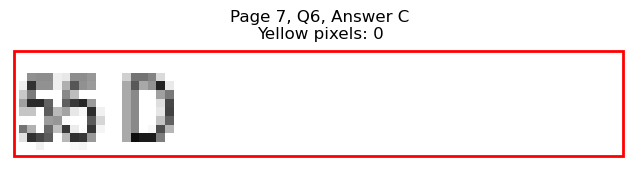

Page 7, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=357.3, y1=506.8
Page 7, Q6, D: Yellow pixels: 787
Page 7, Q6, D: Total non-white pixels: 936
Page 7, Q6, D: Yellow percentage: 84.1%


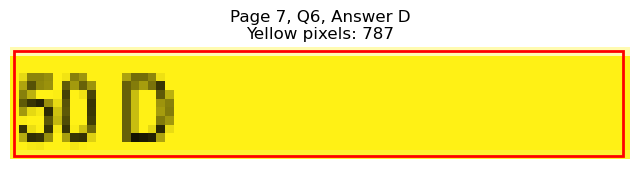

Page 7, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=357.3, y1=518.9
Page 7, Q6, E: Yellow pixels: 72
Page 7, Q6, E: Total non-white pixels: 160
Page 7, Q6, E: Yellow percentage: 45.0%


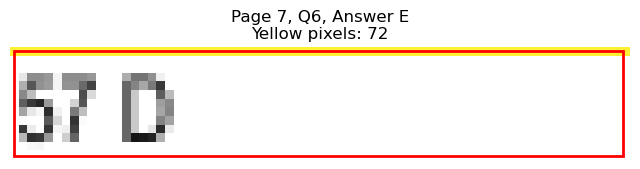


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=567.1, x1=184.1, y1=579.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 532
Page 7, Q7, A: Yellow percentage: 0.0%


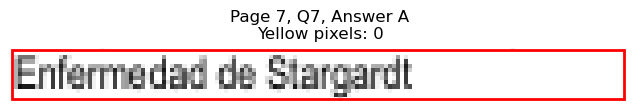

Page 7, Q7 - B: Detected box: x0=85.0, y0=579.1, x1=161.5, y1=591.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 375
Page 7, Q7, B: Yellow percentage: 0.0%


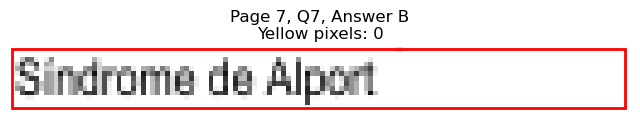

Page 7, Q7 - C: Detected box: x0=85.0, y0=591.2, x1=175.9, y1=603.3
Page 7, Q7, C: Yellow pixels: 1329
Page 7, Q7, C: Total non-white pixels: 1846
Page 7, Q7, C: Yellow percentage: 72.0%


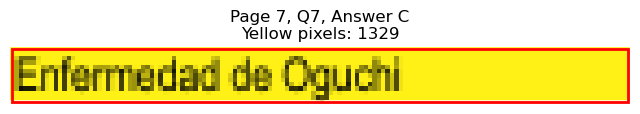

Page 7, Q7 - D: Detected box: x0=336.7, y0=567.1, x1=443.0, y1=579.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 555
Page 7, Q7, D: Yellow percentage: 0.0%


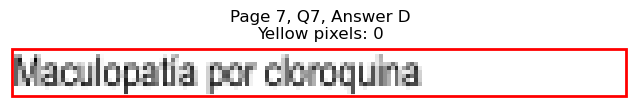

Page 7, Q7 - E: Detected box: x0=336.7, y0=579.1, x1=445.3, y1=591.2
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 561
Page 7, Q7, E: Yellow percentage: 0.0%


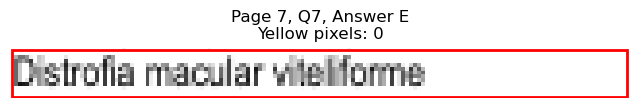


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=142.5, y1=663.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 288
Page 7, Q8, A: Yellow percentage: 0.0%


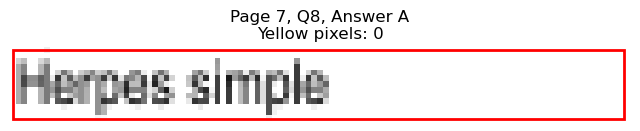

Page 7, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=215.2, y1=675.5
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 635
Page 7, Q8, B: Yellow percentage: 0.0%


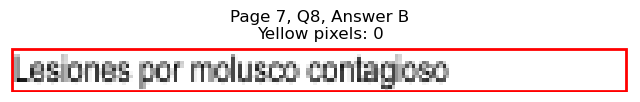

Page 7, Q8 - C: Detected box: x0=85.0, y0=675.4, x1=179.3, y1=687.5
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 518
Page 7, Q8, C: Yellow percentage: 0.0%


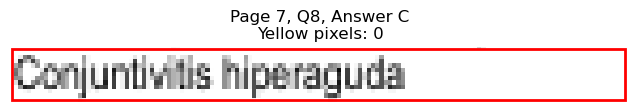

Page 7, Q8 - D: Detected box: x0=336.7, y0=651.4, x1=399.0, y1=663.5
Page 7, Q8, D: Yellow pixels: 113
Page 7, Q8, D: Total non-white pixels: 433
Page 7, Q8, D: Yellow percentage: 26.1%


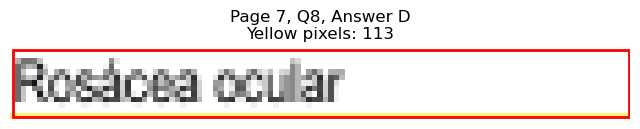

Page 7, Q8 - E: Detected box: x0=336.7, y0=663.4, x1=429.6, y1=675.5
Page 7, Q8, E: Yellow pixels: 1484
Page 7, Q8, E: Total non-white pixels: 1872
Page 7, Q8, E: Yellow percentage: 79.3%


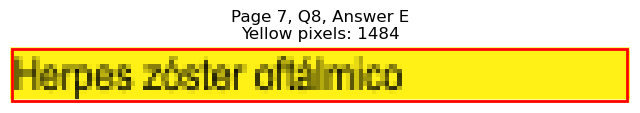


Page 7, Q8 - Selected Answer: E (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=711.7, x1=124.7, y1=723.8
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 180
Page 7, Q9, A: Yellow percentage: 0.0%


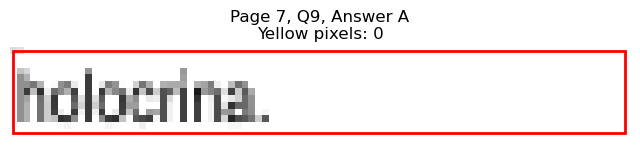

Page 7, Q9 - B: Detected box: x0=85.0, y0=723.7, x1=122.3, y1=735.8
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 187
Page 7, Q9, B: Yellow percentage: 0.0%


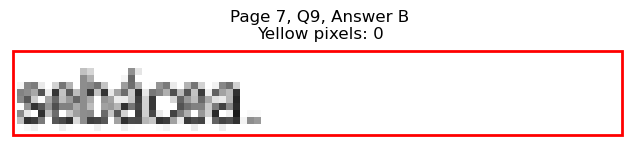

Page 7, Q9 - C: Detected box: x0=85.0, y0=735.8, x1=126.6, y1=747.9
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 201
Page 7, Q9, C: Yellow percentage: 0.0%


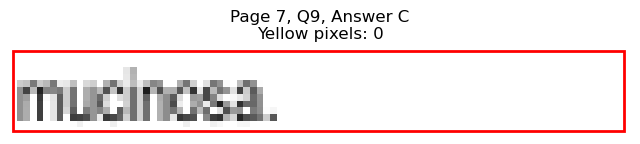

Page 7, Q9 - D: Detected box: x0=336.7, y0=711.7, x1=379.8, y1=723.8
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 289
Page 7, Q9, D: Yellow percentage: 0.0%


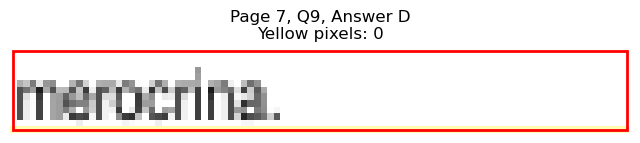

Page 7, Q9 - E: Detected box: x0=336.7, y0=723.7, x1=374.5, y1=735.8
Page 7, Q9, E: Yellow pixels: 922
Page 7, Q9, E: Total non-white pixels: 1157
Page 7, Q9, E: Yellow percentage: 79.7%


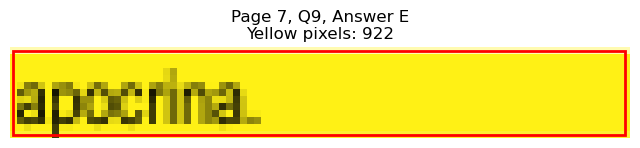


Page 7, Q9 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=129.5, y1=109.2
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 242
Page 8, Q1, A: Yellow percentage: 0.0%


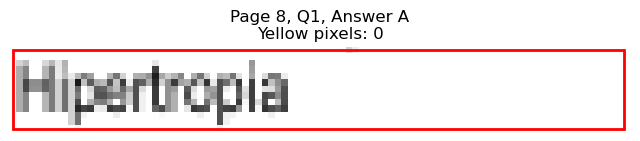

Page 8, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=113.2, y1=121.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 167
Page 8, Q1, B: Yellow percentage: 0.0%


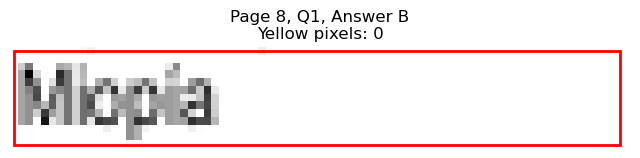

Page 8, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=123.7, y1=133.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 212
Page 8, Q1, C: Yellow percentage: 0.0%


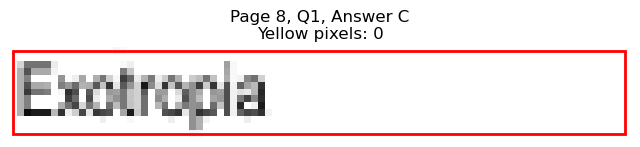

Page 8, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=393.7, y1=109.2
Page 8, Q1, D: Yellow pixels: 1061
Page 8, Q1, D: Total non-white pixels: 1404
Page 8, Q1, D: Yellow percentage: 75.6%


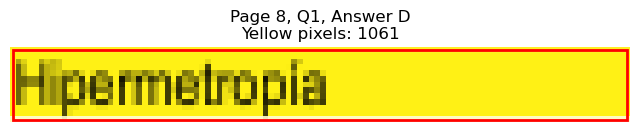

Page 8, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=393.7, y1=121.3
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 417
Page 8, Q1, E: Yellow percentage: 0.0%


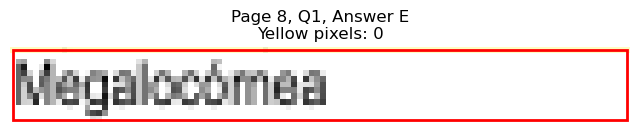


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=199.9, y1=169.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 606
Page 8, Q2, A: Yellow percentage: 0.0%


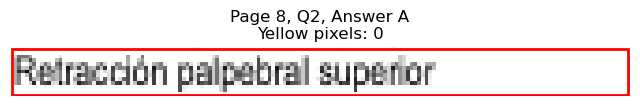

Page 8, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=167.3, y1=181.5
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 439
Page 8, Q2, B: Yellow percentage: 0.0%


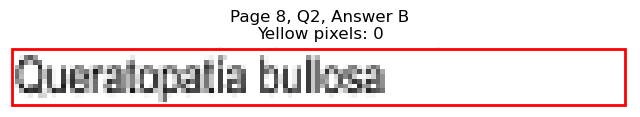

Page 8, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=164.9, y1=193.5
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 398
Page 8, Q2, C: Yellow percentage: 0.0%


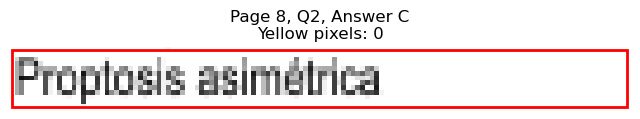

Page 8, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=447.3, y1=169.4
Page 8, Q2, D: Yellow pixels: 1646
Page 8, Q2, D: Total non-white pixels: 2106
Page 8, Q2, D: Yellow percentage: 78.2%


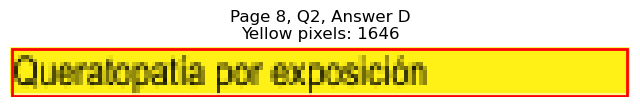

Page 8, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=437.2, y1=181.5
Page 8, Q2, E: Yellow pixels: 152
Page 8, Q2, E: Total non-white pixels: 683
Page 8, Q2, E: Yellow percentage: 22.3%


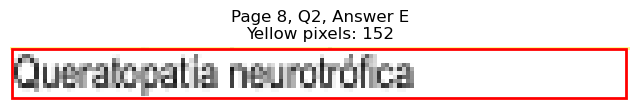


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=70.8, y0=217.5, x1=79.0, y1=229.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 51
Page 8, Q3, A: Yellow percentage: 0.0%


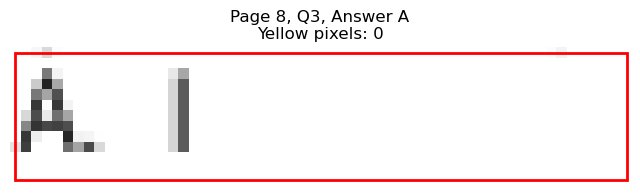

Page 8, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=94.6, y1=241.8
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 109
Page 8, Q3, B: Yellow percentage: 0.0%


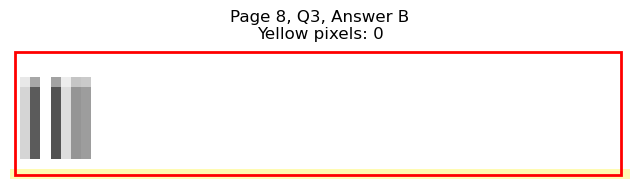

Page 8, Q3 - C: Detected box: x0=70.8, y0=241.7, x1=79.5, y1=253.8
Page 8, Q3, C: Yellow pixels: 670
Page 8, Q3, C: Total non-white pixels: 780
Page 8, Q3, C: Yellow percentage: 85.9%


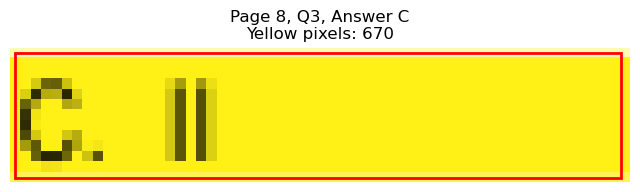

Page 8, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=347.2, y1=229.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 47
Page 8, Q3, D: Yellow percentage: 0.0%


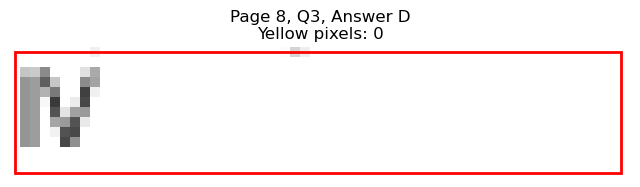

Page 8, Q3 - E: Detected box: x0=322.5, y0=229.7, x1=330.7, y1=241.8
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 58
Page 8, Q3, E: Yellow percentage: 0.0%


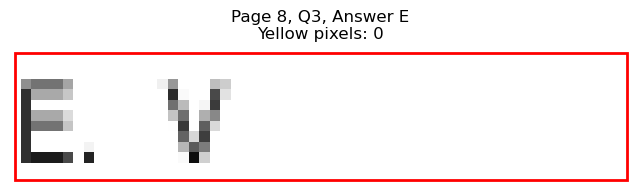


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=277.8, x1=130.5, y1=289.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 240
Page 8, Q4, A: Yellow percentage: 0.0%


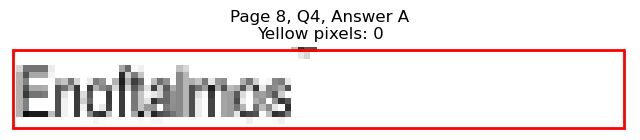

Page 8, Q4 - B: Detected box: x0=85.0, y0=289.9, x1=123.9, y1=302.0
Page 8, Q4, B: Yellow pixels: 910
Page 8, Q4, B: Total non-white pixels: 1172
Page 8, Q4, B: Yellow percentage: 77.6%


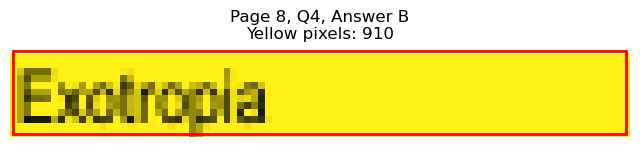

Page 8, Q4 - C: Detected box: x0=85.0, y0=651.4, x1=142.1, y1=663.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 540
Page 8, Q4, C: Yellow percentage: 0.0%


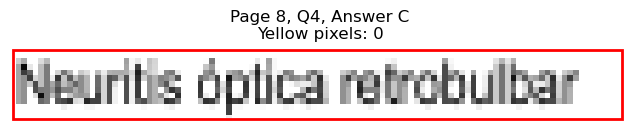

Page 8, Q4 - D: Detected box: x0=336.7, y0=277.8, x1=387.9, y1=289.9
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 282
Page 8, Q4, D: Yellow percentage: 0.0%


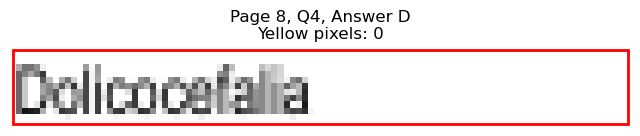

Page 8, Q4 - E: Detected box: x0=336.7, y0=289.9, x1=378.3, y1=302.0
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 223
Page 8, Q4, E: Yellow percentage: 0.0%


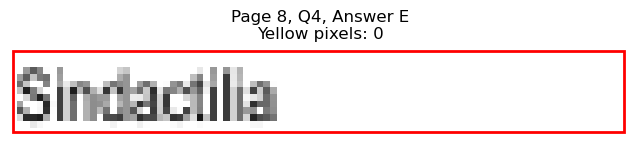


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=338.1, x1=167.3, y1=350.2
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 386
Page 8, Q5, A: Yellow percentage: 0.0%


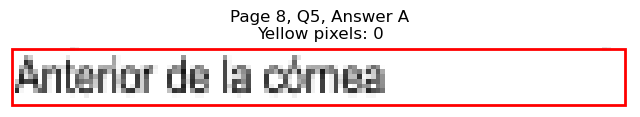

Page 8, Q5 - B: Detected box: x0=85.0, y0=350.2, x1=171.6, y1=362.3
Page 8, Q5, B: Yellow pixels: 138
Page 8, Q5, B: Total non-white pixels: 566
Page 8, Q5, B: Yellow percentage: 24.4%


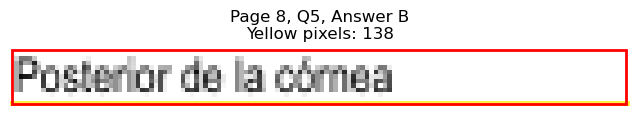

Page 8, Q5 - C: Detected box: x0=85.0, y0=362.2, x1=167.8, y1=374.3
Page 8, Q5, C: Yellow pixels: 1268
Page 8, Q5, C: Total non-white pixels: 1742
Page 8, Q5, C: Yellow percentage: 72.8%


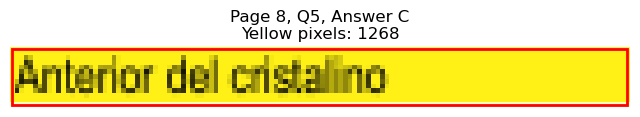

Page 8, Q5 - D: Detected box: x0=336.7, y0=338.1, x1=423.8, y1=350.2
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 451
Page 8, Q5, D: Yellow percentage: 0.0%


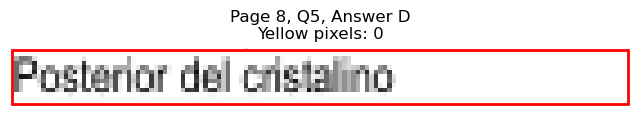

Page 8, Q5 - E: Detected box: x0=336.7, y0=350.2, x1=454.9, y1=362.3
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 608
Page 8, Q5, E: Yellow percentage: 0.0%


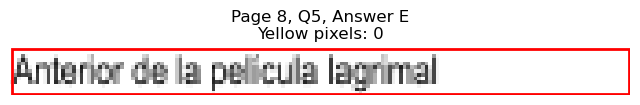


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=398.3, x1=174.0, y1=410.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 413
Page 8, Q6, A: Yellow percentage: 0.0%


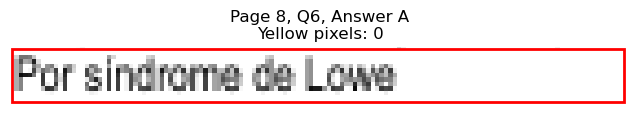

Page 8, Q6 - B: Detected box: x0=85.0, y0=410.4, x1=185.5, y1=422.5
Page 8, Q6, B: Yellow pixels: 152
Page 8, Q6, B: Total non-white pixels: 647
Page 8, Q6, B: Yellow percentage: 23.5%


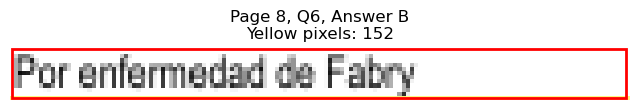

Page 8, Q6 - C: Detected box: x0=85.0, y0=422.4, x1=153.9, y1=434.5
Page 8, Q6, C: Yellow pixels: 1285
Page 8, Q6, C: Total non-white pixels: 1560
Page 8, Q6, C: Yellow percentage: 82.4%


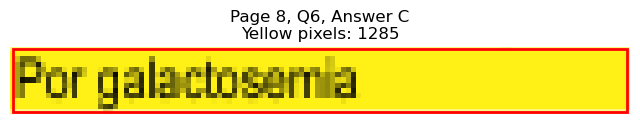

Page 8, Q6 - D: Detected box: x0=336.7, y0=398.3, x1=402.7, y1=410.4
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 323
Page 8, Q6, D: Yellow percentage: 0.0%


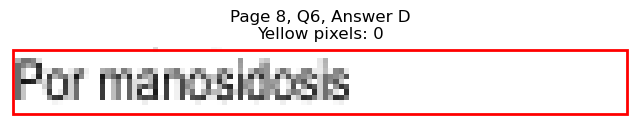

Page 8, Q6 - E: Detected box: x0=336.7, y0=410.4, x1=427.2, y1=422.5
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 435
Page 8, Q6, E: Yellow percentage: 0.0%


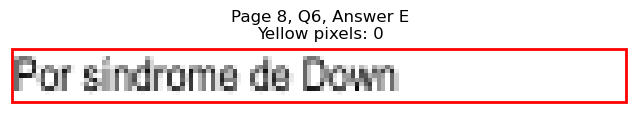


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=458.6, x1=118.0, y1=470.7
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 169
Page 8, Q7, A: Yellow percentage: 0.0%


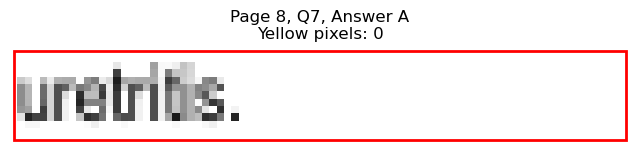

Page 8, Q7 - B: Detected box: x0=85.0, y0=470.7, x1=117.0, y1=482.8
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 173
Page 8, Q7, B: Yellow percentage: 0.0%


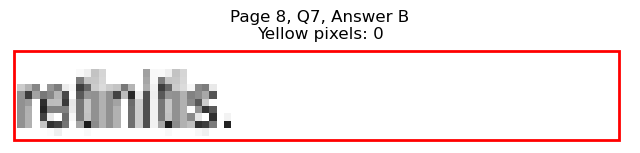

Page 8, Q7 - C: Detected box: x0=85.0, y0=482.7, x1=114.1, y1=494.8
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 147
Page 8, Q7, C: Yellow percentage: 0.0%


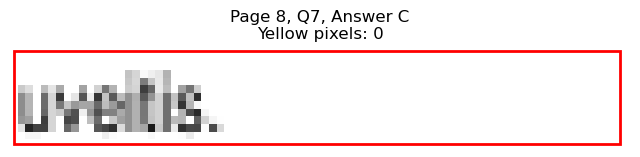

Page 8, Q7 - D: Detected box: x0=336.7, y0=458.6, x1=364.9, y1=470.7
Page 8, Q7, D: Yellow pixels: 928
Page 8, Q7, D: Total non-white pixels: 1027
Page 8, Q7, D: Yellow percentage: 90.4%


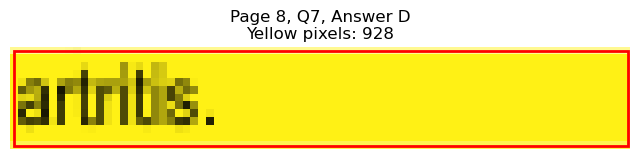

Page 8, Q7 - E: Detected box: x0=336.7, y0=470.7, x1=375.0, y1=482.8
Page 8, Q7, E: Yellow pixels: 89
Page 8, Q7, E: Total non-white pixels: 288
Page 8, Q7, E: Yellow percentage: 30.9%


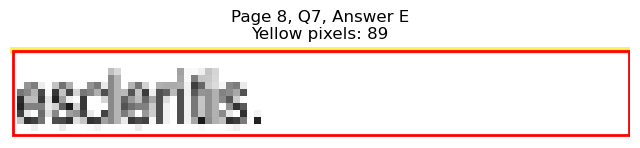


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=542.9, x1=135.9, y1=555.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 272
Page 8, Q8, A: Yellow percentage: 0.0%


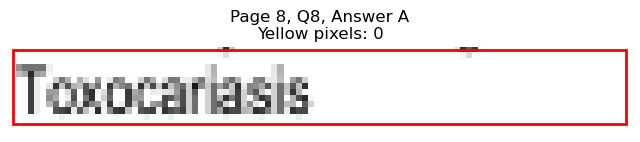

Page 8, Q8 - B: Detected box: x0=85.0, y0=554.9, x1=136.3, y1=567.0
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 260
Page 8, Q8, B: Yellow percentage: 0.0%


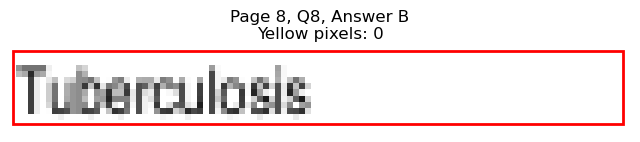

Page 8, Q8 - C: Detected box: x0=85.0, y0=567.1, x1=108.0, y1=579.2
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 114
Page 8, Q8, C: Yellow percentage: 0.0%


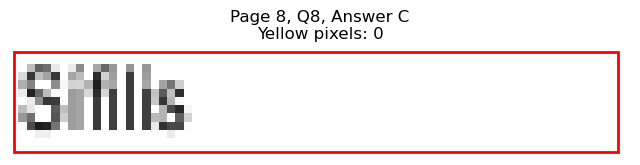

Page 8, Q8 - D: Detected box: x0=336.7, y0=542.9, x1=396.7, y1=555.0
Page 8, Q8, D: Yellow pixels: 1088
Page 8, Q8, D: Total non-white pixels: 1445
Page 8, Q8, D: Yellow percentage: 75.3%


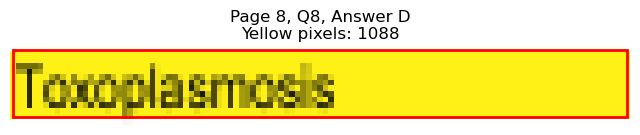

Page 8, Q8 - E: Detected box: x0=336.7, y0=554.9, x1=366.8, y1=567.0
Page 8, Q8, E: Yellow pixels: 79
Page 8, Q8, E: Total non-white pixels: 237
Page 8, Q8, E: Yellow percentage: 33.3%


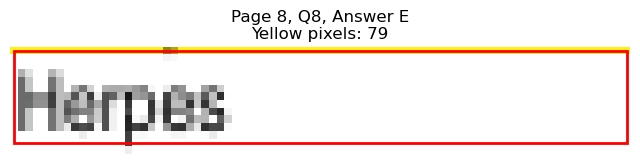


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=151.0, y1=639.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 366
Page 8, Q9, A: Yellow percentage: 0.0%


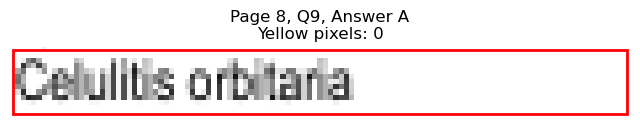

Page 8, Q9 - B: Detected box: x0=85.0, y0=639.3, x1=189.4, y1=651.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 514
Page 8, Q9, B: Yellow percentage: 0.0%


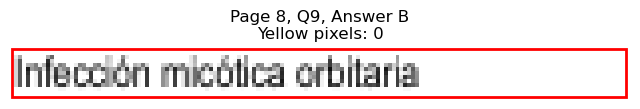

Page 8, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=186.0, y1=663.5
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 540
Page 8, Q9, C: Yellow percentage: 0.0%


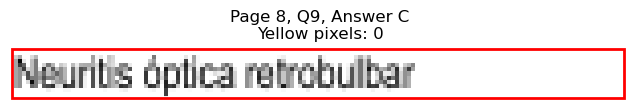

Page 8, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=409.4, y1=639.4
Page 8, Q9, D: Yellow pixels: 124
Page 8, Q9, D: Total non-white pixels: 497
Page 8, Q9, D: Yellow percentage: 24.9%


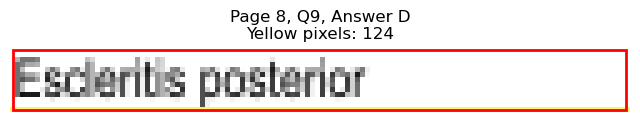

Page 8, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=401.2, y1=651.4
Page 8, Q9, E: Yellow pixels: 1216
Page 8, Q9, E: Total non-white pixels: 1508
Page 8, Q9, E: Yellow percentage: 80.6%


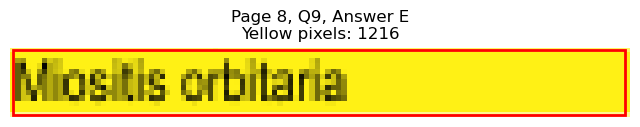


Page 8, Q9 - Selected Answer: E (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=85.0, y0=687.5, x1=152.9, y1=699.7
Page 8, Q10, A: Yellow pixels: 119
Page 8, Q10, A: Total non-white pixels: 435
Page 8, Q10, A: Yellow percentage: 27.4%


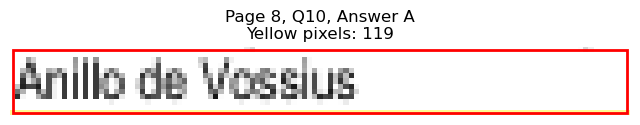

Page 8, Q10 - B: Detected box: x0=85.0, y0=699.5, x1=166.3, y1=711.7
Page 8, Q10, B: Yellow pixels: 1379
Page 8, Q10, B: Total non-white pixels: 1729
Page 8, Q10, B: Yellow percentage: 79.8%


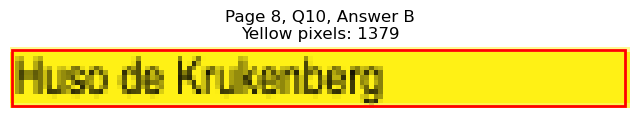

Page 8, Q10 - C: Detected box: x0=85.0, y0=711.7, x1=158.8, y1=723.8
Page 8, Q10, C: Yellow pixels: 124
Page 8, Q10, C: Total non-white pixels: 513
Page 8, Q10, C: Yellow percentage: 24.2%


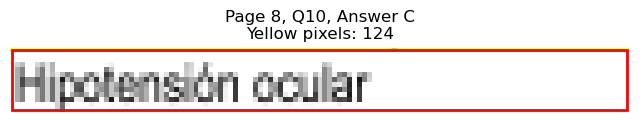

Page 8, Q10 - D: Detected box: x0=336.7, y0=687.5, x1=387.9, y1=699.7
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 254
Page 8, Q10, D: Yellow percentage: 0.0%


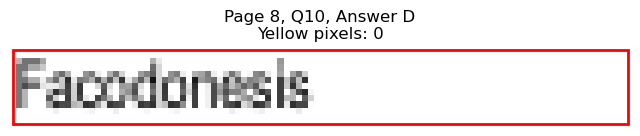

Page 8, Q10 - E: Detected box: x0=336.7, y0=699.5, x1=383.6, y1=711.7
Page 8, Q10, E: Yellow pixels: 0
Page 8, Q10, E: Total non-white pixels: 260
Page 8, Q10, E: Yellow percentage: 0.0%


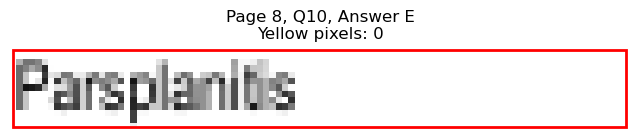


Page 8, Q10 - Selected Answer: B (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=85.0, y0=747.8, x1=170.2, y1=759.9
Page 8, Q11, A: Yellow pixels: 1260
Page 8, Q11, A: Total non-white pixels: 1781
Page 8, Q11, A: Yellow percentage: 70.7%


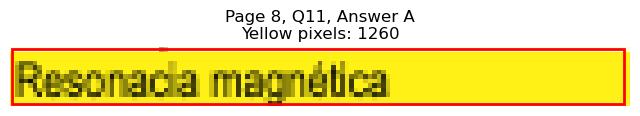

Page 8, Q11 - B: Detected box: x0=85.0, y0=759.8, x1=190.4, y1=771.9
Page 8, Q11, B: Yellow pixels: 154
Page 8, Q11, B: Total non-white pixels: 697
Page 8, Q11, B: Yellow percentage: 22.1%


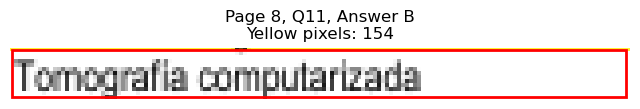

Page 8, Q11 - C: Detected box: x0=85.0, y0=771.9, x1=124.3, y1=784.0
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 213
Page 8, Q11, C: Yellow percentage: 0.0%


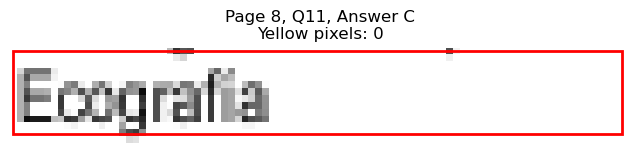

Page 8, Q11 - D: Detected box: x0=336.7, y0=747.8, x1=383.6, y1=759.9
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 259
Page 8, Q11, D: Yellow percentage: 0.0%


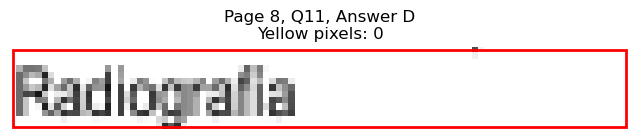

Page 8, Q11 - E: Detected box: x0=336.7, y0=759.8, x1=465.0, y1=771.9
Page 8, Q11, E: Yellow pixels: 0
Page 8, Q11, E: Total non-white pixels: 636
Page 8, Q11, E: Yellow percentage: 0.0%


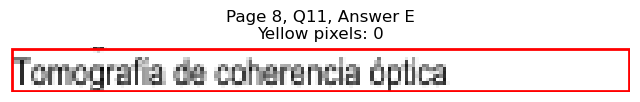


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=151.5, y1=109.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 333
Page 9, Q1, A: Yellow percentage: 0.0%


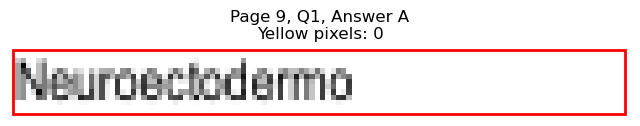

Page 9, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=180.3, y1=121.3
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 495
Page 9, Q1, B: Yellow percentage: 0.0%


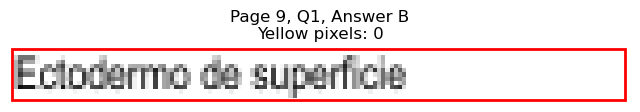

Page 9, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=132.9, y1=133.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 252
Page 9, Q1, C: Yellow percentage: 0.0%


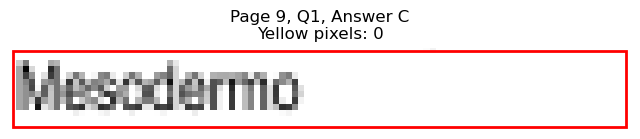

Page 9, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=383.6, y1=109.2
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 220
Page 9, Q1, D: Yellow percentage: 0.0%


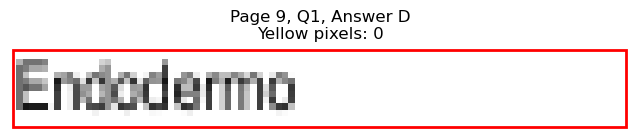

Page 9, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=390.8, y1=121.3
Page 9, Q1, E: Yellow pixels: 1043
Page 9, Q1, E: Total non-white pixels: 1365
Page 9, Q1, E: Yellow percentage: 76.4%


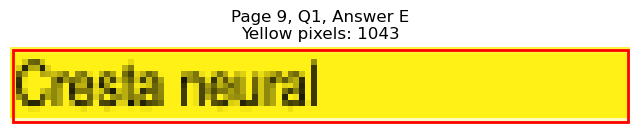


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=153.4, y1=169.4
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 337
Page 9, Q2, A: Yellow percentage: 0.0%


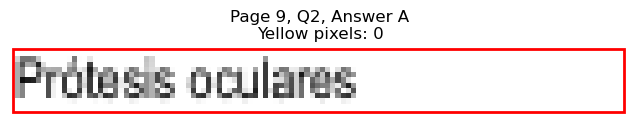

Page 9, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=193.3, y1=181.5
Page 9, Q2, B: Yellow pixels: 160
Page 9, Q2, B: Total non-white pixels: 759
Page 9, Q2, B: Yellow percentage: 21.1%


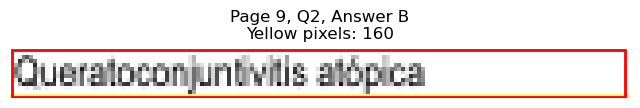

Page 9, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=160.2, y1=193.5
Page 9, Q2, C: Yellow pixels: 1368
Page 9, Q2, C: Total non-white pixels: 1651
Page 9, Q2, C: Yellow percentage: 82.9%


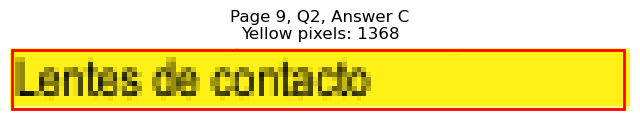

Page 9, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=409.4, y1=169.4
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 397
Page 9, Q2, D: Yellow percentage: 0.0%


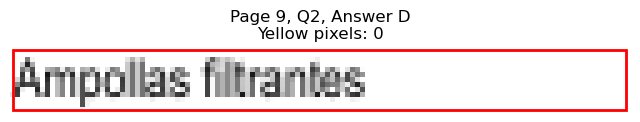

Page 9, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=435.3, y1=181.5
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 526
Page 9, Q2, E: Yellow percentage: 0.0%


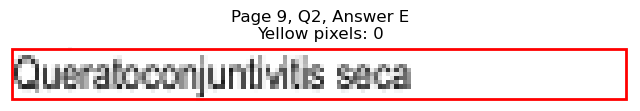


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=173.1, y1=229.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 480
Page 9, Q3, A: Yellow percentage: 0.0%


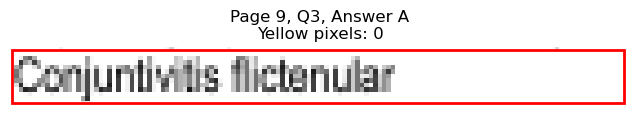

Page 9, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=133.3, y1=241.8
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 261
Page 9, Q3, B: Yellow percentage: 0.0%


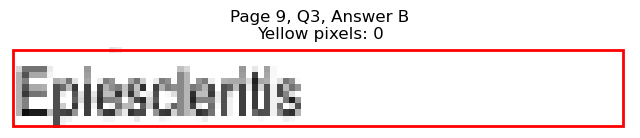

Page 9, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=159.6, y1=253.8
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 382
Page 9, Q3, C: Yellow percentage: 0.0%


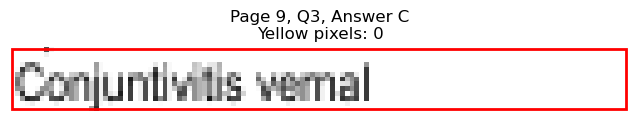

Page 9, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=437.7, y1=229.7
Page 9, Q3, D: Yellow pixels: 1554
Page 9, Q3, D: Total non-white pixels: 1976
Page 9, Q3, D: Yellow percentage: 78.6%


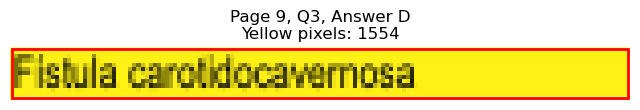

Page 9, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=428.1, y1=241.8
Page 9, Q3, E: Yellow pixels: 143
Page 9, Q3, E: Total non-white pixels: 600
Page 9, Q3, E: Yellow percentage: 23.8%


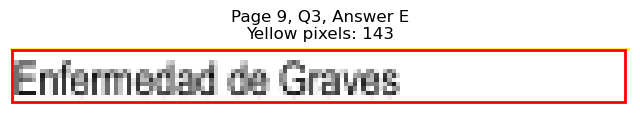


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=124.7, y1=302.0
Page 9, Q4, A: Yellow pixels: 913
Page 9, Q4, A: Total non-white pixels: 1183
Page 9, Q4, A: Yellow percentage: 77.2%


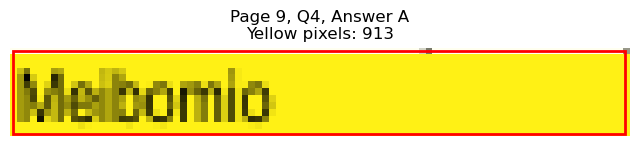

Page 9, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=107.9, y1=314.0
Page 9, Q4, B: Yellow pixels: 74
Page 9, Q4, B: Total non-white pixels: 191
Page 9, Q4, B: Yellow percentage: 38.7%


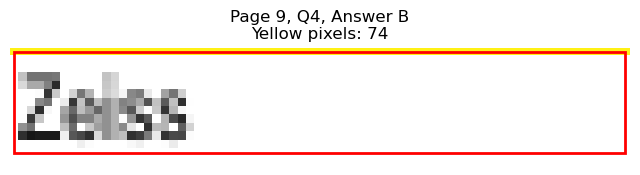

Page 9, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=103.2, y1=326.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 105
Page 9, Q4, C: Yellow percentage: 0.0%


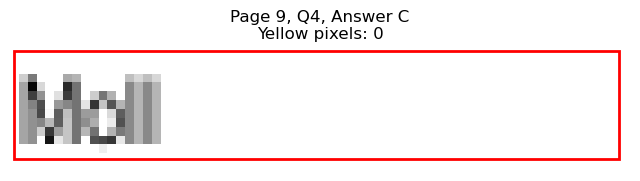

Page 9, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=370.6, y1=302.0
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 170
Page 9, Q4, D: Yellow percentage: 0.0%


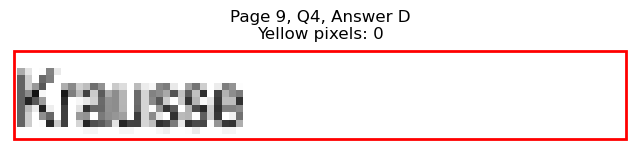

Page 9, Q4 - E: Detected box: x0=336.7, y0=301.9, x1=370.6, y1=314.0
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 188
Page 9, Q4, E: Yellow percentage: 0.0%


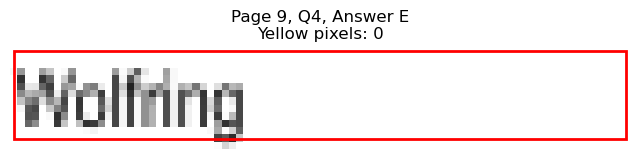


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=113.7, y1=374.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 136
Page 9, Q5, A: Yellow percentage: 0.0%


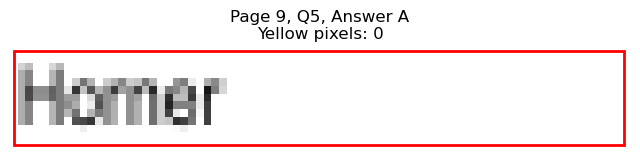

Page 9, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=110.3, y1=386.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 142
Page 9, Q5, B: Yellow percentage: 0.0%


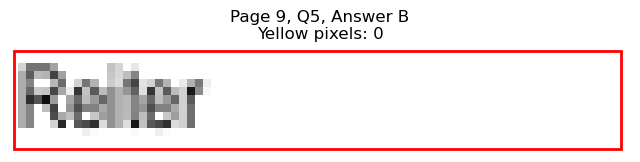

Page 9, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=112.7, y1=398.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 153
Page 9, Q5, C: Yellow percentage: 0.0%


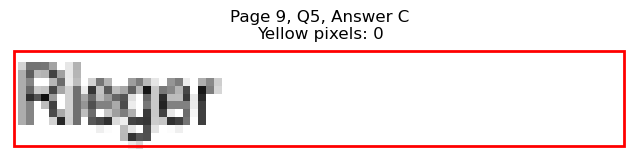

Page 9, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=361.0, y1=374.3
Page 9, Q5, D: Yellow pixels: 810
Page 9, Q5, D: Total non-white pixels: 988
Page 9, Q5, D: Yellow percentage: 82.0%


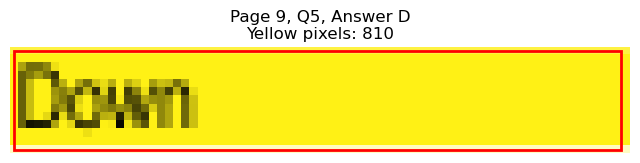

Page 9, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=386.0, y1=386.3
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 313
Page 9, Q5, E: Yellow percentage: 0.0%


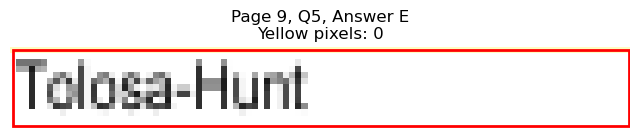


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=422.4, x1=130.0, y1=434.5
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 236
Page 9, Q6, A: Yellow percentage: 0.0%


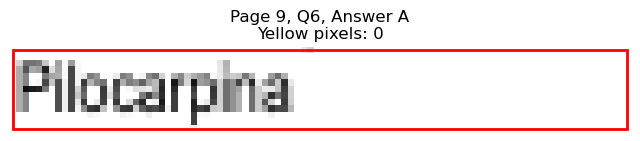

Page 9, Q6 - B: Detected box: x0=85.0, y0=434.4, x1=133.8, y1=446.5
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 257
Page 9, Q6, B: Yellow percentage: 0.0%


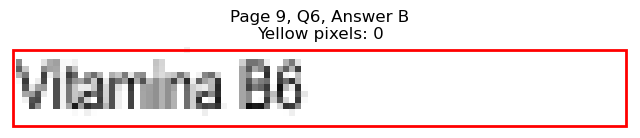

Page 9, Q6 - C: Detected box: x0=85.0, y0=446.6, x1=121.8, y1=458.7
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 192
Page 9, Q6, C: Yellow percentage: 0.0%


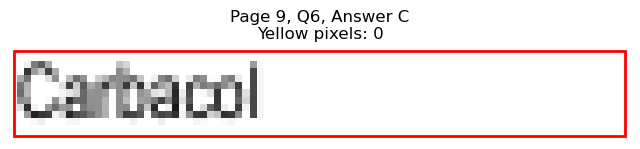

Page 9, Q6 - D: Detected box: x0=336.7, y0=422.4, x1=378.8, y1=434.5
Page 9, Q6, D: Yellow pixels: 93
Page 9, Q6, D: Total non-white pixels: 331
Page 9, Q6, D: Yellow percentage: 28.1%


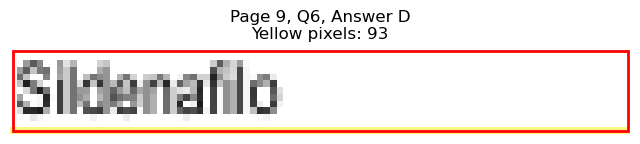

Page 9, Q6 - E: Detected box: x0=336.7, y0=434.4, x1=382.6, y1=446.5
Page 9, Q6, E: Yellow pixels: 1066
Page 9, Q6, E: Total non-white pixels: 1261
Page 9, Q6, E: Yellow percentage: 84.5%


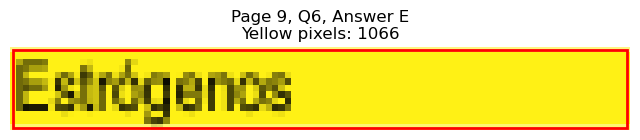


Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=482.7, x1=146.3, y1=494.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 311
Page 9, Q7, A: Yellow percentage: 0.0%


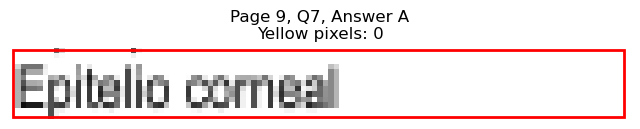

Page 9, Q7 - B: Detected box: x0=85.0, y0=494.7, x1=177.9, y1=506.8
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 475
Page 9, Q7, B: Yellow percentage: 0.0%


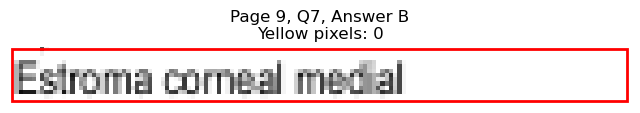

Page 9, Q7 - C: Detected box: x0=85.0, y0=506.8, x1=186.0, y1=518.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 515
Page 9, Q7, C: Yellow percentage: 0.0%


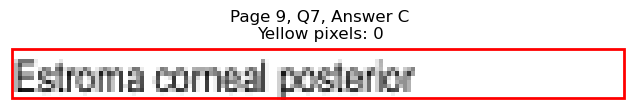

Page 9, Q7 - D: Detected box: x0=336.7, y0=482.7, x1=433.4, y1=494.8
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 652
Page 9, Q7, D: Yellow percentage: 0.0%


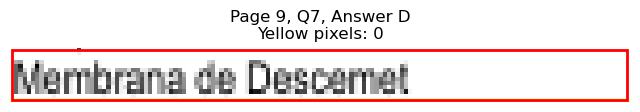

Page 9, Q7 - E: Detected box: x0=336.7, y0=494.7, x1=428.1, y1=506.8
Page 9, Q7, E: Yellow pixels: 1326
Page 9, Q7, E: Total non-white pixels: 1859
Page 9, Q7, E: Yellow percentage: 71.3%


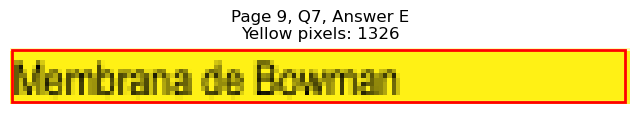


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=554.9, x1=299.0, y1=567.0
Page 9, Q8, A: Yellow pixels: 2395
Page 9, Q8, A: Total non-white pixels: 3710
Page 9, Q8, A: Yellow percentage: 64.6%


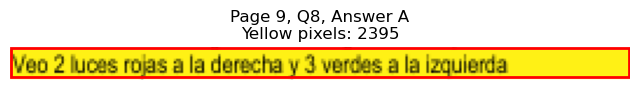

Page 9, Q8 - B: Detected box: x0=85.0, y0=567.1, x1=299.0, y1=579.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 1270
Page 9, Q8, B: Yellow percentage: 0.0%


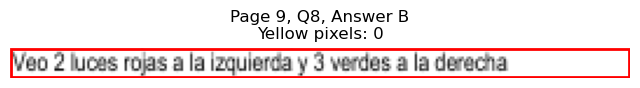

Page 9, Q8 - C: Detected box: x0=85.0, y0=579.1, x1=153.5, y1=591.2
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 310
Page 9, Q8, C: Yellow percentage: 0.0%


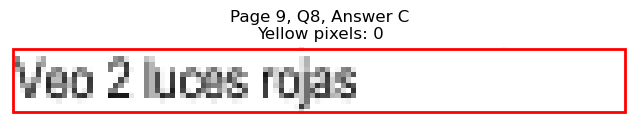

Page 9, Q8 - D: Detected box: x0=85.0, y0=591.2, x1=160.6, y1=603.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 347
Page 9, Q8, D: Yellow percentage: 0.0%


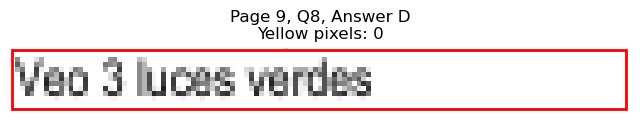

Page 9, Q8 - E: Detected box: x0=85.0, y0=603.2, x1=262.1, y1=615.3
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 799
Page 9, Q8, E: Yellow percentage: 0.0%


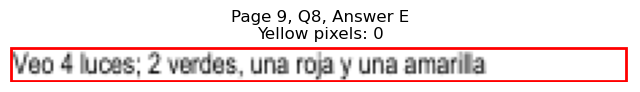


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=639.3, x1=128.1, y1=651.4
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 224
Page 9, Q9, A: Yellow percentage: 0.0%


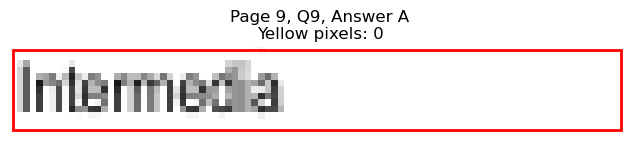

Page 9, Q9 - B: Detected box: x0=85.0, y0=651.4, x1=121.8, y1=663.5
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 188
Page 9, Q9, B: Yellow percentage: 0.0%


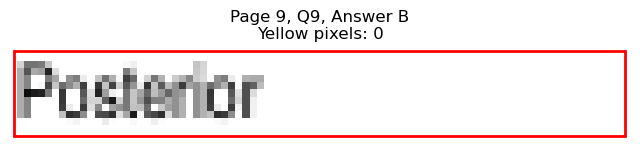

Page 9, Q9 - C: Detected box: x0=85.0, y0=663.4, x1=127.1, y1=675.5
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 213
Page 9, Q9, C: Yellow percentage: 0.0%


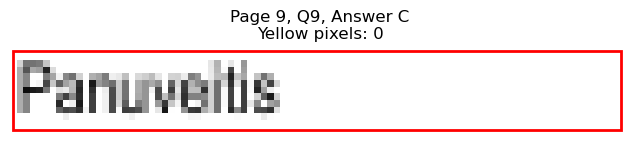

Page 9, Q9 - D: Detected box: x0=336.7, y0=639.3, x1=369.2, y1=651.4
Page 9, Q9, D: Yellow pixels: 969
Page 9, Q9, D: Total non-white pixels: 1092
Page 9, Q9, D: Yellow percentage: 88.7%


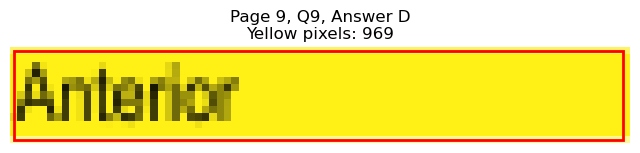

Page 9, Q9 - E: Detected box: x0=336.7, y0=651.4, x1=390.3, y1=663.5
Page 9, Q9, E: Yellow pixels: 105
Page 9, Q9, E: Total non-white pixels: 368
Page 9, Q9, E: Yellow percentage: 28.5%


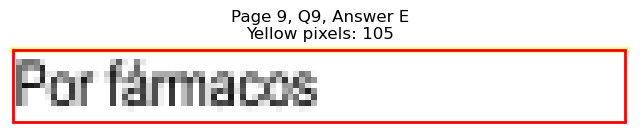


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=142.0, y1=747.9
Page 9, Q10, A: Yellow pixels: 1060
Page 9, Q10, A: Total non-white pixels: 1404
Page 9, Q10, A: Yellow percentage: 75.5%


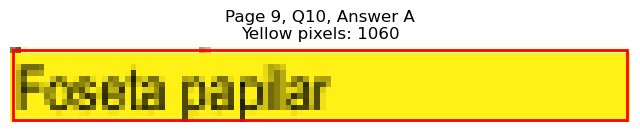

Page 9, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=208.0, y1=759.9
Page 9, Q10, B: Yellow pixels: 173
Page 9, Q10, B: Total non-white pixels: 808
Page 9, Q10, B: Yellow percentage: 21.4%


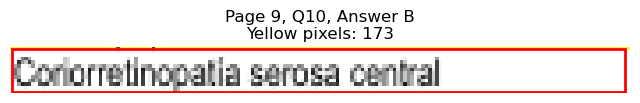

Page 9, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=183.1, y1=771.9
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 532
Page 9, Q10, C: Yellow percentage: 0.0%


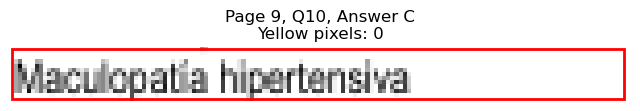

Page 9, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=431.5, y1=747.9
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 480
Page 9, Q10, D: Yellow percentage: 0.0%


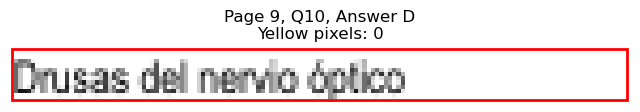

Page 9, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=425.4, y1=759.9
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 487
Page 9, Q10, E: Yellow percentage: 0.0%


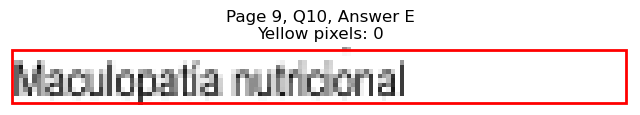


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=116.1, y1=109.2
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 151
Page 10, Q1, A: Yellow percentage: 0.0%


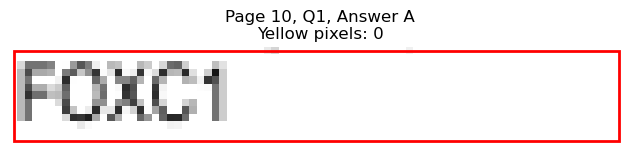

Page 10, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=112.7, y1=121.3
Page 10, Q1, B: Yellow pixels: 79
Page 10, Q1, B: Total non-white pixels: 217
Page 10, Q1, B: Yellow percentage: 36.4%


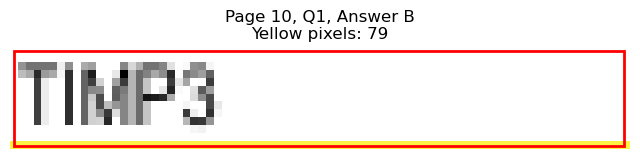

Page 10, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=109.3, y1=133.3
Page 10, Q1, C: Yellow pixels: 811
Page 10, Q1, C: Total non-white pixels: 988
Page 10, Q1, C: Yellow percentage: 82.1%


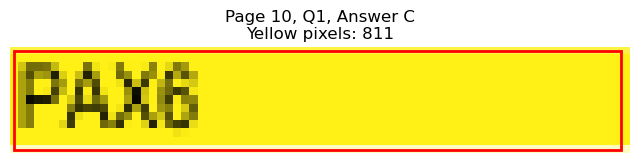

Page 10, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=361.2, y1=109.2
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 104
Page 10, Q1, D: Yellow percentage: 0.0%


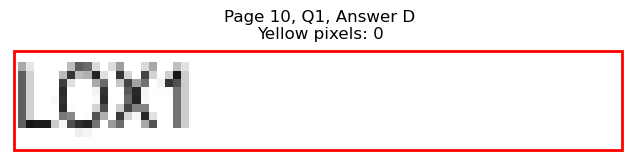

Page 10, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=362.5, y1=121.3
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 103
Page 10, Q1, E: Yellow percentage: 0.0%


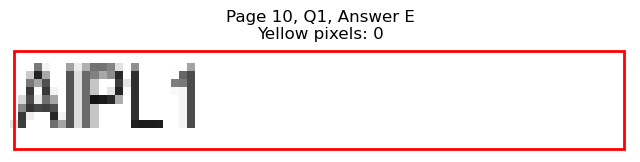


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=157.7, y1=193.5
Page 10, Q2, A: Yellow pixels: 124
Page 10, Q2, A: Total non-white pixels: 495
Page 10, Q2, A: Yellow percentage: 25.1%


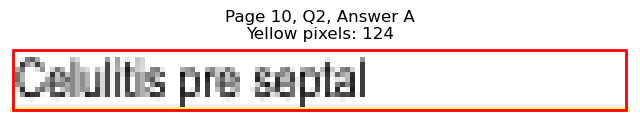

Page 10, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=152.9, y1=205.5
Page 10, Q2, B: Yellow pixels: 1238
Page 10, Q2, B: Total non-white pixels: 1547
Page 10, Q2, B: Yellow percentage: 80.0%


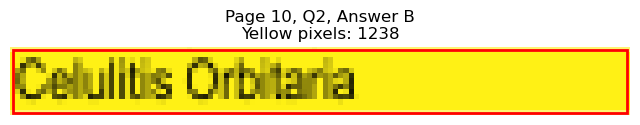

Page 10, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=189.9, y1=217.7
Page 10, Q2, C: Yellow pixels: 156
Page 10, Q2, C: Total non-white pixels: 666
Page 10, Q2, C: Yellow percentage: 23.4%


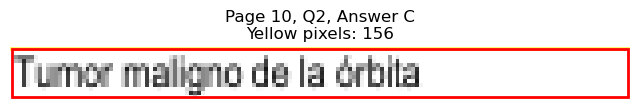

Page 10, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=412.3, y1=193.5
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 420
Page 10, Q2, D: Yellow percentage: 0.0%


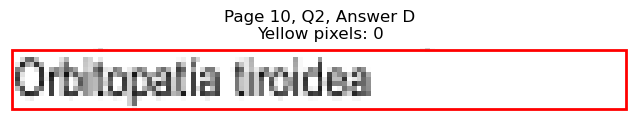

Page 10, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=393.7, y1=205.5
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 313
Page 10, Q2, E: Yellow percentage: 0.0%


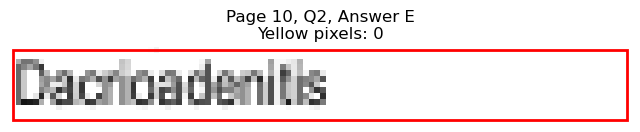


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=130.0, y1=265.8
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 252
Page 10, Q3, A: Yellow percentage: 0.0%


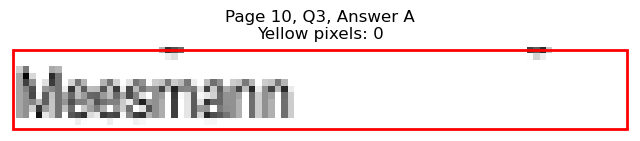

Page 10, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=112.7, y1=277.9
Page 10, Q3, B: Yellow pixels: 840
Page 10, Q3, B: Total non-white pixels: 1027
Page 10, Q3, B: Yellow percentage: 81.8%


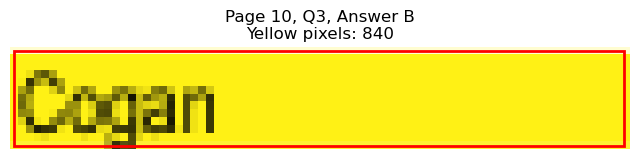

Page 10, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=107.5, y1=289.9
Page 10, Q3, C: Yellow pixels: 70
Page 10, Q3, C: Total non-white pixels: 183
Page 10, Q3, C: Yellow percentage: 38.3%


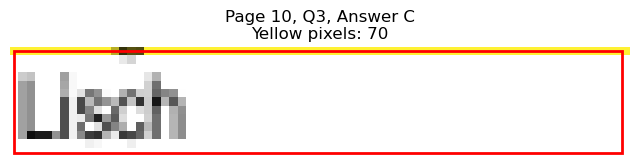

Page 10, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=375.4, y1=265.8
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 197
Page 10, Q3, D: Yellow percentage: 0.0%


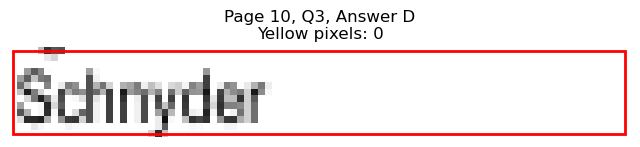

Page 10, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=362.5, y1=277.9
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 130
Page 10, Q3, E: Yellow percentage: 0.0%


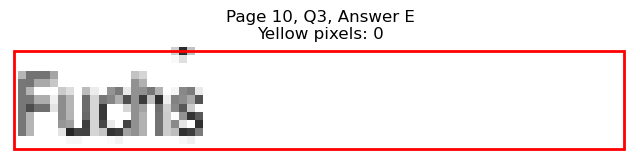


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=122.3, y1=338.2
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 200
Page 10, Q4, A: Yellow percentage: 0.0%


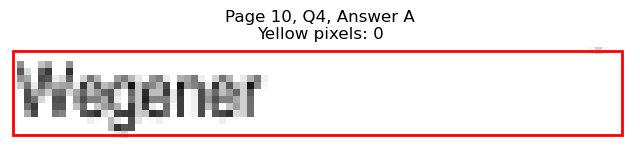

Page 10, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=138.6, y1=350.2
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 277
Page 10, Q4, B: Yellow percentage: 0.0%


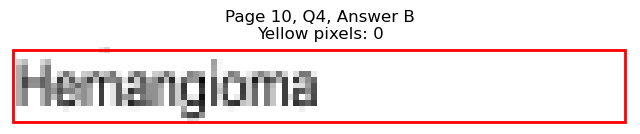

Page 10, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=118.0, y1=362.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 164
Page 10, Q4, C: Yellow percentage: 0.0%


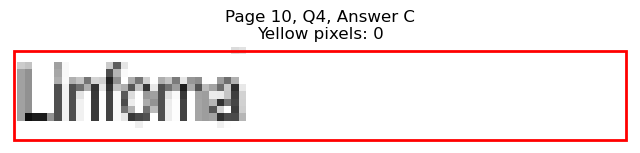

Page 10, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=376.4, y1=338.2
Page 10, Q4, D: Yellow pixels: 91
Page 10, Q4, D: Total non-white pixels: 288
Page 10, Q4, D: Yellow percentage: 31.6%


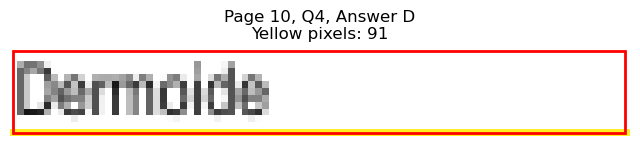

Page 10, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=408.9, y1=350.2
Page 10, Q4, E: Yellow pixels: 1173
Page 10, Q4, E: Total non-white pixels: 1599
Page 10, Q4, E: Yellow percentage: 73.4%


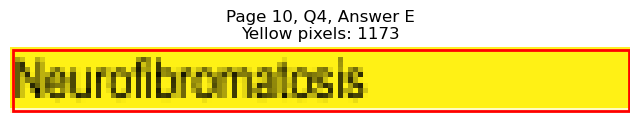


Page 10, Q4 - Selected Answer: E (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=230.6, y1=398.4
Page 10, Q5, A: Yellow pixels: 1676
Page 10, Q5, A: Total non-white pixels: 2484
Page 10, Q5, A: Yellow percentage: 67.5%


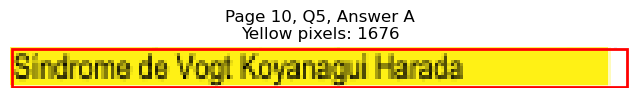

Page 10, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=183.1, y1=410.4
Page 10, Q5, B: Yellow pixels: 2
Page 10, Q5, B: Total non-white pixels: 677
Page 10, Q5, B: Yellow percentage: 0.3%


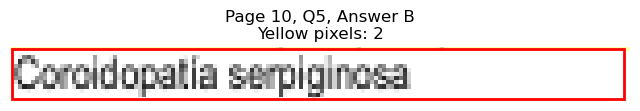

Page 10, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=201.3, y1=422.5
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 555
Page 10, Q5, C: Yellow percentage: 0.0%


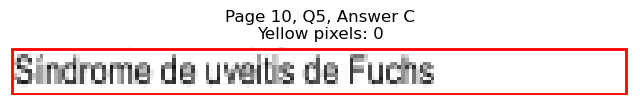

Page 10, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=376.5, y1=398.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 339
Page 10, Q5, D: Yellow percentage: 0.0%


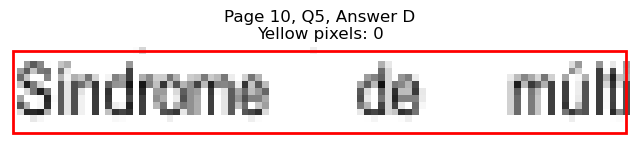

Page 10, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=421.4, y1=422.5
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 436
Page 10, Q5, E: Yellow percentage: 0.0%


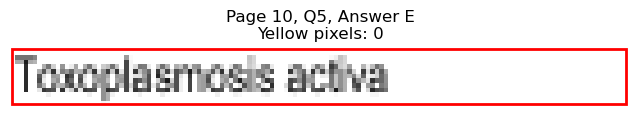


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=97.0, y1=470.7
Page 10, Q6, A: Yellow pixels: 776
Page 10, Q6, A: Total non-white pixels: 819
Page 10, Q6, A: Yellow percentage: 94.7%


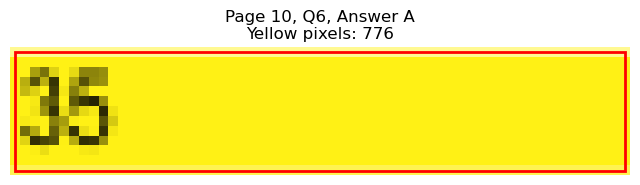

Page 10, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=97.0, y1=482.8
Page 10, Q6, B: Yellow pixels: 63
Page 10, Q6, B: Total non-white pixels: 116
Page 10, Q6, B: Yellow percentage: 54.3%


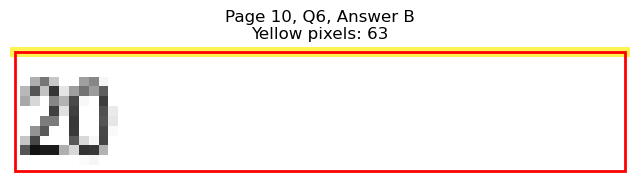

Page 10, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=97.0, y1=494.8
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 56
Page 10, Q6, C: Yellow percentage: 0.0%


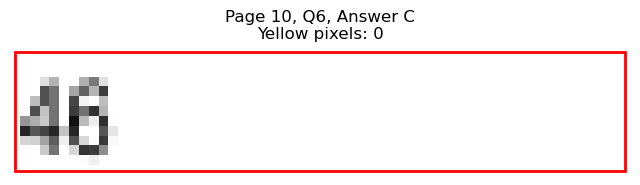

Page 10, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=348.7, y1=470.7
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 33
Page 10, Q6, D: Yellow percentage: 0.0%


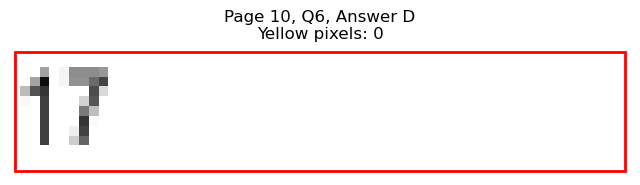

Page 10, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=348.7, y1=482.8
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 53
Page 10, Q6, E: Yellow percentage: 0.0%


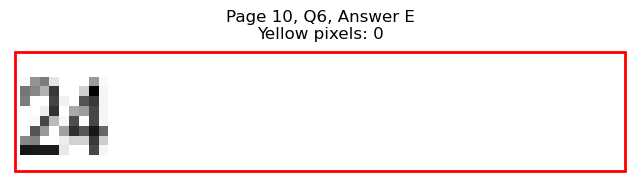


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=254.0, y1=530.9
Page 10, Q7, A: Yellow pixels: 1924
Page 10, Q7, A: Total non-white pixels: 2860
Page 10, Q7, A: Yellow percentage: 67.3%


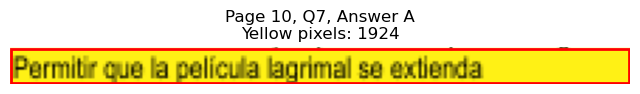

Page 10, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=220.5, y1=543.0
Page 10, Q7, B: Yellow pixels: 179
Page 10, Q7, B: Total non-white pixels: 873
Page 10, Q7, B: Yellow percentage: 20.5%


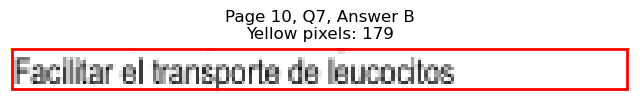

Page 10, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=247.3, y1=555.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 797
Page 10, Q7, C: Yellow percentage: 0.0%


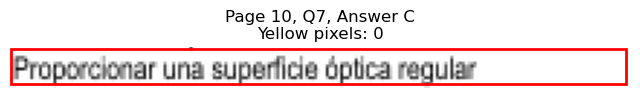

Page 10, Q7 - D: Detected box: x0=85.0, y0=554.9, x1=178.8, y1=567.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 511
Page 10, Q7, D: Yellow percentage: 0.0%


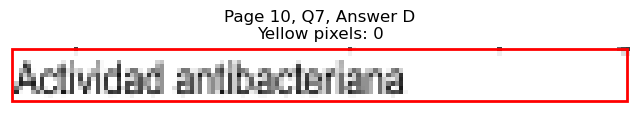

Page 10, Q7 - E: Detected box: x0=85.0, y0=567.1, x1=280.3, y1=579.2
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 994
Page 10, Q7, E: Yellow percentage: 0.0%


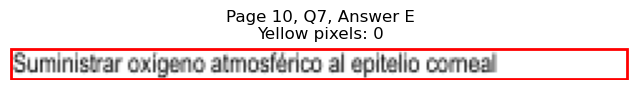


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=627.3, x1=113.8, y1=639.4
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 149
Page 10, Q8, A: Yellow percentage: 0.0%


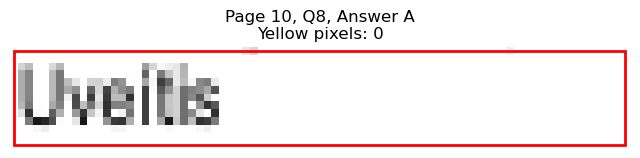

Page 10, Q8 - B: Detected box: x0=85.0, y0=639.3, x1=124.2, y1=651.4
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 215
Page 10, Q8, B: Yellow percentage: 0.0%


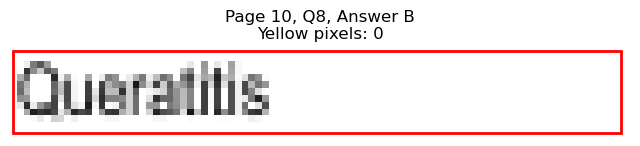

Page 10, Q8 - C: Detected box: x0=85.0, y0=651.4, x1=121.8, y1=663.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 201
Page 10, Q8, C: Yellow percentage: 0.0%


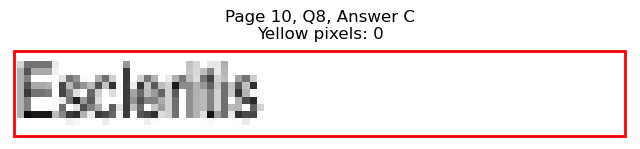

Page 10, Q8 - D: Detected box: x0=336.7, y0=627.3, x1=404.7, y1=639.4
Page 10, Q8, D: Yellow pixels: 1154
Page 10, Q8, D: Total non-white pixels: 1547
Page 10, Q8, D: Yellow percentage: 74.6%


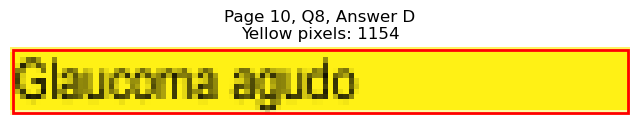

Page 10, Q8 - E: Detected box: x0=336.7, y0=639.3, x1=385.5, y1=651.4
Page 10, Q8, E: Yellow pixels: 1
Page 10, Q8, E: Total non-white pixels: 348
Page 10, Q8, E: Yellow percentage: 0.3%


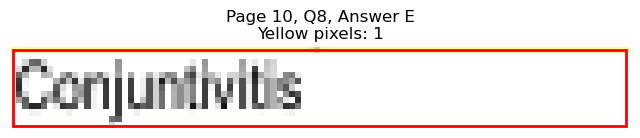


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=187.5, y1=699.7
Page 10, Q9, A: Yellow pixels: 1568
Page 10, Q9, A: Total non-white pixels: 2002
Page 10, Q9, A: Yellow percentage: 78.3%


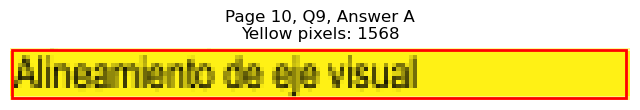

Page 10, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=145.8, y1=711.7
Page 10, Q9, B: Yellow pixels: 112
Page 10, Q9, B: Total non-white pixels: 412
Page 10, Q9, B: Yellow percentage: 27.2%


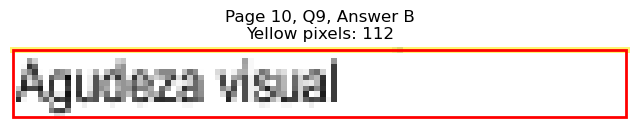

Page 10, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=139.6, y1=723.8
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 264
Page 10, Q9, C: Yellow percentage: 0.0%


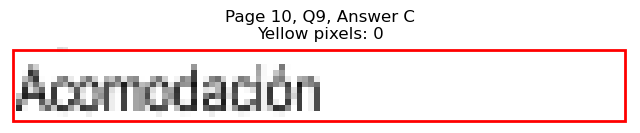

Page 10, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=381.7, y1=699.7
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 231
Page 10, Q9, D: Yellow percentage: 0.0%


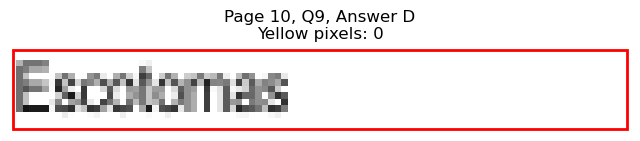

Page 10, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=432.6, y1=711.7
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 460
Page 10, Q9, E: Yellow percentage: 0.0%


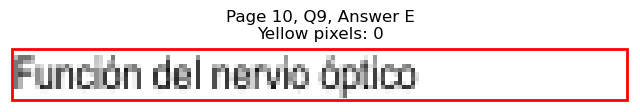


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   En una limitación de la motilidad ocular, se s...
1   ¿En cuál de las siguientes patologías, se pres...
2   Prematuro con retinopatía, peso menor a 1200 g...
3   En los defectos del campo visual que se presen...
4   Varón de 27 años, sin antecedentes cardiovascu...
..                                                ...
95  ¿Cuál de las siguientes patologías se caracter...
96  ¿Cuál es el tamaño aproximado en centímetros d...
97  ¿Cuál es la función de la capa lipídica de la ...
98  Mujer de 50 años, con dolor intenso y disminuc...
99  ¿Qué nos permite evaluar el examen del reflejo...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       disminuye / 4   
1                                      Homocistinuria   
2                     Grado 2 en zona II en regresión   
3   Neuropatía óptica isquémica anterior: respeto ...   
4                                           Purtscher   
..                                                ...   
95                  Síndrome de Vogt Koyanagui Harada   
96                                                 35   
97      Permitir que la película lagrimal se extienda   
98                                            Uveítis   
99                         Alineamiento de eje visual   

                                             option_B  \
0                                         aumenta / 4   
1                                            Melanoma   
2                         Grado 1 en zona II sin plus   
3   Desmielinización: respeto del meridiano horizo...   
4                                               Eales   
..                                                ...   
95                           Coroidopatía serpiginosa   
96                                                 20   
97              Facilitar el transporte de leucocitos   
98                                         Queratitis   
99                                     Agudeza visual   

                                      option_C  \
0                                disminuye / 6   
1                               Retinoblastoma   
2                   Retina inmadura en zona II   
3                   Glaucoma: escotoma central   
4                                        Coats   
..                                         ...   
95                Síndrome de uveitis de Fuchs   
96                                          46   
97  Proporcionar una superficie óptica regular   
98                                  Escleritis   
99                                 Acomodación   

                           option_D  \
0                     disminuye / 2   
1             Fístula arteriovenosa   
2   Grado 2 o 3 en zona II sin plus   
3        Nutricional: escalón nasal   
4                             Paton   
..                              ...   
95                         Síndrome   
96                               17   
97         Actividad antibacteriana   
98                   Glaucoma agudo   
99                        Escotomas   

                                             option_E  
0                                         aumenta / 6  
1                                            Leucemia  
2                        Grado 2 en zona III sin plus  
3              Papiledema: aumento de la mancha ciega  
4                                             Sattler  
..                                                ...  
95                               Toxoplasmosis activa  
96                                                 24  
97  Suministrar oxígeno atmosférico al epitelio co...  
98                                      Conjuntivitis  
99                          Función del nervio óptico  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               E
4               B
..            ...
95              A
96              A
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   En una limitación de la motilidad ocular, se s...   
1   ¿En cuál de las siguientes patologías, se pres...   
2   Prematuro con retinopatía, peso menor a 1200 g...   
3   En los defectos del campo visual que se presen...   
4   Varón de 27 años, sin antecedentes cardiovascu...   
..                                                ...   
95  ¿Cuál de las siguientes patologías se caracter...   
96  ¿Cuál es el tamaño aproximado en centímetros d...   
97  ¿Cuál es la función de la capa lipídica de la ...   
98  Mujer de 50 años, con dolor intenso y disminuc...   
99  ¿Qué nos permite evaluar el examen del reflejo...   

                                             option_A  \
0                                       disminuye / 4   
1                                      Homocistinuria   
2                     Grado 2 en zona II en regresión   
3   Neuropatía óptica isquémica anterior: respeto ...   
4                                           Purtscher   
..                                                ...   
95                  Síndrome de Vogt Koyanagui Harada   
96                                                 35   
97      Permitir que la película lagrimal se extienda   
98                                            Uveítis   
99                         Alineamiento de eje visual   

                                             option_B  \
0                                         aumenta / 4   
1                                            Melanoma   
2                         Grado 1 en zona II sin plus   
3   Desmielinización: respeto del meridiano horizo...   
4                                               Eales   
..                                                ...   
95                           Coroidopatía serpiginosa   
96                                                 20   
97              Facilitar el transporte de leucocitos   
98                                         Queratitis   
99                                     Agudeza visual   

                                      option_C  \
0                                disminuye / 6   
1                               Retinoblastoma   
2                   Retina inmadura en zona II   
3                   Glaucoma: escotoma central   
4                                        Coats   
..                                         ...   
95                Síndrome de uveitis de Fuchs   
96                                          46   
97  Proporcionar una superficie óptica regular   
98                                  Escleritis   
99                                 Acomodación   

                           option_D  \
0                     disminuye / 2   
1             Fístula arteriovenosa   
2   Grado 2 o 3 en zona II sin plus   
3        Nutricional: escalón nasal   
4                             Paton   
..                              ...   
95                         Síndrome   
96                               17   
97         Actividad antibacteriana   
98                   Glaucoma agudo   
99                        Escotomas   

                                             option_E correct_answer  
0                                         aumenta / 6              E  
1                                            Leucemia              C  
2                        Grado 2 en zona III sin plus              D  
3              Papiledema: aumento de la mancha ciega              E  
4                                             Sattler              B  
..                                                ...            ...  
95                               Toxoplasmosis activa              A  
96                                                 24              A  
97  Suministrar oxígeno atmosférico al epitelio co...              A  
98                                      Conjuntivitis              D  
99                          Función del nervio óptico              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/OFTALMOLOGIA.csv
